In [172]:
import pandas as pd
import matplotlib.pyplot as pl
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [173]:
import functions as fn
grav_domains = fn.load_gravity(dir='').domain.values
grav_df = pd.DataFrame({'domain':grav_domains,'blocked':np.ones(len(grav_domains))})

In [805]:
from sqlalchemy import create_engine

db_connect = create_engine('sqlite:///pihole-FTL.db')
connection = db_connect.raw_connection()
tstamp = '1600397251'
df = pd.read_sql("SELECT * FROM queries", con=connection)
df['blocked'] = df.status.apply(lambda x: 0 if x in [2,3] else 1)
df = pd.concat([df,grav_df])
df.domain = df.domain.apply(lambda x: ' '.join(x.split('.')))

np.savetxt('domains.txt',df.domain.values,fmt="%s")
print(df.domain)

0        mobile pipe aria microsoft com
1        mobile pipe aria microsoft com
2                 telemetry dropbox com
3                        login live com
4                        edge skype com
                      ...              
83445          xn--localbitcins-vcd com
83446                   siambiznews com
83447                lp searchmulty com
83448                         usibw top
83449          leanproconsulting com br
Name: domain, Length: 112930, dtype: object


In [1021]:
def make_mask(x):
    y = np.zeros(100)
    y[:x] = 1
    return y

def make_multilabel(x):
    x_ = list(map(lambda xx: int(xx),x.split(' ')))
    y = np.zeros(100)
    y[range(len(x_))] = x_
    return y

In [1022]:
import random
import youtokentome as yttm

train_data_path = "domains.txt"
model_path = "yttm_ads.model"

# Training model
yttm.BPE.train(data=train_data_path, vocab_size=500, model=model_path)

# Loading model
bpe = yttm.BPE(model=model_path)

# Two types of tokenization
print(bpe.encode(list(' '.join(df.domain.values[0].split('.'))), output_type=yttm.OutputType.ID))
print(bpe.encode(list(df.domain.values[0]), output_type=yttm.OutputType.SUBWORD))
print(' '.join(df.domain.values[0].split('.')))

[[64], [125], [73], [93], [86], [97], [], [54], [93], [54], [97], [], [48], [114], [93], [48], [], [64], [93], [45], [114], [125], [55], [125], [85], [69], [], [45], [125], [64]]
[['▁m'], ['▁o'], ['▁b'], ['▁i'], ['▁l'], ['▁e'], [], ['▁p'], ['▁i'], ['▁p'], ['▁e'], [], ['▁a'], ['▁r'], ['▁i'], ['▁a'], [], ['▁m'], ['▁i'], ['▁c'], ['▁r'], ['▁o'], ['▁s'], ['▁o'], ['▁f'], ['▁t'], [], ['▁c'], ['▁o'], ['▁m']]
mobile pipe aria microsoft com


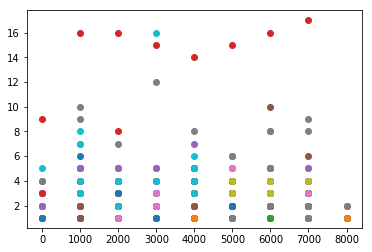

In [1023]:
format_df = df.groupby('timestamp').sum().reset_index()
format_df['domain'] = df.groupby('timestamp')['domain'].apply(lambda x: '|'.join(x)).reset_index()['domain']
format_df['domain_list'] = df.groupby('timestamp')['domain'].apply(lambda x: ','.join(x)).reset_index()['domain']
format_df['mask_count'] = df.groupby('timestamp')['domain'].apply(lambda x: len(x)).reset_index()['domain']
format_df['domain'] = format_df['domain'].apply(lambda x: ' '.join(x.split('.')))
format_df['blocked_chain'] = df.groupby('timestamp')['blocked'].apply(lambda x: ' '.join([str(int(i)) for i in x])).reset_index()['blocked']

In [1075]:
# Apply some data augmentation

def random_sort(domains,blocks):
    domains_ = np.array(domains.split('|'))
    blocks_ = np.array(blocks.split(' '))
    xind = np.random.permutation(range(len(domains_)))
    print(domains_)
    domains_ = domains_[xind]
    blocks_ = blocks_[xind]
    return ' '.join(domains_),' '.join(blocks_)

for m in range(4):
    augment_df = format_df.copy()
    for i in range(len(augment_df)):
        print(i)
        d = augment_df['domain'][i]
        bc = augment_df['blocked_chain'][i]
        print(d)
        d_,bc_ = random_sort(d,bc)
        augment_df['domain'][i] = d_
        augment_df['blocked_chain'][i] = bc_
    if m == 0:
        new_df = pd.concat([format_df,augment_df])
    else:
        new_df = pd.concat([new_df,augment_df])

0
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
1
telemetry dropbox com
['telemetry dropbox com']
2
login live com|edge skype com|ocsp apple com|config edge skype com|prod registrar skype com|api asm skype com
['login live com' 'edge skype com' 'ocsp apple com'
 'config edge skype com' 'prod registrar skype com' 'api asm skype com']
3
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4
caldav fe apple-dns net
['caldav fe apple-dns net']
5
zpns zoom us|nexus officeapps live com|officeclient microsoft com|ocos-office365-s2s-msedge-net e-0009 e-msedge net|client-office365-tas msedge net|maps gstatic com|nexusrules officeapps live com
['zpns zoom us' 'nexus officeapps live com' 'officeclient microsoft com'
 'ocos-office365-s2s-msedge-net e-0009 e-msedge net'
 'client-office365-tas msedge net' 'maps gstatic com'
 'nexusrules officeapps live com']
6
nexus officeapps live com
['nexu

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



['translate google com' 'dl google com' 'translate googleapis com'
 'clients1 google com']
293
androidpay-users-pa googleapis com|secure-us imrworldwide com|youtubei googleapis com|s innovid com|www googleapis com|www googleapis com|ad doubleclick net
['androidpay-users-pa googleapis com' 'secure-us imrworldwide com'
 'youtubei googleapis com' 's innovid com' 'www googleapis com'
 'www googleapis com' 'ad doubleclick net']
294
discourse pi-hole net|i ytimg com
['discourse pi-hole net' 'i ytimg com']
295
capi samsungcloud com|googleads g doubleclick net|www googleadservices com|clients4 google com
['capi samsungcloud com' 'googleads g doubleclick net'
 'www googleadservices com' 'clients4 google com']
296
instantmessaging-pa googleapis com|bunsen yelp com|settings crashlytics com
['instantmessaging-pa googleapis com' 'bunsen yelp com'
 'settings crashlytics com']
297
yildun iad-03 braze com|app-measurement com|bunsen-auditor yelp com|auto-api yelp com
['yildun iad-03 braze com' 'app-me

587
gateway fe apple-dns net|ocsp-lb apple com akadns net
['gateway fe apple-dns net' 'ocsp-lb apple com akadns net']
588
telemetry dropbox com
['telemetry dropbox com']
589
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
590
caldav fe apple-dns net
['caldav fe apple-dns net']
591
ads-e-darwin hulustream com
['ads-e-darwin hulustream com']
592
me apple-dns net
['me apple-dns net']
593
weather-data apple com|weather-data apple com|a2047 dscb akamai net|time apple com
['weather-data apple com' 'weather-data apple com' 'a2047 dscb akamai net'
 'time apple com']
594
gateway fe apple-dns net|gateway fe apple-dns net|apple-finance query yahoo com|apple-finance query yahoo com|stocks-sparkline-lb apple com akadns net|stocks-sparkline-lb apple com akadns net|geo-applefinance-cache internal query g03 yahoodns net|e16126 dscg akamaiedge net|e16126 dscg akamaiedge net
['gateway fe apple-dns net' 'gateway fe apple-dns net'
 'apple-finance query yahoo com' 'apple-finan

805
telemetry dropbox com
['telemetry dropbox com']
806
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
807
tpc googlesyndication com|googleads g doubleclick net
['tpc googlesyndication com' 'googleads g doubleclick net']
808
www-linkedin-com l-0005 l-msedge net
['www-linkedin-com l-0005 l-msedge net']
809
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
810
service game-mode net
['service game-mode net']
811
www googleapis com
['www googleapis com']
812
r1---sn-8xgp1vo-2ial gvt1 com
['r1---sn-8xgp1vo-2ial gvt1 com']
813
r8---sn-8xgp1vo-ab5e gvt1 com
['r8---sn-8xgp1vo-ab5e gvt1 com']
814
youtube-ui l google com
['youtube-ui l google com']
815
nexus officeapps live com
['nexus officeapps live com']
816
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
817
edge skype com|edge skype com|s-0001 s-msedge net
['edge skype com' 'edge skype com' 's-0001 s-m

 'pubads g doubleclick net']
1101
fonts gstatic com
['fonts gstatic com']
1102
time-macos apple com
['time-macos apple com']
1103
i9 ytimg com
['i9 ytimg com']
1104
r3---sn-aigl6nl7 googlevideo com
['r3---sn-aigl6nl7 googlevideo com']
1105
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1106
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
1107
xmpp006 hpeprint com
['xmpp006 hpeprint com']
1108
xmpp006 hpeprint com
['xmpp006 hpeprint com']
1109
xmpp006 hpeprint com
['xmpp006 hpeprint com']
1110
xmpp006 hpeprint com
['xmpp006 hpeprint com']
1111
xmpp006 hpeprint com
['xmpp006 hpeprint com']
1112
init itunes apple com|init itunes apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net
['init itunes apple com' 'init itunes apple com'
 'e673 dsce9 akamaiedge net' 'e673 dsce9 akamaiedge net']
1113
weather-data apple com|weather-data apple com|play itunes apple com|play itunes

1306
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1307
youtube-ui l google com
['youtube-ui l google com']
1308
safebrowsing googleapis com
['safebrowsing googleapis com']
1309
mobile launchdarkly com
['mobile launchdarkly com']
1310
i ytimg com
['i ytimg com']
1311
telemetry malwarebytes com
['telemetry malwarebytes com']
1312
securepubads g doubleclick net
['securepubads g doubleclick net']
1313
telemetry dropbox com
['telemetry dropbox com']
1314
tpc googlesyndication com|googleads g doubleclick net
['tpc googlesyndication com' 'googleads g doubleclick net']
1315
preview redd it
['preview redd it']
1316
external-preview redd it
['external-preview redd it']
1317
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1318
gum criteo com|www aaxdetect com|s aaxads com|alb reddit com|www redditstatic com
['gum criteo com' 'www aaxdetect com' 's aaxads com' 'alb reddit com'
 'www redditstatic com']
1319
c aaxads com|www reddit com|w

1537
securepubads g doubleclick net|i ytimg com
['securepubads g doubleclick net' 'i ytimg com']
1538
photos-ugc l googleusercontent com
['photos-ugc l googleusercontent com']
1539
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1540
telemetry malwarebytes com
['telemetry malwarebytes com']
1541
www googleadservices com|telemetry dropbox com
['www googleadservices com' 'telemetry dropbox com']
1542
i9 ytimg com
['i9 ytimg com']
1543
d dropbox com
['d dropbox com']
1544
github com
['github com']
1545
www google com|travis-ci org
['www google com' 'travis-ci org']
1546
api travis-ci org
['api travis-ci org']
1547
www gstatic com|encrypted-tbn0 gstatic com|plus l google com
['www gstatic com' 'encrypted-tbn0 gstatic com' 'plus l google com']
1548
adservice google com
['adservice google com']
1549
pypi org|fonts googleapis com|cdn ravenjs com|www googletagmanager com|www fastly-insights com|warehouse-camo ingress cmh1 psfhosted org|telemetry dropbox com|fonts 

ecs wup shop nintendo net
['ecs wup shop nintendo net']
1792
telemetry dropbox com
['telemetry dropbox com']
1793
play google com
['play google com']
1794
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1795
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
1796
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1797
r8---sn-8xgp1vo-p5ql googlevideo com|securepubads g doubleclick net
['r8---sn-8xgp1vo-p5ql googlevideo com' 'securepubads g doubleclick net']
1798
i ytimg com|r2---sn-5hne6nsz googlevideo com
['i ytimg com' 'r2---sn-5hne6nsz googlevideo com']
1799
github com|old reddit com|youtube-ui l google com
['github com' 'old reddit com' 'youtube-ui l google com']
1800
telemetry dropbox com
['telemetry dropbox com']
1801
time-macos apple com
['time-macos apple com']
1802
gcp api snapchat com
['gcp api snapchat com']
1803
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
18

1984
device-metrics-us amazon com
['device-metrics-us amazon com']
1985
inbox google com
['inbox google com']
1986
device-metrics-us amazon com
['device-metrics-us amazon com']
1987
e12767 d akamaiedge net|www googletagmanager com
['e12767 d akamaiedge net' 'www googletagmanager com']
1988
device-metrics-us amazon com
['device-metrics-us amazon com']
1989
telemetry malwarebytes com
['telemetry malwarebytes com']
1990
device-metrics-us amazon com
['device-metrics-us amazon com']
1991
telemetry dropbox com|peoplestack-pa googleapis com
['telemetry dropbox com' 'peoplestack-pa googleapis com']
1992
duckduckgo com
['duckduckgo com']
1993
improving duckduckgo com
['improving duckduckgo com']
1994
device-metrics-us amazon com|device-metrics-us amazon com|external-content duckduckgo com
['device-metrics-us amazon com' 'device-metrics-us amazon com'
 'external-content duckduckgo com']
1995
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1996
ocsp-lb apple com akad

2241
device-metrics-us amazon com
['device-metrics-us amazon com']
2242
device-metrics-us amazon com
['device-metrics-us amazon com']
2243
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2244
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2245
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2246
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2247
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2248
xmpp006 hpeprint com|xmpp006 hpeprint com
['xmpp006 hpeprint com' 'xmpp006 hpeprint com']
2249
device-metrics-us amazon com|device-metrics-us amazon com
['device-metrics-us amazon com' 'device-metrics-us amazon com']
2250
device-metrics-us amazon com
['device-metrics-us amazon com']
2251
device-metrics-us amazon com
['device-metrics-us amazon com']
2252
device-metrics-us amazon com
['device-metrics-us amazon com']
2253
device-metrics-us amazon com
['device-metrics-us amazon com']
2254
device-metrics-us amazon com
['device-metrics-us amazon com']
2255
119 0 168 192 in-addr arpa|147 0 168 192 in-addr 

2486
npts app nintendo net
['npts app nintendo net']
2487
ecs wup shop nintendo net
['ecs wup shop nintendo net']
2488
weather-data apple com|weather-data apple com|a2047 dscb akamai net|a2047 dscb akamai net
['weather-data apple com' 'weather-data apple com' 'a2047 dscb akamai net'
 'a2047 dscb akamai net']
2489
gsp-ssl ls apple com|gsp-ssl ls apple com|get-bx g aaplimg com|get-bx g aaplimg com
['gsp-ssl ls apple com' 'gsp-ssl ls apple com' 'get-bx g aaplimg com'
 'get-bx g aaplimg com']
2490
android clients google com|app-analytics snapchat com
['android clients google com' 'app-analytics snapchat com']
2491
googleads g doubleclick net|www googleadservices com
['googleads g doubleclick net' 'www googleadservices com']
2492
play googleapis com
['play googleapis com']
2493
googleads g doubleclick net|www googleadservices com
['googleads g doubleclick net' 'www googleadservices com']
2494
googleads g doubleclick net|www googleadservices com
['googleads g doubleclick net' 'www googleadse

2725
mail google com|android googleapis com|peoplestack-pa googleapis com|www google com
['mail google com' 'android googleapis com'
 'peoplestack-pa googleapis com' 'www google com']
2726
mobile-webview gmail com|ci6 googleusercontent com|ci3 googleusercontent com|ci4 googleusercontent com|ci5 googleusercontent com
['mobile-webview gmail com' 'ci6 googleusercontent com'
 'ci3 googleusercontent com' 'ci4 googleusercontent com'
 'ci5 googleusercontent com']
2727
lh3 googleusercontent com
['lh3 googleusercontent com']
2728
sessions bugsnag com
['sessions bugsnag com']
2729
old reddit com
['old reddit com']
2730
out reddit com|www redditstatic com|b thumbs redditmedia com|preview redd it|a thumbs redditmedia com|i redd it|reddit com
['out reddit com' 'www redditstatic com' 'b thumbs redditmedia com'
 'preview redd it' 'a thumbs redditmedia com' 'i redd it' 'reddit com']
2731
www redditmedia com|www googletagservices com|c aaxads com|c amazon-adsystem com|www reddit com
['www redditmedia c

['telemetry dropbox com']
2976
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
2977
safebrowsing googleapis com
['safebrowsing googleapis com']
2978
incoming telemetry mozilla org|dcist com|www popville com|www marketwatch com|www zillow com|www3 l google com|www worldometers info|getpocket com
['incoming telemetry mozilla org' 'dcist com' 'www popville com'
 'www marketwatch com' 'www zillow com' 'www3 l google com'
 'www worldometers info' 'getpocket com']
2979
www google com|b thumbs redditmedia com|a thumbs redditmedia com|www redditstatic com|preview redd it|c amazon-adsystem com|www googletagservices com|c aaxads com|www aaxdetect com|gum criteo com|s aaxads com|l3 aaxads com|alb reddit com
['www google com' 'b thumbs redditmedia com' 'a thumbs redditmedia com'
 'www redditstatic com' 'preview redd it' 'c amazon-adsystem com'
 'www googletagservices com' 'c aaxads com' 'www aaxdetect com'
 'gum criteo com' 's aaxads com' 'l3 aaxads com' 'alb reddit c

3188
telemetry dropbox com
['telemetry dropbox com']
3189
www google com|www gstatic com|encrypted-tbn0 gstatic com|adservice google com
['www google com' 'www gstatic com' 'encrypted-tbn0 gstatic com'
 'adservice google com']
3190
googleads g doubleclick net
['googleads g doubleclick net']
3191
ssl gstatic com
['ssl gstatic com']
3192
camo githubusercontent com|github com
['camo githubusercontent com' 'github com']
3193
collector githubapp com|api github com
['collector githubapp com' 'api github com']
3194
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3195
telemetry dropbox com
['telemetry dropbox com']
3196
googleads g doubleclick net
['googleads g doubleclick net']
3197
29627a66 api splkmobile com|px-conf perimeterx net|zm zillow com|firebase-settings crashlytics com|www google com|firebaseremoteconfig googleapis com
['29627a66 api splkmobile com' 'px-conf perimeterx net' 'zm zillow com'
 'firebase-settings crashlytics com' 'www google com'
 'firebas

3344
store storeimages cdn-apple com|www apple com|securemetrics apple com
['store storeimages cdn-apple com' 'www apple com'
 'securemetrics apple com']
3345
www fedex com
['www fedex com']
3346
xp apple com
['xp apple com']
3347
code jquery com|telemetry dropbox com
['code jquery com' 'telemetry dropbox com']
3348
fonts googleapis com|fonts gstatic com|sonar fedex com
['fonts googleapis com' 'fonts gstatic com' 'sonar fedex com']
3349
sonar fedex epsihost com
['sonar fedex epsihost com']
3350
smetrics fedex com
['smetrics fedex com']
3351
notify adobe io
['notify adobe io']
3352
github com
['github com']
3353
collector-pxhyx10rg3 px-cloud net
['collector-pxhyx10rg3 px-cloud net']
3354
www google com|ss-prod-ue1-notif-59 aws adobess com
['www google com' 'ss-prod-ue1-notif-59 aws adobess com']
3355
incoming telemetry mozilla org
['incoming telemetry mozilla org']
3356
old reddit com|dcist com|www popville com|www marketwatch com|www zillow com|www3 l google com|www worldometers info|g

3626
www google com
['www google com']
3627
sessions bugsnag com
['sessions bugsnag com']
3628
e crashlytics com
['e crashlytics com']
3629
analytics robinhood com|api robinhood com|reports crashlytics com
['analytics robinhood com' 'api robinhood com' 'reports crashlytics com']
3630
simplisafe com|nummus robinhood com|phoenix robinhood com|api2 branch io|firebaseremoteconfig googleapis com|gohan robinhood com
['simplisafe com' 'nummus robinhood com' 'phoenix robinhood com'
 'api2 branch io' 'firebaseremoteconfig googleapis com'
 'gohan robinhood com']
3631
mesu apple com|android clients google com|play-lh googleusercontent com|connectivitycheck gstatic com|gcp api snapchat com
['mesu apple com' 'android clients google com'
 'play-lh googleusercontent com' 'connectivitycheck gstatic com'
 'gcp api snapchat com']
3632
crumbs robinhood com
['crumbs robinhood com']
3633
reports crashlytics com|app-measurement com
['reports crashlytics com' 'app-measurement com']
3634
ss-prod-ue1-notif-59 

3953
eus1-authgw cloudapp net|1180c ec azureedge net
['eus1-authgw cloudapp net' '1180c ec azureedge net']
3954
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3955
www google com
['www google com']
3956
preview redd it|a thumbs redditmedia com|www aaxdetect com|gum criteo com|old reddit com|s aaxads com|alb reddit com
['preview redd it' 'a thumbs redditmedia com' 'www aaxdetect com'
 'gum criteo com' 'old reddit com' 's aaxads com' 'alb reddit com']
3957
www redditstatic com|b thumbs redditmedia com|firefox settings services mozilla com|www redditmedia com|reddit com|c aaxads com|www reddit com
['www redditstatic com' 'b thumbs redditmedia com'
 'firefox settings services mozilla com' 'www redditmedia com'
 'reddit com' 'c aaxads com' 'www reddit com']
3958
l3 aaxads com|www googletagmanager com
['l3 aaxads com' 'www googletagmanager com']
3959
telemetry dropbox com
['telemetry dropbox com']
3960
acp-ss-ue1 adobe io
['acp-ss-ue1 adobe io']
3961
play googl

4186
www reddit com
['www reddit com']
4187
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4188
www google com
['www google com']
4189
telemetry dropbox com
['telemetry dropbox com']
4190
nexus officeapps live com|oauth2 googleapis com
['nexus officeapps live com' 'oauth2 googleapis com']
4191
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
4192
compiles overleaf com
['compiles overleaf com']
4193
www googleapis com
['www googleapis com']
4194
notify adobe io
['notify adobe io']
4195
gateway icloud com
['gateway icloud com']
4196
www google com
['www google com']
4197
telemetry malwarebytes com
['telemetry malwarebytes com']
4198
p15-caldav icloud com
['p15-caldav icloud com']
4199
ocos-office365-s2s-msedge-net e-0009 e-msedge net
['ocos-office365-s2s-msedge-net e-0009 e-msedge net']
4200
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4201
imap gmail com
['imap gmail com']
4202
adservice google 

keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net']
4457
static asm skype com
['static asm skype com']
4458
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4459
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com|lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
['lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com'
 'lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com']
4460
adserver pandora com|adserver pandora com
['adserver pandora com' 'adserver pandora com']
4461
app-measurement com
['app-measurement com']
4462
telemetry dropbox com
['telemetry dropbox com']
4463
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4464
collector-pxhyx10rg3 px-cloud net
['collector-pxhyx10rg3 px-cloud net']
4465
www google com
['www google com']
4466
mobile pipe aria microsoft com|mobile pipe aria microsoft com|d dropbox com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com'
 'd dropbox com']
4467
lt501

4735
time-osx g aaplimg com|caldav fe apple-dns net|fedex com ssl d2 sc omtrdc net
['time-osx g aaplimg com' 'caldav fe apple-dns net'
 'fedex com ssl d2 sc omtrdc net']
4736
www linkedin com
['www linkedin com']
4737
outlook ms-acdc office com|imap gmail com
['outlook ms-acdc office com' 'imap gmail com']
4738
time-osx g aaplimg com
['time-osx g aaplimg com']
4739
live github com
['live github com']
4740
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
4741
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
4742
nexus officeapps live com|www google com|www google com
['nexus officeapps live com' 'www google com' 'www google com']
4743
audio-usc-mp1-t1-2-v4v6 pandora com|audio-usc-mp1-t1-2-v4v6 pandora com|cont-4 p-cdn us|cont-4 p-cdn us
['audio-usc-mp1-t1-2-v4v6 pandora com'
 'audio-usc-mp1-t1-2-v4v6 pandora com' 'cont-4 p-cdn us' 'cont-4 p-cdn us']
4744
lt501 tritondigital com|lt501 tritondigital co

4917
www traffic-test dropbox-dns com
['www traffic-test dropbox-dns com']
4918
discourse pi-hole net
['discourse pi-hole net']
4919
telemetry dropbox com
['telemetry dropbox com']
4920
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4921
lt501 tritondigital com|lt501 tritondigital com
['lt501 tritondigital com' 'lt501 tritondigital com']
4922
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
4923
code jquery com
['code jquery com']
4924
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
4925
fedex com ssl d2 sc omtrdc net
['fedex com ssl d2 sc omtrdc net']
4926
www google com
['www google com']
4927
sessions bugsnag com
['sessions bugsnag com']
4928
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4929
api dropboxapi com
['api dropboxapi com']
4930
telemetry dropbox com
['telemetry dropbox com']
4931
e8304 dsca akamaiedge net
['e8304 dsca akam

old reddit com
['old reddit com']
5123
telemetry dropbox com
['telemetry dropbox com']
5124
polka typekit com
['polka typekit com']
5125
browser pipe aria microsoft com
['browser pipe aria microsoft com']
5126
safebrowsing googleapis com
['safebrowsing googleapis com']
5127
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
5128
www linkedin com|www google com
['www linkedin com' 'www google com']
5129
sonar fedex epsihost com|zpns zoom us
['sonar fedex epsihost com' 'zpns zoom us']
5130
telemetry dropbox com
['telemetry dropbox com']
5131
acp-ss-ue1 adobe io|ss-prod-ue1-notif-59 aws adobess com
['acp-ss-ue1 adobe io' 'ss-prod-ue1-notif-59 aws adobess com']
5132
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
5133
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
5134
www apple com edgekey net globalredir akadns net|www-cdn icl

 'www reddit com' 'l3 aaxads com' 'www googletagmanager com']
5423
telemetry dropbox com
['telemetry dropbox com']
5424
zpns zoom us
['zpns zoom us']
5425
safebrowsing googleapis com
['safebrowsing googleapis com']
5426
v redd it
['v redd it']
5427
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5428
reddit-image s3 amazonaws com
['reddit-image s3 amazonaws com']
5429
www linkedin com|normandy cdn mozilla net
['www linkedin com' 'normandy cdn mozilla net']
5430
classify-client services mozilla com|d2nxq2uap88usk cloudfront net
['classify-client services mozilla com' 'd2nxq2uap88usk cloudfront net']
5431
telemetry dropbox com
['telemetry dropbox com']
5432
reddit map fastly net
['reddit map fastly net']
5433
alb reddit com|www reddit com
['alb reddit com' 'www reddit com']
5434
external-preview redd it
['external-preview redd it']
5435
notify adobe io
['notify adobe io']
5436
caldav fe apple-dns net|v redd it
['caldav fe apple-dns net' 'v redd it']
5437
zpn

5661
googleads g doubleclick net
['googleads g doubleclick net']
5662
weather-data apple com|weather-data apple com|geo-applefinance-cache internal query g03 yahoodns net|geo-applefinance-cache internal query g03 yahoodns net|stocks-sparkline apple com|stocks-sparkline apple com|a2047 dscb akamai net|e16126 dscg akamaiedge net|e16126 dscg akamaiedge net
['weather-data apple com' 'weather-data apple com'
 'geo-applefinance-cache internal query g03 yahoodns net'
 'geo-applefinance-cache internal query g03 yahoodns net'
 'stocks-sparkline apple com' 'stocks-sparkline apple com'
 'a2047 dscb akamai net' 'e16126 dscg akamaiedge net'
 'e16126 dscg akamaiedge net']
5663
ss-prod-ue1-notif-59 aws adobess com|mobile pipe aria microsoft com|mobile pipe aria microsoft com
['ss-prod-ue1-notif-59 aws adobess com' 'mobile pipe aria microsoft com'
 'mobile pipe aria microsoft com']
5664
gsp-ssl ls apple com|gsp-ssl ls apple com|get-bx g aaplimg com|get-bx g aaplimg com
['gsp-ssl ls apple com' 'gsp-ssl

5935
e5239 e9 akamaiedge net|www apple com
['e5239 e9 akamaiedge net' 'www apple com']
5936
securemetrics apple com
['securemetrics apple com']
5937
www overleaf com
['www overleaf com']
5938
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5939
old reddit com|github com
['old reddit com' 'github com']
5940
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
5941
borishaeussler github io
['borishaeussler github io']
5942
compiles overleaf com
['compiles overleaf com']
5943
d dropbox com
['d dropbox com']
5944
www-linkedin-com l-0005 l-msedge net
['www-linkedin-com l-0005 l-msedge net']
5945
clients1 google com|ui adsabs harvard edu|configuration apple com akadns net|api-glb-use1c smoot apple com
['clients1 google com' 'ui adsabs harvard edu'
 'configuration apple com akadns net' 'api-glb-use1c smoot apple com']
5946
nexus officeapps live com|unpkg com|recaptcha net|google com
['ne

6189
geo-applefinance-cache internal query g03 yahoodns net|geo-applefinance-cache internal query g03 yahoodns net|weather-data apple com|weather-data apple com|stocks-sparkline-lb apple com akadns net|stocks-sparkline-lb apple com akadns net|e16126 dscg akamaiedge net|e16126 dscg akamaiedge net|a2047 dscb akamai net
['geo-applefinance-cache internal query g03 yahoodns net'
 'geo-applefinance-cache internal query g03 yahoodns net'
 'weather-data apple com' 'weather-data apple com'
 'stocks-sparkline-lb apple com akadns net'
 'stocks-sparkline-lb apple com akadns net' 'e16126 dscg akamaiedge net'
 'e16126 dscg akamaiedge net' 'a2047 dscb akamai net']
6190
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6191
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
6192
k8 overleaf com
['k8 overleaf com']
6193
browser pipe aria microsoft com
['browser pipe aria microsoft com']
6194
www overlea

6455
reports crashlytics com
['reports crashlytics com']
6456
www google com|www google com|googleads g doubleclick net
['www google com' 'www google com' 'googleads g doubleclick net']
6457
reports crashlytics com
['reports crashlytics com']
6458
static-asm-skype trafficmanager net|local
['static-asm-skype trafficmanager net' 'local']
6459
reports crashlytics com
['reports crashlytics com']
6460
config edge skype com
['config edge skype com']
6461
zpns zoom us
['zpns zoom us']
6462
azwus1-client-s gateway messenger live com
['azwus1-client-s gateway messenger live com']
6463
local|inbox google com
['local' 'inbox google com']
6464
spocs getpocket com|img-getpocket cdn mozilla net|gateway fe apple-dns net
['spocs getpocket com' 'img-getpocket cdn mozilla net'
 'gateway fe apple-dns net']
6465
telemetry dropbox com
['telemetry dropbox com']
6466
i geistm com|unbouncepages com
['i geistm com' 'unbouncepages com']
6467
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobes

6705
incoming telemetry mozilla org
['incoming telemetry mozilla org']
6706
play google com
['play google com']
6707
safebrowsing googleapis com
['safebrowsing googleapis com']
6708
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6709
static-asm-skype trafficmanager net
['static-asm-skype trafficmanager net']
6710
lcs-cops adobe io|lcs-robs adobe io
['lcs-cops adobe io' 'lcs-robs adobe io']
6711
www google com|incoming telemetry mozilla org
['www google com' 'incoming telemetry mozilla org']
6712
old reddit com|dcist com|www popville com|www marketwatch com|www zillow com|www3 l google com|www worldometers info|getpocket com|mlinproduction com|coveralls io|i geistm com|www nytimes com|www glamour com|unbouncepages com
['old reddit com' 'dcist com' 'www popville com' 'www marketwatch com'
 'www zillow com' 'www3 l google com' 'www worldometers info'
 'getpocket com' 'mlinproduction com' 'coveralls io' 'i geistm com'
 'www nytimes com' 'www glamour com' 'unb

6975
zpns zoom us
['zpns zoom us']
6976
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6977
telemetry malwarebytes com
['telemetry malwarebytes com']
6978
alive github com
['alive github com']
6979
nus1-authgw cloudapp net
['nus1-authgw cloudapp net']
6980
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6981
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
6982
incoming telemetry mozilla org|www google com
['incoming telemetry mozilla org' 'www google com']
6983
reddit map fastly net|dcist com|www popville com|www marketwatch com|www zillow com|www3 l google com|www worldometers info|getpocket com|www overleaf com|ggwash org|i geistm com|www glamour com|unbouncepages com|www nytimes com
['reddit map fastly net' 'dcist com' 'www popville com'
 'www marketwatch com' 'www zillow com' 'www3 l google com'
 'www worldometers info' 'getpocket com' 'www 

www linkedin com
['www linkedin com']
7193
collector githubapp com|github map fastly net|github com|camo githubusercontent com
['collector githubapp com' 'github map fastly net' 'github com'
 'camo githubusercontent com']
7194
raw githubusercontent com|api github com
['raw githubusercontent com' 'api github com']
7195
d dropbox com
['d dropbox com']
7196
telemetry dropbox com
['telemetry dropbox com']
7197
gsp-ssl ls apple com
['gsp-ssl ls apple com']
7198
analytics localytics com
['analytics localytics com']
7199
discourse pi-hole net
['discourse pi-hole net']
7200
www google com
['www google com']
7201
www google com|analytics localytics com
['www google com' 'analytics localytics com']
7202
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
7203
analytics localytics com
['analytics localytics com']
7204
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7205
telemetry malwarebyt

ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7392
zpns zoom us|xmppapi zoom us
['zpns zoom us' 'xmppapi zoom us']
7393
alb reddit com
['alb reddit com']
7394
gum criteo com|e11089 d akamaiedge net|e12767 d akamaiedge net
['gum criteo com' 'e11089 d akamaiedge net' 'e12767 d akamaiedge net']
7395
www reddit com|www googletagmanager com
['www reddit com' 'www googletagmanager com']
7396
telemetry dropbox com
['telemetry dropbox com']
7397
reddit map fastly net
['reddit map fastly net']
7398
www linkedin com
['www linkedin com']
7399
gateway fe apple-dns net
['gateway fe apple-dns net']
7400
telemetry malwarebytes com|ss-prod-ue1-notif-59 aws adobess com
['telemetry malwarebytes com' 'ss-prod-ue1-notif-59 aws adobess com']
7401
gum criteo com|e11089 d akamaiedge net|e12767 d akamaiedge net
['gum criteo com' 'e11089 d akamaiedge net' 'e12767 d akamaiedge net']
7402
a thumbs redditmedia com|www redditstatic com|b thumbs redditmedia com|www redditmedia com|c 

7621
imap gmail com
['imap gmail com']
7622
telemetry dropbox com
['telemetry dropbox com']
7623
live github com
['live github com']
7624
5a55244e05faebe7728436efef67cc7c fp measure office com|px-conf perimeterx net|s-ring msedge net|substrate office com
['5a55244e05faebe7728436efef67cc7c fp measure office com'
 'px-conf perimeterx net' 's-ring msedge net' 'substrate office com']
7625
upload fp measure office com|photos zillowstatic com
['upload fp measure office com' 'photos zillowstatic com']
7626
bolt dropbox com|client dropbox com
['bolt dropbox com' 'client dropbox com']
7627
prod-contacts-skype-com trafficmanager net
['prod-contacts-skype-com trafficmanager net']
7628
people skype com|api-aps-skype trafficmanager net
['people skype com' 'api-aps-skype trafficmanager net']
7629
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7630
outlook office365 com
['outlook office365 com']
7631
telemetry dropbox com
['telemetry dropbox com']
7632
ss-prod-ue1-notif

7919
www linkedin com
['www linkedin com']
7920
telemetry malwarebytes com
['telemetry malwarebytes com']
7921
gateway icloud com
['gateway icloud com']
7922
www google com
['www google com']
7923
zpns zoom us
['zpns zoom us']
7924
telemetry dropbox com|browser pipe aria microsoft com
['telemetry dropbox com' 'browser pipe aria microsoft com']
7925
photos zillowstatic com|firebaseremoteconfig googleapis com
['photos zillowstatic com' 'firebaseremoteconfig googleapis com']
7926
imap gmail com
['imap gmail com']
7927
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
7928
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7929
discourse pi-hole net
['discourse pi-hole net']
7930
mobile pipe aria microsoft com|mobile pipe aria microsoft com|play itunes apple com|play itunes apple com|a1806 dscb akamai net|a1806 dscb akamai net
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft co

['outlook ms-acdc office com']
8152
www overleaf com
['www overleaf com']
8153
compiles overleaf com
['compiles overleaf com']
8154
zpns zoom us|ss-prod-ue1-notif-59 aws adobess com
['zpns zoom us' 'ss-prod-ue1-notif-59 aws adobess com']
8155
imap gmail com|imap gmail com
['imap gmail com' 'imap gmail com']
8156
flask us nextdoor com|d19rpgkrjeba2z cloudfront net|d3926qxcw0e1bh cloudfront net|sgt nextdoor com|telemetry dropbox com
['flask us nextdoor com' 'd19rpgkrjeba2z cloudfront net'
 'd3926qxcw0e1bh cloudfront net' 'sgt nextdoor com'
 'telemetry dropbox com']
8157
time-macos apple com
['time-macos apple com']
8158
incoming telemetry mozilla org
['incoming telemetry mozilla org']
8159
www google com|img-getpocket cdn mozilla net
['www google com' 'img-getpocket cdn mozilla net']
8160
dcist com|www popville com|reddit map fastly net|www marketwatch com|www zillow com|www3 l google com|www worldometers info|getpocket com|canyoublockit com|support mozilla org|foundation mozilla org|www

8453
zpns zoom us
['zpns zoom us']
8454
telemetry dropbox com
['telemetry dropbox com']
8455
2e3823d1d92b3b709ff58409b40880d7 fp measure office com|a-ring msedge net|b-ring msedge net|upload fp measure office com
['2e3823d1d92b3b709ff58409b40880d7 fp measure office com'
 'a-ring msedge net' 'b-ring msedge net' 'upload fp measure office com']
8456
www overleaf com
['www overleaf com']
8457
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
8458
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8459
imap gmail com
['imap gmail com']
8460
play google com
['play google com']
8461
zpns zoom us
['zpns zoom us']
8462
browser pipe aria microsoft com
['browser pipe aria microsoft com']
8463
telemetry dropbox com
['telemetry dropbox com']
8464
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8465
static-asm-skype trafficmanager net
['static-asm-skype trafficmanager net']
8466
ss-prod-ue1-notif-59 aws adobess co

8671
imap gmail com|telemetry dropbox com
['imap gmail com' 'telemetry dropbox com']
8672
mobile pipe aria microsoft com|mobile pipe aria microsoft com|connectivitycheck gstatic com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com'
 'connectivitycheck gstatic com']
8673
www google com|wo vzwwo com|mtalk google com|mozilla org|detectportal firefox com
['www google com' 'wo vzwwo com' 'mtalk google com' 'mozilla org'
 'detectportal firefox com']
8674
www google com
['www google com']
8675
us verizon-us rcs telephony goog|_sips _tcp us verizon-us rcs telephony goog|us verizon-us rcs telephony goog|us verizon-us rcs telephony goog
['us verizon-us rcs telephony goog'
 '_sips _tcp us verizon-us rcs telephony goog'
 'us verizon-us rcs telephony goog' 'us verizon-us rcs telephony goog']
8676
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8677
settings crashlytics com
['settings crashlytics com']
8678
sessions bugsnag com
['sessions bugsnag com']


8905
time-osx g aaplimg com
['time-osx g aaplimg com']
8906
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
8907
telemetry dropbox com
['telemetry dropbox com']
8908
www linkedin com
['www linkedin com']
8909
imap gmail com
['imap gmail com']
8910
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8911
safebrowsing googleapis com|static asm skype com|1180c ec azureedge net
['safebrowsing googleapis com' 'static asm skype com'
 '1180c ec azureedge net']
8912
zpns zoom us
['zpns zoom us']
8913
spocs getpocket com
['spocs getpocket com']
8914
img-getpocket cdn mozilla net
['img-getpocket cdn mozilla net']
8915
spreadprivacy com
['spreadprivacy com']
8916
pipes-prod-glutton public aws demonware net
['pipes-prod-glutton public aws demonware net']
8917
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
8918
telemetry dropbox com
['telemetry dropbox com']
8

9152
keyvalueservice-g fe apple-dns net|keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net' 'keyvalueservice-g fe apple-dns net']
9153
www googleapis com|www googleapis com
['www googleapis com' 'www googleapis com']
9154
p15-contacts icloud com|p15-contacts icloud com|google com|google com|p15-caldav icloud com|p15-caldav icloud com|contacts fe apple-dns net|contacts fe apple-dns net
['p15-contacts icloud com' 'p15-contacts icloud com' 'google com'
 'google com' 'p15-caldav icloud com' 'p15-caldav icloud com'
 'contacts fe apple-dns net' 'contacts fe apple-dns net']
9155
caldav fe apple-dns net|caldav fe apple-dns net|bolt dropbox com
['caldav fe apple-dns net' 'caldav fe apple-dns net' 'bolt dropbox com']
9156
calendar google com|calendar google com|setup icloud com|setup icloud com|setup fe apple-dns net|setup fe apple-dns net
['calendar google com' 'calendar google com' 'setup icloud com'
 'setup icloud com' 'setup fe apple-dns net' 'setup fe apple-dns net']
91

9427
e673 dsce9 akamaiedge net|e17437 dscb akamaiedge net|a1806 dscb akamai net
['e673 dsce9 akamaiedge net' 'e17437 dscb akamaiedge net'
 'a1806 dscb akamai net']
9428
albert apple com|albert apple com|albert gcsis-apple com akadns net|albert gcsis-apple com akadns net
['albert apple com' 'albert apple com' 'albert gcsis-apple com akadns net'
 'albert gcsis-apple com akadns net']
9429
se-edge itunes apple com|se-edge itunes apple com|lcdn-locator apple com|lcdn-locator apple com|lcdn-locator-usuqo apple com akadns net|lcdn-locator-usuqo apple com akadns net|iosapps itunes apple com|iosapps itunes apple com|iosapps itunes g aaplimg com|iosapps itunes g aaplimg com
['se-edge itunes apple com' 'se-edge itunes apple com'
 'lcdn-locator apple com' 'lcdn-locator apple com'
 'lcdn-locator-usuqo apple com akadns net'
 'lcdn-locator-usuqo apple com akadns net' 'iosapps itunes apple com'
 'iosapps itunes apple com' 'iosapps itunes g aaplimg com'
 'iosapps itunes g aaplimg com']
9430
p15-fmf icl

9673
p31-contacts icloud com
['p31-contacts icloud com']
9674
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9675
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9676
rnps-crl dl playstation net|friends rnps dl playstation net|party rnps dl playstation net|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['rnps-crl dl playstation net' 'friends rnps dl playstation net'
 'party rnps dl playstation net'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9677
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9678
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9679
clients1 google com
['clients1 google com']
9680
support apple com|api-glb-use1c smoot apple com|www apple com|cdn smoot g aaplimg com
['support apple com' 'api-glb-use1c smoot apple com' 'www apple com'
 'cdn smoot g aaplimg com']
9681
smooth pro17 akm cdn hbomax com
['smooth pro17 a

9887
smooth pro17 akm cdn hbomax com|smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
9888
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9889
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9890
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9891
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9892
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9893
adservice google com|encrypted-tbn0 gstatic com|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['adservice google com' 'encrypted-tbn0 gstatic com'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9894
cron|incoming telemetry mozilla org
['cron' 'incoming telemetry mozilla org']
9895
star-mini c10r facebook com|reddit map fastly net|getpocket com|www trifectanutritio

10071
apidata googleusercontent com
['apidata googleusercontent com']
10072
markers api hbo com
['markers api hbo com']
10073
mozilla org|detectportal firefox com|api travis-ci org|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com|alive github com|e5977 dsce9 akamaiedge net
['mozilla org' 'detectportal firefox com' 'api travis-ci org'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com'
 'alive github com' 'e5977 dsce9 akamaiedge net']
10074
dl-debug dropbox com|www linkedin com
['dl-debug dropbox com' 'www linkedin com']
10075
bag itunes apple com|www googleapis com
['bag itunes apple com' 'www googleapis com']
10076
push services mozilla com
['push services mozilla com']
10077
firefox settings services mozilla com|content-signature-2 cdn mozilla net
['firefox settings services mozilla com'
 'content-signature-2 cdn mozilla net']
10078
cf iadsdk apple com|iadsdk apple com
['cf iadsdk apple com' 'iadsdk apple com']
10079
cc-api-data adobe io|ims-prod06 adobelogin com|na1e

10325
smooth pro17 lln cdn hbomax com|smooth pro17 lln cdn hbomax com|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['smooth pro17 lln cdn hbomax com' 'smooth pro17 lln cdn hbomax com'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10326
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10327
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10328
cma itunes apple com|cma itunes apple com|cma itunes-apple com akadns net|cma itunes-apple com akadns net
['cma itunes apple com' 'cma itunes apple com'
 'cma itunes-apple com akadns net' 'cma itunes-apple com akadns net']
10329
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10330
markers api hbo com
['markers api hbo com']
10331
incoming telemetry mozilla org|adware|encrypted-tbn0 gstatic com|www reddit com|youtube-ui l google com|star-mini c10r facebook com|getp

10574
weather-data apple com|weather-data apple com|a2047 dscb akamai net
['weather-data apple com' 'weather-data apple com' 'a2047 dscb akamai net']
10575
apple-finance query yahoo com|apple-finance query yahoo com|geo-applefinance-cache internal query g03 yahoodns net|stocks-sparkline apple com|stocks-sparkline apple com|e16126 dscg akamaiedge net|e16126 dscg akamaiedge net
['apple-finance query yahoo com' 'apple-finance query yahoo com'
 'geo-applefinance-cache internal query g03 yahoodns net'
 'stocks-sparkline apple com' 'stocks-sparkline apple com'
 'e16126 dscg akamaiedge net' 'e16126 dscg akamaiedge net']
10576
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10577
customer-stories-feed github com|avatars githubusercontent com|configuration apple com|configuration apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net
['customer-stories-feed github com' 'avatars githubusercontent com'
 'configuration ap

['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10799
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10800
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10801
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10802
github map fastly net
['github map fastly net']
10803
www google-analytics com|collector githubapp com
['www google-analytics com' 'collector githubapp com']
10804
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10805
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10806
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10807
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10808
w

mobile-ap spotify com
['mobile-ap spotify com']
11119
reports crashlytics com
['reports crashlytics com']
11120
spclient wg spotify com
['spclient wg spotify com']
11121
cz15y20kg2 execute-api us-east-1 amazonaws com
['cz15y20kg2 execute-api us-east-1 amazonaws com']
11122
reports crashlytics com|api amazon com
['reports crashlytics com' 'api amazon com']
11123
music amazon com
['music amazon com']
11124
spclient wg spotify com
['spclient wg spotify com']
11125
gateway icloud com|gateway icloud com|gateway fe apple-dns net|gateway fe apple-dns net
['gateway icloud com' 'gateway icloud com' 'gateway fe apple-dns net'
 'gateway fe apple-dns net']
11126
gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net|get-bx g aaplimg com|get-bx g aaplimg com|weather-data apple com|weather-data apple com|a2047 dscb akamai net|a2047 dscb akamai net
['gsp-ssl ls-apple com akadns net' 'gsp-ssl ls-apple com akadns net'
 'get-bx g aaplimg com' 'get-bx g aaplimg com' 'weather-data apple com'
 'we

11401
tagan adlightning com|tagan adlightning com|ced sascdn com|ced sascdn com|ced-ns sascdn com|ced-ns sascdn com|oa openxcdn net|oa openxcdn net|2-01-275d-001e cdx cedexis net|2-01-275d-001e cdx cedexis net|a1845 dscg1 akamai net|c amazon-adsystem com|api rlcdn com|api rlcdn com|match adsrvr org|match adsrvr org|prebid digitru st|prebid digitru st|cdn ccgateway net|cdn ccgateway net|carbon-cdn ccgateway net|carbon-cdn ccgateway net|d34scehbumu6ys cloudfront net|d34scehbumu6ys cloudfront net|t-0001 fb-t-msedge net
['tagan adlightning com' 'tagan adlightning com' 'ced sascdn com'
 'ced sascdn com' 'ced-ns sascdn com' 'ced-ns sascdn com'
 'oa openxcdn net' 'oa openxcdn net' '2-01-275d-001e cdx cedexis net'
 '2-01-275d-001e cdx cedexis net' 'a1845 dscg1 akamai net'
 'c amazon-adsystem com' 'api rlcdn com' 'api rlcdn com'
 'match adsrvr org' 'match adsrvr org' 'prebid digitru st'
 'prebid digitru st' 'cdn ccgateway net' 'cdn ccgateway net'
 'carbon-cdn ccgateway net' 'carbon-cdn ccgatewa

11618
api apple-cloudkit fe apple-dns net
['api apple-cloudkit fe apple-dns net']
11619
gsp-ssl ls apple com
['gsp-ssl ls apple com']
11620
incoming telemetry mozilla org
['incoming telemetry mozilla org']
11621
www googletagmanager com|www googletagmanager com|clients3 google com
['www googletagmanager com' 'www googletagmanager com'
 'clients3 google com']
11622
a2uowfjvhio0fa iot us-east-1 amazonaws com
['a2uowfjvhio0fa iot us-east-1 amazonaws com']
11623
www google com|incoming telemetry mozilla org
['www google com' 'incoming telemetry mozilla org']
11624
fgdn|encrypted-tbn0 gstatic com|www linkedin com|www apple com|www reddit com|old reddit com|github com|youtube-ui l google com|getpocket com|i2 shared global fastly net|www glamour com|unbouncepages com|newrepublic com|www vulture com
['fgdn' 'encrypted-tbn0 gstatic com' 'www linkedin com' 'www apple com'
 'www reddit com' 'old reddit com' 'github com' 'youtube-ui l google com'
 'getpocket com' 'i2 shared global fastly net' 'www

11916
ssl google-analytics com
['ssl google-analytics com']
11917
nppl app nintendo net|pushmore wup shop nintendo net
['nppl app nintendo net' 'pushmore wup shop nintendo net']
11918
nus wup shop nintendo net
['nus wup shop nintendo net']
11919
ecs wup shop nintendo net
['ecs wup shop nintendo net']
11920
cl5 apple com|cl5 apple com|e14868 dsce9 akamaiedge net|e14868 dsce9 akamaiedge net
['cl5 apple com' 'cl5 apple com' 'e14868 dsce9 akamaiedge net'
 'e14868 dsce9 akamaiedge net']
11921
mvm snapchat com|us-east1-aws api snapchat com
['mvm snapchat com' 'us-east1-aws api snapchat com']
11922
gcp api snapchat com
['gcp api snapchat com']
11923
webmaf api wwsga me
['webmaf api wwsga me']
11924
commerce api np km playstation net
['commerce api np km playstation net']
11925
static-resource np community playstation net|iv0001-npxs01001_00 auth np ac playstation net|ubstorage01 ww np community playstation net
['static-resource np community playstation net'
 'iv0001-npxs01001_00 auth np ac pl

sync itunes apple com|sync itunes apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net
['sync itunes apple com' 'sync itunes apple com'
 'e673 dsce9 akamaiedge net' 'e673 dsce9 akamaiedge net']
12128
inbox google com
['inbox google com']
12129
mail google com
['mail google com']
12130
pushmore wup shop nintendo net|nppl app nintendo net
['pushmore wup shop nintendo net' 'nppl app nintendo net']
12131
nus wup shop nintendo net
['nus wup shop nintendo net']
12132
npts app nintendo net
['npts app nintendo net']
12133
ecs wup shop nintendo net
['ecs wup shop nintendo net']
12134
ssl google-analytics com
['ssl google-analytics com']
12135
settings crashlytics com|clients3 google com|addictpodcast com
['settings crashlytics com' 'clients3 google com' 'addictpodcast com']
12136
119 0 168 192 in-addr arpa|147 0 168 192 in-addr arpa|149 0 168 192 in-addr arpa|122 0 168 192 in-addr arpa|175 0 168 192 in-addr arpa
['119 0 168 192 in-addr arpa' '147 0 168 192 in-addr arpa'
 '149 0 168 192

 'gsp-ssl-geomap ls-apple com akadns net' 'get-bx g aaplimg com']
12351
api-glb-ash smoot apple com|api-glb-ash smoot apple com
['api-glb-ash smoot apple com' 'api-glb-ash smoot apple com']
12352
api-glb-ash smoot apple com|api-glb-ash smoot apple com
['api-glb-ash smoot apple com' 'api-glb-ash smoot apple com']
12353
weather-data apple com|weather-data apple com
['weather-data apple com' 'weather-data apple com']
12354
weather-data apple com|weather-data apple com
['weather-data apple com' 'weather-data apple com']
12355
api weather com|gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net
['api weather com' 'gsp-ssl ls-apple com akadns net'
 'gsp-ssl ls-apple com akadns net']
12356
keyvalueservice-g fe apple-dns net|keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net' 'keyvalueservice-g fe apple-dns net']
12357
2-courier push apple com
['2-courier push apple com']
12358
e6858 dsce9 akamaiedge net|www-cdn icloud com akadns net
['e6858 dsce9 akamaiedge net

12579
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
12580
pghunity7 rand org
['pghunity7 rand org']
12581
www google com
['www google com']
12582
mnz-efz ms-acdc office com
['mnz-efz ms-acdc office com']
12583
nus1-authgw cloudapp net
['nus1-authgw cloudapp net']
12584
smcallmgrsub01 rand org
['smcallmgrsub01 rand org']
12585
gateway fe apple-dns net|hexpnt994-hx-agent-1 hex01 helix apps fireeye com
['gateway fe apple-dns net'
 'hexpnt994-hx-agent-1 hex01 helix apps fireeye com']
12586
b _dns-sd _udp 0 0 168 192 in-addr arpa|db _dns-sd _udp 0 0 168 192 in-addr arpa|lb _dns-sd _udp 0 0 168 192 in-addr arpa|detectportal firefox com|mozilla org
['b _dns-sd _udp 0 0 168 192 in-addr arpa'
 'db _dns-sd _udp 0 0 168 192 in-addr arpa'
 'lb _dns-sd _udp 0 0 168 192 in-addr arpa' 'detectportal firefox com'
 'mozilla org']
12587
www google com
['www google com']
12588
ocsp-lb apple com akadns net
['ocsp-lb apple c

12820
gcs sc-cdn net|get skype com
['gcs sc-cdn net' 'get skype com']
12821
app-analytics snapchat com
['app-analytics snapchat com']
12822
graph instagram com|googleads g doubleclick net
['graph instagram com' 'googleads g doubleclick net']
12823
play googleapis com
['play googleapis com']
12824
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
12825
app snapchat com
['app snapchat com']
12826
gcp api snapchat com
['gcp api snapchat com']
12827
static asm skype com|1180c wpc azureedge net
['static asm skype com' '1180c wpc azureedge net']
12828
app-analytics snapchat com
['app-analytics snapchat com']
12829
www google com
['www google com']
12830
init-p01md-lb push-apple com akadns net
['init-p01md-lb push-apple com akadns net']
12831
app-analytics snapchat com
['app-analytics snapchat com']
12832
app-analytics snapchat com
['app-analytics snapchat com']
12833
app-analytics snapchat com
['app-analytics sna

13095
plus l google com|adservice google com
['plus l google com' 'adservice google com']
13096
datascience stackexchange com|ajax googleapis com|cdn sstatic net|cdnjs cloudflare com|www gravatar com|www googletagservices com|www google-analytics com|secure quantserve com|sb scorecardresearch com|qa sockets stackexchange com
['datascience stackexchange com' 'ajax googleapis com' 'cdn sstatic net'
 'cdnjs cloudflare com' 'www gravatar com' 'www googletagservices com'
 'www google-analytics com' 'secure quantserve com'
 'sb scorecardresearch com' 'qa sockets stackexchange com']
13097
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
13098
2-courier push apple com
['2-courier push apple com']
13099
e6858 dsce9 akamaiedge net|www-cdn icloud com akadns net
['e6858 dsce9 akamaiedge net' 'www-cdn icloud com akadns net']
13100
www overleaf com
['www overleaf com']
13101
www google-analytics com|cdn overleaf com|ocsp godaddy com
['www google-analytics com' 'cdn ove

zoom us
['zoom us']
13342
adserver pandora com|adserver pandora com|cont-3 p-cdn us|cont-1 p-cdn us|cont-1 p-cdn us|cont-3 p-cdn us
['adserver pandora com' 'adserver pandora com' 'cont-3 p-cdn us'
 'cont-1 p-cdn us' 'cont-1 p-cdn us' 'cont-3 p-cdn us']
13343
safebrowsing googleapis com|safebrowsing googleapis com
['safebrowsing googleapis com' 'safebrowsing googleapis com']
13344
lt501 tritondigital com|lt501 tritondigital com|lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
['lt501 tritondigital com' 'lt501 tritondigital com'
 'lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com']
13345
adserver pandora com
['adserver pandora com']
13346
app-analytics snapchat com
['app-analytics snapchat com']
13347
px-conf perimeterx net
['px-conf perimeterx net']
13348
chat hpeprint com
['chat hpeprint com']
13349
chat hpeprint com
['chat hpeprint com']
13350
outlook ms-acdc office com
['outlook ms-acdc office com']
13351
safebrowsing googleapis com
['safebrowsing googleapis com']
13352
ssl goog

13605
www joinhoney com
['www joinhoney com']
13606
safebrowsing googleapis com
['safebrowsing googleapis com']
13607
browser pipe aria microsoft com
['browser pipe aria microsoft com']
13608
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
13609
configuration apple com|www google com|www google com
['configuration apple com' 'www google com' 'www google com']
13610
www google com
['www google com']
13611
192 0 168 192 in-addr arpa
['192 0 168 192 in-addr arpa']
13612
nexus officeapps live com|nexusrules officeapps live com
['nexus officeapps live com' 'nexusrules officeapps live com']
13613
www google com
['www google com']
13614
ssl google-analytics com
['ssl google-analytics com']
13615
browser pipe aria microsoft com
['browser pipe aria microsoft com']
13616
android clients google com|play-lh googleusercontent com
['android clients google com' 'play-lh googleusercontent com']
13617
connectivitycheck gs

141
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
142
www google com
['www google com']
143
us dyn indeed com
['us dyn indeed com']
144
d3fw5vlhllyvee cloudfront net|d3s4xzh46vzktb cloudfront net|t dyn indeed com|secure dyn indeed com|accounts google com
['d3fw5vlhllyvee cloudfront net' 'd3s4xzh46vzktb cloudfront net'
 't dyn indeed com' 'secure dyn indeed com' 'accounts google com']
145
api dropboxapi com|bolt dropbox com
['api dropboxapi com' 'bolt dropbox com']
146
play google com
['play google com']
147
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
148
www googletagmanager com|www google-analytics com|sb scorecardresearch com|pt ispot tv|fonts gstatic com|apply indeed com|d2q79iu7y748jz cloudfront net
['www googletagmanager com' 'www google-analytics com'
 'sb scorecardresearch com' 'pt ispot tv' 'fonts gstatic com'
 'apply indeed com' 'd2q79iu7y748jz cloudfront net']
149
secure dyn indeed com
['secure dyn indeed com']

393
play googleapis com
['play googleapis com']
394
polka typekit com|bunsen yelp com
['polka typekit com' 'bunsen yelp com']
395
www linkedin com
['www linkedin com']
396
zpns zoom us
['zpns zoom us']
397
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
398
outlook office365 com|telemetry dropbox com
['outlook office365 com' 'telemetry dropbox com']
399
play google com
['play google com']
400
eus1-authgw cloudapp net|1180c wpc azureedge net
['eus1-authgw cloudapp net' '1180c wpc azureedge net']
401
xmpp001 zoom us
['xmpp001 zoom us']
402
caldav fe apple-dns net|valid apple com|ocsp-lb apple com akadns net
['caldav fe apple-dns net' 'valid apple com'
 'ocsp-lb apple com akadns net']
403
safebrowsing googleapis com
['safebrowsing googleapis com']
404
cws-hulu conviva com
['cws-hulu conviva com']
405
spocs getpocket com|img-getpocket cdn mozilla net|safebrowsing googleapis com
['spocs getpocket com' 'img-getpocket cdn mozilla net'
 'safebrowsing googleapis co

641
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
642
119 0 168 192 in-addr arpa|147 0 168 192 in-addr arpa|149 0 168 192 in-addr arpa|122 0 168 192 in-addr arpa|175 0 168 192 in-addr arpa|161 0 168 192 in-addr arpa|129 0 168 192 in-addr arpa|4 4 8 8 in-addr arpa|8 8 8 8 in-addr arpa
['119 0 168 192 in-addr arpa' '147 0 168 192 in-addr arpa'
 '149 0 168 192 in-addr arpa' '122 0 168 192 in-addr arpa'
 '175 0 168 192 in-addr arpa' '161 0 168 192 in-addr arpa'
 '129 0 168 192 in-addr arpa' '4 4 8 8 in-addr arpa'
 '8 8 8 8 in-addr arpa']
643
a1895 dscd akamai net
['a1895 dscd akamai net']
644
telemetry dropbox com
['telemetry dropbox com']
645
incoming telemetry mozilla org
['incoming telemetry mozilla org']
646
secure insightexpressai com|tn alphonso tv|secure-gl imrworldwide com
['secure insightexpressai com' 'tn alphonso tv'
 'secure-gl imrworldwide com']
647
play google com
['play google com']
648
play 

908
outlook office365 com
['outlook office365 com']
909
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
910
cffcfcc8284b1463ea1aa622db59a137 fp measure office com|cffcfcc8284b1463ea1aa622db59a137 fp measure office com|substrate office com|b-ring msedge net|upload fp measure office com
['cffcfcc8284b1463ea1aa622db59a137 fp measure office com'
 'cffcfcc8284b1463ea1aa622db59a137 fp measure office com'
 'substrate office com' 'b-ring msedge net' 'upload fp measure office com']
911
telemetry malwarebytes com
['telemetry malwarebytes com']
912
www linkedin com
['www linkedin com']
913
time-osx g aaplimg com|cl5 apple com|cl5 apple com|e14868 dsce9 akamaiedge net|e14868 dsce9 akamaiedge net
['time-osx g aaplimg com' 'cl5 apple com' 'cl5 apple com'
 'e14868 dsce9 akamaiedge net' 'e14868 dsce9 akamaiedge net']
914
apple-finance query yahoo com|apple-finance query yahoo com|stocks-sparkline apple com|stocks-sparkline apple com|geo-applefinance-cache internal query g

1056
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1057
outlook office365 com
['outlook office365 com']
1058
www youtube com
['www youtube com']
1059
www linkedin com
['www linkedin com']
1060
contacts fe apple-dns net
['contacts fe apple-dns net']
1061
telemetry malwarebytes com
['telemetry malwarebytes com']
1062
r1---sn-8xgp1vo-p5ql googlevideo com|googleads4 g doubleclick net|pagead2 googlesyndication com|pubads g doubleclick net|ade googlesyndication com
['r1---sn-8xgp1vo-p5ql googlevideo com' 'googleads4 g doubleclick net'
 'pagead2 googlesyndication com' 'pubads g doubleclick net'
 'ade googlesyndication com']
1063
telemetry dropbox com
['telemetry dropbox com']
1064
browser pipe aria microsoft com
['browser pipe aria microsoft com']
1065
fonts gstatic com|eus1-authgw cloudapp net|1180c ec azureedge net
['fonts gstatic com' 'eus1-authgw cloudapp net' '1180c ec azureedge net']
1066
i ytimg com
['i ytimg com']
1067
ss-prod-ue1-notif-59 aws adobess c

 'www redditmedia com' 'www googletagmanager com']
1339
pagead2 googlesyndication com
['pagead2 googlesyndication com']
1340
api dropboxapi com|bolt dropbox com
['api dropboxapi com' 'bolt dropbox com']
1341
reddit-image s3 amazonaws com
['reddit-image s3 amazonaws com']
1342
www googletagservices com|c amazon-adsystem com
['www googletagservices com' 'c amazon-adsystem com']
1343
v redd it|v redd it|reddit map fastly net|e12767 d akamaiedge net|www googletagmanager com
['v redd it' 'v redd it' 'reddit map fastly net' 'e12767 d akamaiedge net'
 'www googletagmanager com']
1344
imap gmail com
['imap gmail com']
1345
i redd it|i redd it|reddit map fastly net
['i redd it' 'i redd it' 'reddit map fastly net']
1346
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1347
reddit map fastly net
['reddit map fastly net']
1348
www googletagservices com|c amazon-adsystem com|www googletagservices com|c amazon-adsystem com|www googletagmanager com|www googletagmanager co

['www smithsonianmag com']
1446
telemetry dropbox com|bloomberg map fastly net
['telemetry dropbox com' 'bloomberg map fastly net']
1447
www theringer com|www billboard com
['www theringer com' 'www billboard com']
1448
notify adobe io
['notify adobe io']
1449
youtube-ui l google com
['youtube-ui l google com']
1450
geo3 ggpht com|geo0 ggpht com|geo2 ggpht com
['geo3 ggpht com' 'geo0 ggpht com' 'geo2 ggpht com']
1451
maps gstatic com|geo1 ggpht com
['maps gstatic com' 'geo1 ggpht com']
1452
www linkedin com
['www linkedin com']
1453
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1454
telemetry malwarebytes com
['telemetry malwarebytes com']
1455
ocsp-lb apple com akadns net|telemetry dropbox com
['ocsp-lb apple com akadns net' 'telemetry dropbox com']
1456
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1457
safebrowsing googleapis com|safebrowsing googleapis com
['safebrowsing googleapis com' 'safebrowsing googleapis com']
1

1579
i ytimg com
['i ytimg com']
1580
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1581
telemetry dropbox com
['telemetry dropbox com']
1582
notify adobe io
['notify adobe io']
1583
youtube-ui l google com
['youtube-ui l google com']
1584
i9 ytimg com
['i9 ytimg com']
1585
youtube-ui l google com
['youtube-ui l google com']
1586
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1587
github com
['github com']
1588
github map fastly net|l ssl fastly net|js stripe com|ws pusherapp com
['github map fastly net' 'l ssl fastly net' 'js stripe com'
 'ws pusherapp com']
1589
m stripe network|m stripe com|www googletagmanager com|pnpcptp8xh9k statuspage io
['m stripe network' 'm stripe com' 'www googletagmanager com'
 'pnpcptp8xh9k statuspage io']
1590
www googletagmanager com
['www googletagmanager com']
1591
fonts gstatic com
['fonts gstatic com']
1592
cdnjs cloudflare com|coveralls io|cdn optimizely com|use typekit net|d3dy5gmtp8yhk

1775
github map fastly net|secure gravatar com|s3 amazonaws com|m stripe network|m stripe com
['github map fastly net' 'secure gravatar com' 's3 amazonaws com'
 'm stripe network' 'm stripe com']
1776
notify adobe io
['notify adobe io']
1777
r7---sn-8xgp1vo-p5ql googlevideo com
['r7---sn-8xgp1vo-p5ql googlevideo com']
1778
googleads4 g doubleclick net|pagead2 googlesyndication com|ade googlesyndication com|pubads g doubleclick net|i ytimg com
['googleads4 g doubleclick net' 'pagead2 googlesyndication com'
 'ade googlesyndication com' 'pubads g doubleclick net' 'i ytimg com']
1779
r3---sn-a5msen76 googlevideo com
['r3---sn-a5msen76 googlevideo com']
1780
xmpp006 hpeprint com
['xmpp006 hpeprint com']
1781
xmpp006 hpeprint com|xmpp006 hpeprint com
['xmpp006 hpeprint com' 'xmpp006 hpeprint com']
1782
telemetry malwarebytes com
['telemetry malwarebytes com']
1783
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1784
mobile launchdarkly com
['mobile launchdarkly 

device-metrics-us amazon com
['device-metrics-us amazon com']
1964
reddit map fastly net
['reddit map fastly net']
1965
device-metrics-us amazon com
['device-metrics-us amazon com']
1966
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1967
reddit map fastly net
['reddit map fastly net']
1968
www redditmedia com
['www redditmedia com']
1969
e12767 d akamaiedge net
['e12767 d akamaiedge net']
1970
external-preview redd it
['external-preview redd it']
1971
device-metrics-us amazon com|device-metrics-us amazon com
['device-metrics-us amazon com' 'device-metrics-us amazon com']
1972
e12767 d akamaiedge net|www googletagmanager com
['e12767 d akamaiedge net' 'www googletagmanager com']
1973
device-metrics-us amazon com|device-metrics-us amazon com
['device-metrics-us amazon com' 'device-metrics-us amazon com']
1974
device-metrics-us amazon com
['device-metrics-us amazon com']
1975
device-metrics-us amazon com|notify adobe io
['device-metrics-us amazon com' 'noti

2191
device-metrics-us amazon com
['device-metrics-us amazon com']
2192
alb reddit com
['alb reddit com']
2193
telemetry malwarebytes com
['telemetry malwarebytes com']
2194
www aaxdetect com|gum criteo com|s aaxads com|old reddit com
['www aaxdetect com' 'gum criteo com' 's aaxads com' 'old reddit com']
2195
ss-prod-ue1-notif-59 aws adobess com|www redditstatic com|a thumbs redditmedia com|www redditmedia com|www reddit com|l3 aaxads com|www googletagmanager com
['ss-prod-ue1-notif-59 aws adobess com' 'www redditstatic com'
 'a thumbs redditmedia com' 'www redditmedia com' 'www reddit com'
 'l3 aaxads com' 'www googletagmanager com']
2196
telemetry dropbox com
['telemetry dropbox com']
2197
device-metrics-us amazon com|mvm snapchat com
['device-metrics-us amazon com' 'mvm snapchat com']
2198
collector-pxhyx10rg3 px-cloud net
['collector-pxhyx10rg3 px-cloud net']
2199
reddit map fastly net|gum criteo com|e11089 d akamaiedge net|alb reddit com|e12767 d akamaiedge net|a thumbs redditmedi

2411
android googleapis com
['android googleapis com']
2412
people-pa googleapis com
['people-pa googleapis com']
2413
xmpp006 hpeprint com|xmpp006 hpeprint com|xmpp006 hpeprint com
['xmpp006 hpeprint com' 'xmpp006 hpeprint com' 'xmpp006 hpeprint com']
2414
googleads g doubleclick net|www googleadservices com
['googleads g doubleclick net' 'www googleadservices com']
2415
play itunes apple com|play itunes apple com|weather-data apple com|weather-data apple com|a1806 dscb akamai net|a2047 dscb akamai net|a2047 dscb akamai net|sync itunes apple com|sync itunes apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net|time-osx g aaplimg com|guzzoni apple com|guzzoni apple com|guzzoni-apple-com v aaplimg com|guzzoni-apple-com v aaplimg com
['play itunes apple com' 'play itunes apple com' 'weather-data apple com'
 'weather-data apple com' 'a1806 dscb akamai net' 'a2047 dscb akamai net'
 'a2047 dscb akamai net' 'sync itunes apple com' 'sync itunes apple com'
 'e673 dsce9 akamaiedge net' 

2639
init push apple com|init push apple com|init push-apple com akadns net|38-courier push apple com
['init push apple com' 'init push apple com'
 'init push-apple com akadns net' '38-courier push apple com']
2640
e6858 dsce9 akamaiedge net|www-cdn icloud com akadns net
['e6858 dsce9 akamaiedge net' 'www-cdn icloud com akadns net']
2641
gateway fe apple-dns net|gateway fe apple-dns net|out reddit com|reddit map fastly net|www cnbc com|www cnbc com|e3365 e12 akamaiedge net|e3365 e12 akamaiedge net
['gateway fe apple-dns net' 'gateway fe apple-dns net' 'out reddit com'
 'reddit map fastly net' 'www cnbc com' 'www cnbc com'
 'e3365 e12 akamaiedge net' 'e3365 e12 akamaiedge net']
2642
static-redesign cnbcfm com|static-redesign cnbcfm com|sb scorecardresearch com|sb scorecardresearch com|fm cnbc com|fm cnbc com|e4549 x akamaiedge net|e4549 x akamaiedge net|e3365 g akamaiedge net|e3365 g akamaiedge net|js-agent newrelic com|js-agent newrelic com|mps cnbc com|mps cnbc com|dashboard tinypass 

2880
www google com
['www google com']
2881
www google com|www google com
['www google com' 'www google com']
2882
old reddit com|old reddit com|i redd it|www redditstatic com|preview redd it|b thumbs redditmedia com|b thumbs redditmedia com|a thumbs redditmedia com|www googletagservices com|c amazon-adsystem com|c aaxads com|l3 aaxads com|adservice google com|securepubads g doubleclick net|alb reddit com
['old reddit com' 'old reddit com' 'i redd it' 'www redditstatic com'
 'preview redd it' 'b thumbs redditmedia com' 'b thumbs redditmedia com'
 'a thumbs redditmedia com' 'www googletagservices com'
 'c amazon-adsystem com' 'c aaxads com' 'l3 aaxads com'
 'adservice google com' 'securepubads g doubleclick net' 'alb reddit com']
2883
reddit com|www redditmedia com|www redditmedia com|emoji redditmedia com
['reddit com' 'www redditmedia com' 'www redditmedia com'
 'emoji redditmedia com']
2884
www reddit com|www reddit com|www aaxdetect com|www aaxdetect com|www googletagmanager com
['w

3119
mozilla org|detectportal firefox com|init ess apple com|live github com|telemetry dropbox com|imap gmail com|calendar google com|calendars fe apple-dns net|radarsubmissions apple com|apidata googleusercontent com|caldav fe apple-dns net
['mozilla org' 'detectportal firefox com' 'init ess apple com'
 'live github com' 'telemetry dropbox com' 'imap gmail com'
 'calendar google com' 'calendars fe apple-dns net'
 'radarsubmissions apple com' 'apidata googleusercontent com'
 'caldav fe apple-dns net']
3120
www linkedin com|oauth2 googleapis com
['www linkedin com' 'oauth2 googleapis com']
3121
www aaxdetect com|gum criteo com|s aaxads com|alb reddit com|old reddit com|push services mozilla com|firefox settings services mozilla com|d2nxq2uap88usk cloudfront net
['www aaxdetect com' 'gum criteo com' 's aaxads com' 'alb reddit com'
 'old reddit com' 'push services mozilla com'
 'firefox settings services mozilla com' 'd2nxq2uap88usk cloudfront net']
3122
www redditstatic com|preview redd 

3348
fonts googleapis com|fonts gstatic com|sonar fedex com
['fonts googleapis com' 'fonts gstatic com' 'sonar fedex com']
3349
sonar fedex epsihost com
['sonar fedex epsihost com']
3350
smetrics fedex com
['smetrics fedex com']
3351
notify adobe io
['notify adobe io']
3352
github com
['github com']
3353
collector-pxhyx10rg3 px-cloud net
['collector-pxhyx10rg3 px-cloud net']
3354
www google com|ss-prod-ue1-notif-59 aws adobess com
['www google com' 'ss-prod-ue1-notif-59 aws adobess com']
3355
incoming telemetry mozilla org
['incoming telemetry mozilla org']
3356
old reddit com|dcist com|www popville com|www marketwatch com|www zillow com|www3 l google com|www worldometers info|getpocket com|floydhub-blog-2 ghost io|www lemonade com|condenast map fastly net|www wsj com|www vulture com|www nytimes com
['old reddit com' 'dcist com' 'www popville com' 'www marketwatch com'
 'www zillow com' 'www3 l google com' 'www worldometers info'
 'getpocket com' 'floydhub-blog-2 ghost io' 'www lemonad

3588
simplisafe com
['simplisafe com']
3589
www fedex com
['www fedex com']
3590
code jquery com
['code jquery com']
3591
fonts googleapis com|fonts gstatic com
['fonts googleapis com' 'fonts gstatic com']
3592
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
3593
fedex com ssl d2 sc omtrdc net
['fedex com ssl d2 sc omtrdc net']
3594
nexus officeapps live com|nexusrules officeapps live com
['nexus officeapps live com' 'nexusrules officeapps live com']
3595
incoming telemetry mozilla org
['incoming telemetry mozilla org']
3596
www indeed com
['www indeed com']
3597
d3fw5vlhllyvee cloudfront net|www googletagmanager com|t indeed com|secure indeed com|accounts google com|ssl gstatic com|apis google com
['d3fw5vlhllyvee cloudfront net' 'www googletagmanager com' 't indeed com'
 'secure indeed com' 'accounts google com' 'ssl gstatic com'
 'apis google com']
3598
lh3 googleusercontent com|gateway icloud com
['lh

3817
telemetry dropbox com
['telemetry dropbox com']
3818
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3819
github com
['github com']
3820
avatars3 githubusercontent com|camo githubusercontent com|raw githubusercontent com
['avatars3 githubusercontent com' 'camo githubusercontent com'
 'raw githubusercontent com']
3821
collector githubapp com|api github com
['collector githubapp com' 'api github com']
3822
safebrowsing googleapis com
['safebrowsing googleapis com']
3823
ocsp-lb apple com akadns net|mobile pipe aria microsoft com|mobile pipe aria microsoft com
['ocsp-lb apple com akadns net' 'mobile pipe aria microsoft com'
 'mobile pipe aria microsoft com']
3824
nexus officeapps live com|gateway fe apple-dns net
['nexus officeapps live com' 'gateway fe apple-dns net']
3825
zpns zoom us
['zpns zoom us']
3826
azwus1-client-s gateway messenger live com|camo githubusercontent com|collector githubapp com
['azwus1-client-s gateway messenger live com' 'camo gi

4045
xmpp006 hpeprint com
['xmpp006 hpeprint com']
4046
xmpp006 hpeprint com|xmpp006 hpeprint com
['xmpp006 hpeprint com' 'xmpp006 hpeprint com']
4047
a thumbs redditmedia com|b thumbs redditmedia com|www googletagservices com|c amazon-adsystem com
['a thumbs redditmedia com' 'b thumbs redditmedia com'
 'www googletagservices com' 'c amazon-adsystem com']
4048
i redd it|emoji redditmedia com
['i redd it' 'emoji redditmedia com']
4049
telemetry dropbox com|github com
['telemetry dropbox com' 'github com']
4050
avatars1 githubusercontent com
['avatars1 githubusercontent com']
4051
external-preview redd it
['external-preview redd it']
4052
gsas apple com
['gsas apple com']
4053
ocsp-lb apple com akadns net
['ocsp-lb apple com akadns net']
4054
setup icloud com
['setup icloud com']
4055
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
4056
www googleapis com
['www googleapis com']
4057
p31-keyvalueservice iclo

['px-conf perimeterx net']
4214
www google com
['www google com']
4215
telemetry dropbox com
['telemetry dropbox com']
4216
preview redd it|b thumbs redditmedia com|a thumbs redditmedia com|c amazon-adsystem com|www googletagservices com|securepubads g doubleclick net|www redditstatic com|old reddit com|adservice google com|alb reddit com|www redditmedia com|c aaxads com
['preview redd it' 'b thumbs redditmedia com' 'a thumbs redditmedia com'
 'c amazon-adsystem com' 'www googletagservices com'
 'securepubads g doubleclick net' 'www redditstatic com' 'old reddit com'
 'adservice google com' 'alb reddit com' 'www redditmedia com'
 'c aaxads com']
4217
www reddit com|l3 aaxads com|www googletagmanager com|3dfa945c35302fe570185924e14ecf7c safeframe googlesyndication com|tpc googlesyndication com
['www reddit com' 'l3 aaxads com' 'www googletagmanager com'
 '3dfa945c35302fe570185924e14ecf7c safeframe googlesyndication com'
 'tpc googlesyndication com']
4218
play google com
['play google co

4540
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com|lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
['lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com'
 'lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com']
4541
browser pipe aria microsoft com|adserver pandora com|adserver pandora com
['browser pipe aria microsoft com' 'adserver pandora com'
 'adserver pandora com']
4542
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
4543
cont-1 p-cdn us|cont-1 p-cdn us|cont-5 p-cdn us|cont-3 p-cdn us|cont-3 p-cdn us
['cont-1 p-cdn us' 'cont-1 p-cdn us' 'cont-5 p-cdn us' 'cont-3 p-cdn us'
 'cont-3 p-cdn us']
4544
weather-data apple com akadns net|weather-data apple com akadns net|a2047 dscb akamai net
['weather-data apple com akadns net' 'weather-data apple com akadns net'
 'a2047 dscb akamai net']
4545
play google com
['play google com']
4546
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
4547
sonar fedex epsihost com|www google com
['sonar fedex epsihost com' 'www googl

live github com
['live github com']
4740
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
4741
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
4742
nexus officeapps live com|www google com|www google com
['nexus officeapps live com' 'www google com' 'www google com']
4743
audio-usc-mp1-t1-2-v4v6 pandora com|audio-usc-mp1-t1-2-v4v6 pandora com|cont-4 p-cdn us|cont-4 p-cdn us
['audio-usc-mp1-t1-2-v4v6 pandora com'
 'audio-usc-mp1-t1-2-v4v6 pandora com' 'cont-4 p-cdn us' 'cont-4 p-cdn us']
4744
lt501 tritondigital com|lt501 tritondigital com
['lt501 tritondigital com' 'lt501 tritondigital com']
4745
imap gmail com
['imap gmail com']
4746
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4747
browser pipe aria microsoft com
['browser pipe aria microsoft com']
4748
adserver pandora com|adserver pandora com|cont-2 p-cdn us|cont-2 p-cdn us|cont-4 p-cdn us|cont-5 p-cdn us|cont-5

5015
audio-sv5-t1-2-v4v6 pandora com|audio-sv5-t1-2-v4v6 pandora com|cont p-cdn us|cont p-cdn us|mediaserver-sv5-t1-2-v4v6 pandora com|mediaserver-sv5-t1-2-v4v6 pandora com
['audio-sv5-t1-2-v4v6 pandora com' 'audio-sv5-t1-2-v4v6 pandora com'
 'cont p-cdn us' 'cont p-cdn us' 'mediaserver-sv5-t1-2-v4v6 pandora com'
 'mediaserver-sv5-t1-2-v4v6 pandora com']
5016
www fedex com
['www fedex com']
5017
code jquery com
['code jquery com']
5018
stats pandora com|stats pandora com
['stats pandora com' 'stats pandora com']
5019
keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net']
5020
browser pipe aria microsoft com
['browser pipe aria microsoft com']
5021
xp itunes-apple com akadns net
['xp itunes-apple com akadns net']
5022
a thumbs redditmedia com|www aaxdetect com|gum criteo com|s aaxads com|old reddit com
['a thumbs redditmedia com' 'www aaxdetect com' 'gum criteo com'
 's aaxads com' 'old reddit com']
5023
www redditstatic com|b thumbs redditmedia com|preview redd it|i 

5239
p31-availability icloud com
['p31-availability icloud com']
5240
zpns zoom us
['zpns zoom us']
5241
p31-keyvalueservice icloud com
['p31-keyvalueservice icloud com']
5242
caldav fe apple-dns net|gateway fe apple-dns net
['caldav fe apple-dns net' 'gateway fe apple-dns net']
5243
lb _dns-sd _udp 0 0 168 192 in-addr arpa
['lb _dns-sd _udp 0 0 168 192 in-addr arpa']
5244
telemetry dropbox com
['telemetry dropbox com']
5245
119 0 168 192 in-addr arpa|147 0 168 192 in-addr arpa|149 0 168 192 in-addr arpa|122 0 168 192 in-addr arpa|175 0 168 192 in-addr arpa|161 0 168 192 in-addr arpa|129 0 168 192 in-addr arpa|155 0 168 192 in-addr arpa|133 0 168 192 in-addr arpa|112 0 168 192 in-addr arpa|4 4 8 8 in-addr arpa|8 8 8 8 in-addr arpa
['119 0 168 192 in-addr arpa' '147 0 168 192 in-addr arpa'
 '149 0 168 192 in-addr arpa' '122 0 168 192 in-addr arpa'
 '175 0 168 192 in-addr arpa' '161 0 168 192 in-addr arpa'
 '129 0 168 192 in-addr arpa' '155 0 168 192 in-addr arpa'
 '133 0 168 192 in-addr

5544
inbox google com
['inbox google com']
5545
play google com|ci5 googleusercontent com|mobile-webview gmail com|ci3 googleusercontent com|ci6 googleusercontent com|ci4 googleusercontent com|imap gmail com
['play google com' 'ci5 googleusercontent com' 'mobile-webview gmail com'
 'ci3 googleusercontent com' 'ci6 googleusercontent com'
 'ci4 googleusercontent com' 'imap gmail com']
5546
app-measurement com
['app-measurement com']
5547
www google com
['www google com']
5548
zpns zoom us
['zpns zoom us']
5549
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
5550
reddit map fastly net
['reddit map fastly net']
5551
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5552
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
5553
browser pipe aria microsoft com
['browser pipe aria microsoft com']
5554
telemetry dro

5784
ci5 googleusercontent com|www google com
['ci5 googleusercontent com' 'www google com']
5785
sessions bugsnag com
['sessions bugsnag com']
5786
telemetry dropbox com
['telemetry dropbox com']
5787
sconsentit9 trafficmanager net
['sconsentit9 trafficmanager net']
5788
bolt dropbox com
['bolt dropbox com']
5789
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5790
googleads g doubleclick net
['googleads g doubleclick net']
5791
collector-pxhyx10rg3 px-cloud net
['collector-pxhyx10rg3 px-cloud net']
5792
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
5793
www googleapis com
['www googleapis com']
5794
www linkedin com
['www linkedin com']
5795
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5796
browser pipe aria microsoft com
['browser pipe aria microsoft com']
5797
telemetry dropbox com
['telemetry dropbox com']
5798
112 0 168 192 in-addr arpa
['11

www linkedin com
['www linkedin com']
6068
www google com|www google com
['www google com' 'www google com']
6069
gateway fe apple-dns net
['gateway fe apple-dns net']
6070
telemetry dropbox com
['telemetry dropbox com']
6071
notify adobe io
['notify adobe io']
6072
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
6073
compiles overleaf com
['compiles overleaf com']
6074
geo-applefinance-cache internal query g03 yahoodns net|geo-applefinance-cache internal query g03 yahoodns net
['geo-applefinance-cache internal query g03 yahoodns net'
 'geo-applefinance-cache internal query g03 yahoodns net']
6075
telemetry malwarebytes com
['telemetry malwarebytes com']
6076
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6077
telemetry dropbox com
['telemetry dropbox com']
6078
collector-pxhyx10rg3 px-cloud net
['collector-pxhyx10rg3 px-cloud net']
6079
outlook ms-acdc office com
['outlook 

6304
www3 l google com|ocsp pki goog|www google com|time apple com
['www3 l google com' 'ocsp pki goog' 'www google com' 'time apple com']
6305
encrypted-tbn0 gstatic com|www gstatic com
['encrypted-tbn0 gstatic com' 'www gstatic com']
6306
local
['local']
6307
play google com
['play google com']
6308
local
['local']
6309
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6310
www linkedin com
['www linkedin com']
6311
local
['local']
6312
ocsp-lb apple com akadns net
['ocsp-lb apple com akadns net']
6313
tools google com
['tools google com']
6314
telemetry dropbox com
['telemetry dropbox com']
6315
local|googlehosted l googleusercontent com
['local' 'googlehosted l googleusercontent com']
6316
oauth2 googleapis com|time-osx g aaplimg com
['oauth2 googleapis com' 'time-osx g aaplimg com']
6317
www googleapis com
['www googleapis com']
6318
local|ss-prod-ue1-notif-59 aws adobess com|gateway icloud com|me apple-dns net
['local' 'ss-prod-ue1-notif-59 aws adobess

6555
myhealth winchesterhospital org
['myhealth winchesterhospital org']
6556
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6557
www googletagmanager com|www google-analytics com
['www googletagmanager com' 'www google-analytics com']
6558
www google com
['www google com']
6559
imap gmail com
['imap gmail com']
6560
telemetry malwarebytes com|reports crashlytics com
['telemetry malwarebytes com' 'reports crashlytics com']
6561
v redd it|www redditstatic com
['v redd it' 'www redditstatic com']
6562
reports crashlytics com
['reports crashlytics com']
6563
www reddit com
['www reddit com']
6564
config edge skype com trafficmanager net
['config edge skype com trafficmanager net']
6565
outlook office365 com
['outlook office365 com']
6566
www aaxdetect com|gum criteo com|s aaxads com
['www aaxdetect com' 'gum criteo com' 's aaxads com']
6567
b thumbs redditmedia com|preview redd it|a thumbs redditmedia com|www redditmedia com|reddit com|c aaxads com|alb reddi

6732
ocos-office365-s2s msedge net
['ocos-office365-s2s msedge net']
6733
collector-pxhyx10rg3 px-cloud net
['collector-pxhyx10rg3 px-cloud net']
6734
www overleaf com
['www overleaf com']
6735
compiles overleaf com
['compiles overleaf com']
6736
apidata googleusercontent com|cf iadsdk apple com
['apidata googleusercontent com' 'cf iadsdk apple com']
6737
iadsdk apple com
['iadsdk apple com']
6738
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6739
time-macos apple com|cf iadsdk apple com|iadsdk apple com
['time-macos apple com' 'cf iadsdk apple com' 'iadsdk apple com']
6740
polka typekit com
['polka typekit com']
6741
ef4878802903e268e36349e2a79f5f82 fp measure office com
['ef4878802903e268e36349e2a79f5f82 fp measure office com']
6742
k-ring msedge net|outlook live com|upload fp measure office com
['k-ring msedge net' 'outlook live com' 'upload fp measure office com']
6743
client dropbox com
['client dropbox com']
6744
api dropboxapi com
['api dropboxapi

6988
irc-ws chat twitch tv
['irc-ws chat twitch tv']
6989
pubsub-edge twitch tv|d2v02itv0y9u9t cloudfront net
['pubsub-edge twitch tv' 'd2v02itv0y9u9t cloudfront net']
6990
newrepublic com|www bbc com|gql twitch tv|usher ttvnw net|video-edge-b7deea pdx01 abs hls ttvnw net
['newrepublic com' 'www bbc com' 'gql twitch tv' 'usher ttvnw net'
 'video-edge-b7deea pdx01 abs hls ttvnw net']
6991
video-weaver dfw02 hls ttvnw net
['video-weaver dfw02 hls ttvnw net']
6992
countess twitch tv|app link
['countess twitch tv' 'app link']
6993
d3aqoihi2n8ty8 cloudfront net|video-edge-8c7448 iad05 no-abs hls ttvnw net
['d3aqoihi2n8ty8 cloudfront net'
 'video-edge-8c7448 iad05 no-abs hls ttvnw net']
6994
www datastax com
['www datastax com']
6995
www inverse com
['www inverse com']
6996
telemetry dropbox com|e9631 j akamaiedge net|collector-pxhyx10rg3 px-cloud net
['telemetry dropbox com' 'e9631 j akamaiedge net'
 'collector-pxhyx10rg3 px-cloud net']
6997
incoming telemetry mozilla org
['incoming telemet

7139
analytics localytics com
['analytics localytics com']
7140
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7141
nexus officeapps live com
['nexus officeapps live com']
7142
instantmessaging-pa googleapis com
['instantmessaging-pa googleapis com']
7143
www google com|analytics localytics com
['www google com' 'analytics localytics com']
7144
sessions bugsnag com
['sessions bugsnag com']
7145
analytics localytics com
['analytics localytics com']
7146
reports crashlytics com
['reports crashlytics com']
7147
reports crashlytics com
['reports crashlytics com']
7148
telemetry malwarebytes com|analytics localytics com
['telemetry malwarebytes com' 'analytics localytics com']
7149
mozilla org|mozilla org|detectportal firefox com|analytics localytics com
['mozilla org' 'mozilla org' 'detectportal firefox com'
 'analytics localytics com']
7150
www google com|connectivitycheck gstatic com
['www google com' 'connectivitycheck gstatic com']
7151
analytics localyti

7344
a thumbs redditmedia com|b thumbs redditmedia com|www aaxdetect com|gum criteo com|s aaxads com
['a thumbs redditmedia com' 'b thumbs redditmedia com' 'www aaxdetect com'
 'gum criteo com' 's aaxads com']
7345
time-osx g aaplimg com|zpns zoom us|caldav fe apple-dns net|www redditstatic com|preview redd it
['time-osx g aaplimg com' 'zpns zoom us' 'caldav fe apple-dns net'
 'www redditstatic com' 'preview redd it']
7346
www redditmedia com|c aaxads com|emoji redditmedia com|l3 aaxads com|www googletagmanager com
['www redditmedia com' 'c aaxads com' 'emoji redditmedia com'
 'l3 aaxads com' 'www googletagmanager com']
7347
i redd it|reddit com
['i redd it' 'reddit com']
7348
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7349
imap gmail com
['imap gmail com']
7350
incoming telemetry mozilla org
['incoming telemetry mozilla org']
7351
www google com|www marketwatch com|www zillow com|www googletagservices com|c amazon-adsystem com
['www google com' 'www 

7571
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7572
encrypted-tbn0 gstatic com|www gstatic com
['encrypted-tbn0 gstatic com' 'www gstatic com']
7573
play google com
['play google com']
7574
time-macos apple com
['time-macos apple com']
7575
www linkedin com
['www linkedin com']
7576
play googleapis com
['play googleapis com']
7577
spocs getpocket com|img-getpocket cdn mozilla net
['spocs getpocket com' 'img-getpocket cdn mozilla net']
7578
www datastax com|i geistm com
['www datastax com' 'i geistm com']
7579
telemetry dropbox com|www nytimes com
['telemetry dropbox com' 'www nytimes com']
7580
get skype com
['get skype com']
7581
apidata googleusercontent com
['apidata googleusercontent com']
7582
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
7583
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7584
www google com
['www google com']
7585

7903
bc097c47ee7a77c16a3d70ce5a31e5aa fp measure office com|outlook live com|b-ring msedge net|upload fp measure office com
['bc097c47ee7a77c16a3d70ce5a31e5aa fp measure office com'
 'outlook live com' 'b-ring msedge net' 'upload fp measure office com']
7904
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
7905
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
7906
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7907
telemetry dropbox com
['telemetry dropbox com']
7908
www google com
['www google com']
7909
play google com
['play google com']
7910
azwus1-client-s gateway messenger live com|ss-prod-ue1-notif-59 aws adobess com
['azwus1-client-s gateway messenger live com'
 'ss-prod-ue1-notif-59 aws adobess com']
7911
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
7912
disc

verifiedsms-pa googleapis com|firefox settings services mozilla com
['verifiedsms-pa googleapis com' 'firefox settings services mozilla com']
8104
pipes-prod-glutton public aws demonware net
['pipes-prod-glutton public aws demonware net']
8105
www google com
['www google com']
8106
encrypted-tbn0 gstatic com
['encrypted-tbn0 gstatic com']
8107
www gstatic com
['www gstatic com']
8108
plus l google com|adservice google com
['plus l google com' 'adservice google com']
8109
ads-blocker com
['ads-blocker com']
8110
36243d9b8e0daa0649c0985236ebca52 fp measure office com|outlook office365 com|k-ring msedge net
['36243d9b8e0daa0649c0985236ebca52 fp measure office com'
 'outlook office365 com' 'k-ring msedge net']
8111
upload fp measure office com
['upload fp measure office com']
8112
contacts skype com
['contacts skype com']
8113
people skype com|api aps skype com
['people skype com' 'api aps skype com']
8114
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8115
w

8382
telemetry dropbox com
['telemetry dropbox com']
8383
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8384
8a4442331b7f353cade41c222663b106 fp measure office com|outlook live com
['8a4442331b7f353cade41c222663b106 fp measure office com'
 'outlook live com']
8385
b-ring msedge net|upload fp measure office com
['b-ring msedge net' 'upload fp measure office com']
8386
caldav fe apple-dns net
['caldav fe apple-dns net']
8387
static-asm-skype trafficmanager net|1180c wpc azureedge net
['static-asm-skype trafficmanager net' '1180c wpc azureedge net']
8388
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
8389
client dropbox com|bolt dropbox com
['client dropbox com' 'bolt dropbox com']
8390
telemetry dropbox com
['telemetry dropbox com']
8391
l3 aaxads com|l3 aaxads com|reddit map fastly net|alb reddit com|alb reddit com|reddit map fastly net|valid origin-apple com akadns net|e12767 d akamaiedge net|www googletagmanager com|www 

8570
nexus officeapps live com
['nexus officeapps live com']
8571
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8572
telemetry malwarebytes com
['telemetry malwarebytes com']
8573
cds apple com|help origin-apple com akadns net
['cds apple com' 'help origin-apple com akadns net']
8574
telemetry dropbox com
['telemetry dropbox com']
8575
5f760c88b6ea939517dd1d357394542d fp measure office com|ss-prod-ue1-notif-59 aws adobess com
['5f760c88b6ea939517dd1d357394542d fp measure office com'
 'ss-prod-ue1-notif-59 aws adobess com']
8576
k-ring msedge net|substrate office com|upload fp measure office com
['k-ring msedge net' 'substrate office com' 'upload fp measure office com']
8577
prod-contacts-skype-com trafficmanager net
['prod-contacts-skype-com trafficmanager net']
8578
people-service-prod trafficmanager net|api-aps-skype trafficmanager net
['people-service-prod trafficmanager net'
 'api-aps-skype trafficmanager net']
8579
outlook office365 com|imap gmail c

8826
zpns zoom us
['zpns zoom us']
8827
www linkedin com
['www linkedin com']
8828
ss-prod-ue1-notif-59 aws adobess com|browser pipe aria microsoft com
['ss-prod-ue1-notif-59 aws adobess com' 'browser pipe aria microsoft com']
8829
telemetry malwarebytes com
['telemetry malwarebytes com']
8830
xmpp003 zoom us
['xmpp003 zoom us']
8831
gs-sec ww np dl playstation net
['gs-sec ww np dl playstation net']
8832
gateway icloud com
['gateway icloud com']
8833
eas3 msg t-mobile com|eas3 msg t-mobile com|cl4 apple com|cl4 apple com|e14868 dsce9 akamaiedge net
['eas3 msg t-mobile com' 'eas3 msg t-mobile com' 'cl4 apple com'
 'cl4 apple com' 'e14868 dsce9 akamaiedge net']
8834
zpns zoom us
['zpns zoom us']
8835
nus1-authgw cloudapp net|1180c ec azureedge net
['nus1-authgw cloudapp net' '1180c ec azureedge net']
8836
telemetry dropbox com
['telemetry dropbox com']
8837
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
8

['ss-prod-ue1-notif-59 aws adobess com']
9070
live github com
['live github com']
9071
telemetry malwarebytes com
['telemetry malwarebytes com']
9072
zpns zoom us
['zpns zoom us']
9073
imap gmail com
['imap gmail com']
9074
client dropbox com
['client dropbox com']
9075
telemetry dropbox com
['telemetry dropbox com']
9076
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
9077
ocsp apple com|tools google com
['ocsp apple com' 'tools google com']
9078
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
9079
time apple com
['time apple com']
9080
discourse pi-hole net
['discourse pi-hole net']
9081
browser pipe aria microsoft com
['browser pipe aria microsoft com']
9082
imap gmail com|outlook ms-acdc office com
['imap gmail com' 'outlook ms-acdc office com']
9083
www google com|telemetry dropbox com
['www google com' 'telemetry dropbox com']
9084
zpns zoom us
['zpns zoom us']
9085
ima

9337
www chase com|secure07b chase com
['www chase com' 'secure07b chase com']
9338
mfasa chase com
['mfasa chase com']
9339
mpi-prod zimperium com
['mpi-prod zimperium com']
9340
app-analytics snapchat com
['app-analytics snapchat com']
9341
www chase com
['www chase com']
9342
mfasa chase com
['mfasa chase com']
9343
midas chase com|dpm demdex net
['midas chase com' 'dpm demdex net']
9344
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9345
www google com
['www google com']
9346
app-analytics snapchat com
['app-analytics snapchat com']
9347
www google com
['www google com']
9348
mpi-prod zimperium com
['mpi-prod zimperium com']
9349
loca sc-jpl com|gtq sct sc-prod net|mvm snapchat com
['loca sc-jpl com' 'gtq sct sc-prod net' 'mvm snapchat com']
9350
app-analytics snapchat com
['app-analytics snapchat com']
9351
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws c

webmaf api wwsga me
['webmaf api wwsga me']
9596
telegraph api hbo com|comet api hbo com|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['telegraph api hbo com' 'comet api hbo com'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9597
device hbomax com
['device hbomax com']
9598
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9599
media fly cdn hbomax com|smooth pro17 akm cdn hbomax com
['media fly cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
9600
us-auth2 samsungosp com
['us-auth2 samsungosp com']
9601
smooth pro17 akm cdn hbomax com|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['smooth pro17 akm cdn hbomax com'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9602
googleads g doubleclick net
['googleads g doubleclick net']
9603
inbox google com
['inbox google com']
9604
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9605
smooth pro17 akm cdn h

9879
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9880
ad doubleclick net
['ad doubleclick net']
9881
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9882
lh2 l google com|www gstatic com|plus l google com|adservice google com
['lh2 l google com' 'www gstatic com' 'plus l google com'
 'adservice google com']
9883
smooth pro17 akm cdn hbomax com|smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
9884
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9885
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9886
firefox settings services mozilla com|e8220 dscd akamaiedge net
['firefox settings services mozilla com' 'e8220 dscd akamaiedge net']
9887
smooth pro17 akm cdn hbomax com|smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com' 'smooth pro17 akm c

10141
styles redditmedia com|safebrowsing googleapis com|b thumbs redditmedia com|preview redd it|a thumbs redditmedia com
['styles redditmedia com' 'safebrowsing googleapis com'
 'b thumbs redditmedia com' 'preview redd it' 'a thumbs redditmedia com']
10142
configuration apple com akadns net|configuration apple com akadns net|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net
['configuration apple com akadns net' 'configuration apple com akadns net'
 'e673 dsce9 akamaiedge net' 'e673 dsce9 akamaiedge net']
10143
out reddit com|www kentucky com|media kentucky com|assets adobedtm com|cdn cookielaw org|s ntv io|fonts googleapis com|scontent xx fbcdn net|www google com|imasdk googleapis com|trinitymedia ai|ovp iris tv|www googleadservices com|pubads g doubleclick net|ocsp sectigo com|mcclatchy-kentucky zeustechnology com|ad crwdcntrl net|mcclatchy tt omtrdc net|dpm demdex net
['out reddit com' 'www kentucky com' 'media kentucky com'
 'assets adobedtm com' 'cdn cookielaw org' 's ntv io'
 

 'weather-data apple com' 'a2047 dscb akamai net' 'a2047 dscb akamai net']
10361
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10362
www overleaf com
['www overleaf com']
10363
119 0 168 192 in-addr arpa|147 0 168 192 in-addr arpa|149 0 168 192 in-addr arpa|smooth pro17 lln cdn hbomax com|122 0 168 192 in-addr arpa|175 0 168 192 in-addr arpa|161 0 168 192 in-addr arpa|129 0 168 192 in-addr arpa|155 0 168 192 in-addr arpa|133 0 168 192 in-addr arpa|112 0 168 192 in-addr arpa|4 4 8 8 in-addr arpa|8 8 8 8 in-addr arpa
['119 0 168 192 in-addr arpa' '147 0 168 192 in-addr arpa'
 '149 0 168 192 in-addr arpa' 'smooth pro17 lln cdn hbomax com'
 '122 0 168 192 in-addr arpa' '175 0 168 192 in-addr arpa'
 '161 0 168 192 in-addr arpa' '129 0 168 192 in-addr arpa'
 '155 0 168 192 in-addr arpa' '133 0 168 192 in-addr arpa'
 '112 0 168 192 in-addr arpa' '4 4 8 8 in-addr arpa'
 '8 8 8 8 in-addr arpa']
10364
b3bb7de118d3a2fed1dd1ee

10583
incoming telemetry mozilla org
['incoming telemetry mozilla org']
10584
cs9 wac phicdn net|firefox settings services mozilla com
['cs9 wac phicdn net' 'firefox settings services mozilla com']
10585
www google-analytics com|collector githubapp com
['www google-analytics com' 'collector githubapp com']
10586
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10587
github map fastly net|alive github com
['github map fastly net' 'alive github com']
10588
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10589
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10590
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10591
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10592
markers api hbo com
['markers api hbo com']
10593
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed

10827
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10828
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10829
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10830
comet api hbo com
['comet api hbo com']
10831
telegraph api hbo com
['telegraph api hbo com']
10832
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10833
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10834
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10835
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10836
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10837
p31-contacts icloud com
['p31-contacts icloud com']


11003
swcdn g aaplimg com
['swcdn g aaplimg com']
11004
swcdn g aaplimg com
['swcdn g aaplimg com']
11005
swcdn g aaplimg com
['swcdn g aaplimg com']
11006
swcdn g aaplimg com
['swcdn g aaplimg com']
11007
swcdn g aaplimg com
['swcdn g aaplimg com']
11008
swcdn g aaplimg com
['swcdn g aaplimg com']
11009
swcdn g aaplimg com
['swcdn g aaplimg com']
11010
swcdn g aaplimg com
['swcdn g aaplimg com']
11011
swcdn g aaplimg com
['swcdn g aaplimg com']
11012
swcdn g aaplimg com
['swcdn g aaplimg com']
11013
swcdn g aaplimg com|reports crashlytics com
['swcdn g aaplimg com' 'reports crashlytics com']
11014
swcdn g aaplimg com
['swcdn g aaplimg com']
11015
swcdn g aaplimg com
['swcdn g aaplimg com']
11016
swcdn g aaplimg com
['swcdn g aaplimg com']
11017
swcdn g aaplimg com
['swcdn g aaplimg com']
11018
swcdn g aaplimg com
['swcdn g aaplimg com']
11019
swcdn g aaplimg com
['swcdn g aaplimg com']
11020
swcdn g aaplimg com
['swcdn g aaplimg com']
11021
swcdn g aaplimg com
['swcdn g aaplimg com']


avatars2 githubusercontent com
['avatars2 githubusercontent com']
11357
www linkedin com
['www linkedin com']
11358
notify bugsnag com|bunsen yelp com|firebaseinstallations googleapis com|devimages-cdn apple com|youtubei googleapis com|www googleapis com|android googleapis com|android clients google com
['notify bugsnag com' 'bunsen yelp com'
 'firebaseinstallations googleapis com' 'devimages-cdn apple com'
 'youtubei googleapis com' 'www googleapis com' 'android googleapis com'
 'android clients google com']
11359
i ytimg com|yildun iad-03 braze com|bunsen-auditor yelp com|auto-api yelp com
['i ytimg com' 'yildun iad-03 braze com' 'bunsen-auditor yelp com'
 'auto-api yelp com']
11360
googleads g doubleclick net|www googleadservices com|s3 amazonaws com|gld push samsungosp com
['googleads g doubleclick net' 'www googleadservices com'
 's3 amazonaws com' 'gld push samsungosp com']
11361
androidpay-users-pa googleapis com|www paypalobjects com
['androidpay-users-pa googleapis com' 'www p

11568
www linkedin com
['www linkedin com']
11569
reddit map fastly net
['reddit map fastly net']
11570
b thumbs redditmedia com|www googletagservices com|c amazon-adsystem com|e12767 d akamaiedge net|emoji redditmedia com|www googletagmanager com
['b thumbs redditmedia com' 'www googletagservices com'
 'c amazon-adsystem com' 'e12767 d akamaiedge net' 'emoji redditmedia com'
 'www googletagmanager com']
11571
preview redd it|alb reddit com|reddit map fastly net|a thumbs redditmedia com|www googletagservices com|c amazon-adsystem com|c aaxads com|l3 aaxads com|www googletagmanager com
['preview redd it' 'alb reddit com' 'reddit map fastly net'
 'a thumbs redditmedia com' 'www googletagservices com'
 'c amazon-adsystem com' 'c aaxads com' 'l3 aaxads com'
 'www googletagmanager com']
11572
www google com
['www google com']
11573
repo anaconda com
['repo anaconda com']
11574
audible sc omtrdc net
['audible sc omtrdc net']
11575
alb reddit com|reddit map fastly net
['alb reddit com' 'reddi

11852
party rnps dl playstation net
['party rnps dl playstation net']
11853
init itunes apple com|init itunes apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net|gateway fe apple-dns net|gateway fe apple-dns net
['init itunes apple com' 'init itunes apple com'
 'e673 dsce9 akamaiedge net' 'e673 dsce9 akamaiedge net'
 'gateway fe apple-dns net' 'gateway fe apple-dns net']
11854
xp apple com|xp apple com|e17437 dscb akamaiedge net|e17437 dscb akamaiedge net
['xp apple com' 'xp apple com' 'e17437 dscb akamaiedge net'
 'e17437 dscb akamaiedge net']
11855
graph instagram com|b i instagram com
['graph instagram com' 'b i instagram com']
11856
147 0 168 192 in-addr arpa|imap gmail com|b _dns-sd _udp 0 0 168 192 in-addr arpa|db _dns-sd _udp 0 0 168 192 in-addr arpa|lb _dns-sd _udp 0 0 168 192 in-addr arpa|time-macos apple com|polka typekit com
['147 0 168 192 in-addr arpa' 'imap gmail com'
 'b _dns-sd _udp 0 0 168 192 in-addr arpa'
 'db _dns-sd _udp 0 0 168 192 in-addr arpa'
 'lb _dn

 'guzzoni-apple-com v aaplimg com']
12068
init itunes apple com|init itunes apple com
['init itunes apple com' 'init itunes apple com']
12069
gsp85-ssl ls apple com|gsp85-ssl ls apple com|time apple com|gsp85-ssl ls2-apple com akadns net|gsp85-ssl ls2-apple com akadns net|www apple com|www icloud com
['gsp85-ssl ls apple com' 'gsp85-ssl ls apple com' 'time apple com'
 'gsp85-ssl ls2-apple com akadns net' 'gsp85-ssl ls2-apple com akadns net'
 'www apple com' 'www icloud com']
12070
weather-data apple com|weather-data apple com
['weather-data apple com' 'weather-data apple com']
12071
a2047 dscb akamai net|apple-finance query yahoo com|apple-finance query yahoo com|stocks-sparkline apple com|stocks-sparkline apple com|geo-applefinance-cache internal query g03 yahoodns net|e16126 dscg akamaiedge net
['a2047 dscb akamai net' 'apple-finance query yahoo com'
 'apple-finance query yahoo com' 'stocks-sparkline apple com'
 'stocks-sparkline apple com'
 'geo-applefinance-cache internal query g03

12356
keyvalueservice-g fe apple-dns net|keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net' 'keyvalueservice-g fe apple-dns net']
12357
2-courier push apple com
['2-courier push apple com']
12358
e6858 dsce9 akamaiedge net|www-cdn icloud com akadns net
['e6858 dsce9 akamaiedge net' 'www-cdn icloud com akadns net']
12359
init-cdn itunes-apple com akadns net|init-cdn itunes-apple com akadns net|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net
['init-cdn itunes-apple com akadns net'
 'init-cdn itunes-apple com akadns net' 'e673 dsce9 akamaiedge net'
 'e673 dsce9 akamaiedge net']
12360
play itunes apple com|play itunes apple com|a1806 dscb akamai net
['play itunes apple com' 'play itunes apple com' 'a1806 dscb akamai net']
12361
weather-analytics-events apple com|weather-analytics-events apple com|weather-analytics-events news apple-dns net|weather-analytics-events news apple-dns net
['weather-analytics-events apple com' 'weather-analytics-events apple com'
 'weath

12570
pghemrelay1 rand org
['pghemrelay1 rand org']
12571
www tm a prd aadg akadns net
['www tm a prd aadg akadns net']
12572
outlook ms-acdc office com
['outlook ms-acdc office com']
12573
randus sharepoint com
['randus sharepoint com']
12574
a-ups-presence0-gcc usgovarizona cloudapp usgovcloudapi net
['a-ups-presence0-gcc usgovarizona cloudapp usgovcloudapi net']
12575
dccallmgrsub01 rand org|dccallmgrsub01 rand org
['dccallmgrsub01 rand org' 'dccallmgrsub01 rand org']
12576
hexpnt994-hx-agent-1 hex01 helix apps fireeye com
['hexpnt994-hx-agent-1 hex01 helix apps fireeye com']
12577
browser pipe aria microsoft com
['browser pipe aria microsoft com']
12578
a1089 dscd akamai net
['a1089 dscd akamai net']
12579
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
12580
pghunity7 rand org
['pghunity7 rand org']
12581
www google com
['www google com']
12582
mnz-efz ms-acdc office com
['mnz-efz ms-acdc office com'

12810
usc adserver snapads com
['usc adserver snapads com']
12811
www google com|usc adserver snapads com
['www google com' 'usc adserver snapads com']
12812
usc adserver snapads com
['usc adserver snapads com']
12813
app-analytics snapchat com
['app-analytics snapchat com']
12814
outlook office365 com
['outlook office365 com']
12815
app-analytics snapchat com
['app-analytics snapchat com']
12816
community-lens storage googleapis com|gcs sc-cdn net
['community-lens storage googleapis com' 'gcs sc-cdn net']
12817
app-analytics snapchat com
['app-analytics snapchat com']
12818
app-analytics snapchat com
['app-analytics snapchat com']
12819
ssl google-analytics com
['ssl google-analytics com']
12820
gcs sc-cdn net|get skype com
['gcs sc-cdn net' 'get skype com']
12821
app-analytics snapchat com
['app-analytics snapchat com']
12822
graph instagram com|googleads g doubleclick net
['graph instagram com' 'googleads g doubleclick net']
12823
play googleapis com
['play googleapis com']
12824
mo

13067
incoming telemetry mozilla org
['incoming telemetry mozilla org']
13068
www redditstatic com
['www redditstatic com']
13069
www google com
['www google com']
13070
safebrowsing googleapis com
['safebrowsing googleapis com']
13071
mesu apple com
['mesu apple com']
13072
outlook ms-acdc office com
['outlook ms-acdc office com']
13073
time-osx g aaplimg com
['time-osx g aaplimg com']
13074
weather-data apple com|weather-data apple com|a2047 dscb akamai net|a2047 dscb akamai net|stocks-sparkline apple com|stocks-sparkline apple com|gateway fe apple-dns net|gateway fe apple-dns net
['weather-data apple com' 'weather-data apple com' 'a2047 dscb akamai net'
 'a2047 dscb akamai net' 'stocks-sparkline apple com'
 'stocks-sparkline apple com' 'gateway fe apple-dns net'
 'gateway fe apple-dns net']
13075
apple-finance query yahoo com|apple-finance query yahoo com|e16126 dscg akamaiedge net|geo-applefinance-cache internal query g03 yahoodns net
['apple-finance query yahoo com' 'apple-finance

13261
browser pipe aria microsoft com
['browser pipe aria microsoft com']
13262
nexus officeapps live com
['nexus officeapps live com']
13263
contacts fe apple-dns net
['contacts fe apple-dns net']
13264
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
13265
youtube-ui l google com
['youtube-ui l google com']
13266
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
13267
safebrowsing googleapis com
['safebrowsing googleapis com']
13268
ssl google-analytics com
['ssl google-analytics com']
13269
youtube-ui l google com
['youtube-ui l google com']
13270
p15-keyvalueservice icloud com|p15-keyvalueservice icloud com|keyvalueservice-g fe apple-dns net|keyvalueservice-g fe apple-dns net
['p15-keyvalueservice icloud com' 'p15-keyvalueservice icloud com'
 'keyvalueservice-g fe apple-dns net' 'keyvalueservice-g fe apple-dns net']
13271
p15-key

13461
adserver pandora com|adserver pandora com|cont-3 p-cdn us|cont p-cdn us|mediaserver-cont-dc6-2-v4v6 pandora com|cont-3 p-cdn us|cont p-cdn us
['adserver pandora com' 'adserver pandora com' 'cont-3 p-cdn us'
 'cont p-cdn us' 'mediaserver-cont-dc6-2-v4v6 pandora com'
 'cont-3 p-cdn us' 'cont p-cdn us']
13462
reports crashlytics com
['reports crashlytics com']
13463
reports crashlytics com
['reports crashlytics com']
13464
ssl google-analytics com
['ssl google-analytics com']
13465
nus1-authgw cloudapp net|1180c ec azureedge net
['nus1-authgw cloudapp net' '1180c ec azureedge net']
13466
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
['lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com']
13467
app-measurement com
['app-measurement com']
13468
reports crashlytics com
['reports crashlytics com']
13469
pushmore wup shop nintendo net|nppl app nintendo net
['pushmore wup shop nintendo net' 'nppl app nintendo net']
13470
reports crashlytics com
['reports crashlytics com']
13471
nus 

13646
static-asm-skype trafficmanager net
['static-asm-skype trafficmanager net']
13647
1180c wpc azureedge net
['1180c wpc azureedge net']
13648
lt501 tritondigital com|lt501 tritondigital com|lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
['lt501 tritondigital com' 'lt501 tritondigital com'
 'lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com']
13649
www-linkedin-com l-0005 l-msedge net
['www-linkedin-com l-0005 l-msedge net']
13650
platform linkedin com|static-exp1 licdn com|media-exp1 licdn com|sb scorecardresearch com|www-linkedin-com l-0005 l-msedge net|platform linkedin com|static-exp1 licdn com|media-exp1 licdn com
['platform linkedin com' 'static-exp1 licdn com' 'media-exp1 licdn com'
 'sb scorecardresearch com' 'www-linkedin-com l-0005 l-msedge net'
 'platform linkedin com' 'static-exp1 licdn com' 'media-exp1 licdn com']
13651
browser pipe aria microsoft com
['browser pipe aria microsoft com']
13652
api-glb-use1c smoot apple com
['api-glb-use1c smoot apple com']
13653
f

lh3 ggpht com|ocsp pki goog
['lh3 ggpht com' 'ocsp pki goog']
56
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
57
lb _dns-sd _udp 0 0 168 192 in-addr arpa
['lb _dns-sd _udp 0 0 168 192 in-addr arpa']
58
outlook office365 com
['outlook office365 com']
59
zpns zoom us
['zpns zoom us']
60
telemetry dropbox com
['telemetry dropbox com']
61
apidata googleusercontent com
['apidata googleusercontent com']
62
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
63
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
64
cws-hulu conviva com
['cws-hulu conviva com']
65
browser pipe aria microsoft com
['browser pipe aria microsoft com']
66
gateway fe apple-dns net
['gateway fe apple-dns net']
67
zpns zoom us
['zpns zoom us']
68
www google com
['www google com']
69
ade googlesyndication com|googleads4 g doubleclick net|secure-gg imrworldwide com|vortex hulu com
['ad

331
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
332
photos zillowstatic com
['photos zillowstatic com']
333
static doubleclick net
['static doubleclick net']
334
bolt dropbox com
['bolt dropbox com']
335
zpns zoom us
['zpns zoom us']
336
xmpp001 zoom us
['xmpp001 zoom us']
337
www zillow com
['www zillow com']
338
e zg-api com
['e zg-api com']
339
e0994c416b376dad4e82c7607cbcd8e5 fp measure office com
['e0994c416b376dad4e82c7607cbcd8e5 fp measure office com']
340
outlook office com|upload fp measure office com|telemetry malwarebytes com
['outlook office com' 'upload fp measure office com'
 'telemetry malwarebytes com']
341
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
342
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
343
www linkedin com
['www linkedin com']
344
azwus1-client-s gateway messeng

['browser pipe aria microsoft com']
526
vortex hulu com
['vortex hulu com']
527
nexus officeapps live com
['nexus officeapps live com']
528
reddit map fastly net|i redd it|www reddit com|www googletagmanager com
['reddit map fastly net' 'i redd it' 'www reddit com'
 'www googletagmanager com']
529
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
530
e11089 d akamaiedge net|gum criteo com|alb reddit com|e12767 d akamaiedge net|s3-1-w amazonaws com|a thumbs redditmedia com
['e11089 d akamaiedge net' 'gum criteo com' 'alb reddit com'
 'e12767 d akamaiedge net' 's3-1-w amazonaws com'
 'a thumbs redditmedia com']
531
nus1-authgw cloudapp net|1180c ec azureedge net
['nus1-authgw cloudapp net' '1180c ec azureedge net']
532
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
533
www googleapis com
['www googleapis com']
534
keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net']
535
mobile pipe aria microsoft com|mobile

724
play googleapis com
['play googleapis com']
725
play google com|r6---sn-8xgp1vo-ab5s gvt1 com
['play google com' 'r6---sn-8xgp1vo-ab5s gvt1 com']
726
www-linkedin-com l-0005 l-msedge net
['www-linkedin-com l-0005 l-msedge net']
727
r5---sn-8xgp1vo-p5ql gvt1 com
['r5---sn-8xgp1vo-p5ql gvt1 com']
728
youtube-ui l google com
['youtube-ui l google com']
729
browser pipe aria microsoft com
['browser pipe aria microsoft com']
730
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
731
spocs getpocket com|img-getpocket cdn mozilla net
['spocs getpocket com' 'img-getpocket cdn mozilla net']
732
lps innogames com|unbouncepages com
['lps innogames com' 'unbouncepages com']
733
nexus officeapps live com|nexusrules officeapps live com
['nexus officeapps live com' 'nexusrules officeapps live com']
734
simplisafe com|monday com
['simplisafe com' 'monday com']
735
telemetry dropbox com|alb reddit com
['telemetry dropbox com' 'alb reddit com']
736
www google com
['www goo

861
deploy mopinion com|collect mopinion com|cacheorcheck mopinion com|fonts mopinion com
['deploy mopinion com' 'collect mopinion com' 'cacheorcheck mopinion com'
 'fonts mopinion com']
862
cdn iubenda com
['cdn iubenda com']
863
telemetry dropbox com
['telemetry dropbox com']
864
securepubads g doubleclick net
['securepubads g doubleclick net']
865
r7---sn-8xgp1vo-2ial googlevideo com
['r7---sn-8xgp1vo-2ial googlevideo com']
866
photos-ugc l googleusercontent com|i ytimg com|redirector googlevideo com|r3---sn-8xgp1vo-xfgl googlevideo com
['photos-ugc l googleusercontent com' 'i ytimg com'
 'redirector googlevideo com' 'r3---sn-8xgp1vo-xfgl googlevideo com']
867
googleads4 g doubleclick net|pagead2 googlesyndication com|ade googlesyndication com|pubads g doubleclick net
['googleads4 g doubleclick net' 'pagead2 googlesyndication com'
 'ade googlesyndication com' 'pubads g doubleclick net']
868
notify adobe io
['notify adobe io']
869
www linkedin com
['www linkedin com']
870
i9 ytimg co

1030
r2---sn-8xgp1vo-p5qe googlevideo com
['r2---sn-8xgp1vo-p5qe googlevideo com']
1031
googleads4 g doubleclick net|ade googlesyndication com
['googleads4 g doubleclick net' 'ade googlesyndication com']
1032
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1033
photos-ugc l googleusercontent com
['photos-ugc l googleusercontent com']
1034
d dropbox com
['d dropbox com']
1035
netmon-control dropbox com
['netmon-control dropbox com']
1036
r2---sn-8xgp1vo-p5qe googlevideo com
['r2---sn-8xgp1vo-p5qe googlevideo com']
1037
telemetry dropbox com
['telemetry dropbox com']
1038
play google com
['play google com']
1039
www linkedin com
['www linkedin com']
1040
browser pipe aria microsoft com
['browser pipe aria microsoft com']
1041
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
1042
xmpp006 hpeprint com|xmpp006 hpeprint com|xmpp006 hpeprint com
['xmpp006 hpeprint com' 'xmpp006 hpepr

1201
app-analytics snapchat com
['app-analytics snapchat com']
1202
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1203
gcp api snapchat com
['gcp api snapchat com']
1204
119 0 168 192 in-addr arpa|147 0 168 192 in-addr arpa|149 0 168 192 in-addr arpa|122 0 168 192 in-addr arpa|175 0 168 192 in-addr arpa|161 0 168 192 in-addr arpa|129 0 168 192 in-addr arpa|155 0 168 192 in-addr arpa|4 4 8 8 in-addr arpa|8 8 8 8 in-addr arpa
['119 0 168 192 in-addr arpa' '147 0 168 192 in-addr arpa'
 '149 0 168 192 in-addr arpa' '122 0 168 192 in-addr arpa'
 '175 0 168 192 in-addr arpa' '161 0 168 192 in-addr arpa'
 '129 0 168 192 in-addr arpa' '155 0 168 192 in-addr arpa'
 '4 4 8 8 in-addr arpa' '8 8 8 8 in-addr arpa']
1205
clientservices googleapis com|youtubei googleapis com|s3 amazonaws com|www googleapis com
['clientservices googleapis com' 'youtubei googleapis com'
 's3 amazonaws com' 'www googleapis com']
1206
i ytimg com
['i ytimg com']
1207
android clients google

1410
www googletagservices com|c amazon-adsystem com|www googletagservices com|c amazon-adsystem com|www reddit com|www reddit com|l3 aaxads com|l3 aaxads com|www googletagmanager com|www googletagmanager com|e12767 d akamaiedge net
['www googletagservices com' 'c amazon-adsystem com'
 'www googletagservices com' 'c amazon-adsystem com' 'www reddit com'
 'www reddit com' 'l3 aaxads com' 'l3 aaxads com'
 'www googletagmanager com' 'www googletagmanager com'
 'e12767 d akamaiedge net']
1411
securepubads g doubleclick net
['securepubads g doubleclick net']
1412
r2---sn-8xgp1vo-p5qs googlevideo com|tpc googlesyndication com
['r2---sn-8xgp1vo-p5qs googlevideo com' 'tpc googlesyndication com']
1413
lb _dns-sd _udp 0 0 168 192 in-addr arpa|i ytimg com|youtube-ui l google com
['lb _dns-sd _udp 0 0 168 192 in-addr arpa' 'i ytimg com'
 'youtube-ui l google com']
1414
www googleadservices com
['www googleadservices com']
1415
c thumbs redditmedia com|c thumbs redditmedia com|a thumbs redditmedia 

1623
github map fastly net|pnpcptp8xh9k statuspage io|acp-ss-ue1 adobe io
['github map fastly net' 'pnpcptp8xh9k statuspage io'
 'acp-ss-ue1 adobe io']
1624
camo githubusercontent com|github com
['camo githubusercontent com' 'github com']
1625
collector githubapp com|api github com
['collector githubapp com' 'api github com']
1626
xp apple com
['xp apple com']
1627
securemetrics apple com|www apple com|store storeimages cdn-apple com|secure store apple com|cs9 wac phicdn net|secure2 store apple com
['securemetrics apple com' 'www apple com'
 'store storeimages cdn-apple com' 'secure store apple com'
 'cs9 wac phicdn net' 'secure2 store apple com']
1628
www fedex com
['www fedex com']
1629
smetrics fedex com
['smetrics fedex com']
1630
code jquery com|fonts gstatic com
['code jquery com' 'fonts gstatic com']
1631
sonar fedex com
['sonar fedex com']
1632
sonar fedex epsihost com
['sonar fedex epsihost com']
1633
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com'

1842
lps innogames com
['lps innogames com']
1843
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1844
www hollywoodreporter com
['www hollywoodreporter com']
1845
2-01-3073-0019 cdx cedexis net
['2-01-3073-0019 cdx cedexis net']
1846
www theringer com
['www theringer com']
1847
www wsj com
['www wsj com']
1848
github map fastly net|camo githubusercontent com|github com
['github map fastly net' 'camo githubusercontent com' 'github com']
1849
api github com
['api github com']
1850
raw githubusercontent com
['raw githubusercontent com']
1851
live github com
['live github com']
1852
plus l google com|adservice google com|gist github com
['plus l google com' 'adservice google com' 'gist github com']
1853
user-images githubusercontent com|cloud githubusercontent com
['user-images githubusercontent com' 'cloud githubusercontent com']
1854
collector githubapp com|play google com
['collector githubapp com' 'play google com']
1855
incoming telemetry mozilla org
['i

2046
www-linkedin-com l-0005 l-msedge net
['www-linkedin-com l-0005 l-msedge net']
2047
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
2048
duckduckgo com
['duckduckgo com']
2049
telemetry dropbox com
['telemetry dropbox com']
2050
device-metrics-us amazon com
['device-metrics-us amazon com']
2051
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
2052
telemetry dropbox com
['telemetry dropbox com']
2053
external-content duckduckgo com
['external-content duckduckgo com']
2054
play google com
['play google com']
2055
device-metrics-us amazon com
['device-metrics-us amazon com']
2056
lcs-cops adobe io|lcs-robs adobe io
['lcs-cops adobe io' 'lcs-robs adobe io']
2057
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
2058
alb reddit com
['alb reddit com']
2059
device-metrics-us amazon com
['device-metrics-us amazon com']
2060
ps4-system sec np dl playstation net|device-metrics-us amazon com
['ps4-system se

2283
mail google com
['mail google com']
2284
weather-data apple com|weather-data apple com|gateway fe apple-dns net|gateway fe apple-dns net|a2047 dscb akamai net|a2047 dscb akamai net|time apple com
['weather-data apple com' 'weather-data apple com'
 'gateway fe apple-dns net' 'gateway fe apple-dns net'
 'a2047 dscb akamai net' 'a2047 dscb akamai net' 'time apple com']
2285
apple-finance query yahoo com|apple-finance query yahoo com|stocks-sparkline apple com|stocks-sparkline apple com|geo-applefinance-cache internal query g03 yahoodns net|e16126 dscg akamaiedge net
['apple-finance query yahoo com' 'apple-finance query yahoo com'
 'stocks-sparkline apple com' 'stocks-sparkline apple com'
 'geo-applefinance-cache internal query g03 yahoodns net'
 'e16126 dscg akamaiedge net']
2286
configuration apple com|configuration apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net
['configuration apple com' 'configuration apple com'
 'e673 dsce9 akamaiedge net' 'e673 dsce9 akamaiedge ne

2500
www dropboxstatic com|dropbox com|fdb7d885-289e-4565-8ad2-03f0a5844e7a probe performance dropbox com|dnssec-test dropbox com
['www dropboxstatic com' 'dropbox com'
 'fdb7d885-289e-4565-8ad2-03f0a5844e7a probe performance dropbox com'
 'dnssec-test dropbox com']
2501
www traffic-test dropbox-dns com
['www traffic-test dropbox-dns com']
2502
sockjs pusher com
['sockjs pusher com']
2503
ocsp apple com|apidata googleusercontent com
['ocsp apple com' 'apidata googleusercontent com']
2504
googleads g doubleclick net|www googleadservices com
['googleads g doubleclick net' 'www googleadservices com']
2505
weather-data apple com|weather-data apple com|a2047 dscb akamai net|a2047 dscb akamai net
['weather-data apple com' 'weather-data apple com' 'a2047 dscb akamai net'
 'a2047 dscb akamai net']
2506
gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net|get-bx g aaplimg com|get-bx g aaplimg com
['gsp-ssl ls-apple com akadns net' 'gsp-ssl ls-apple com akadns net'
 'get-bx g aaplimg 

2676
ecs wup shop nintendo net
['ecs wup shop nintendo net']
2677
npts app nintendo net
['npts app nintendo net']
2678
btlr sharethrough com|tlx 3lift com|as-sec casalemedia com|ib adnxs com|propermedia-d openx net|search spotxchange com|fastlane rubiconproject com|ap lijit com|hbopenbid pubmatic com|adserver-us adtech advertising com|a teads tv|hb-api omnitagjs com|hb-api omnitagjs com
['btlr sharethrough com' 'tlx 3lift com' 'as-sec casalemedia com'
 'ib adnxs com' 'propermedia-d openx net' 'search spotxchange com'
 'fastlane rubiconproject com' 'ap lijit com' 'hbopenbid pubmatic com'
 'adserver-us adtech advertising com' 'a teads tv' 'hb-api omnitagjs com'
 'hb-api omnitagjs com']
2679
gateway fe apple-dns net|gateway fe apple-dns net
['gateway fe apple-dns net' 'gateway fe apple-dns net']
2680
gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net|get-bx g aaplimg com|get-bx g aaplimg com|weather-data apple com akadns net|weather-data apple com akadns net|a2047 dscb akamai

 'b thumbs redditmedia com' 'www redditmedia com' 'www reddit com']
2891
www googletagmanager com|61152749c7782bd7f0a8da4904a3db8e safeframe googlesyndication com|tpc googlesyndication com
['www googletagmanager com'
 '61152749c7782bd7f0a8da4904a3db8e safeframe googlesyndication com'
 'tpc googlesyndication com']
2892
www google com
['www google com']
2893
www google com
['www google com']
2894
b thumbs redditmedia com|c amazon-adsystem com|www googletagservices com|old reddit com|a thumbs redditmedia com|preview redd it|adservice google com|securepubads g doubleclick net|alb reddit com|www redditstatic com|www redditmedia com
['b thumbs redditmedia com' 'c amazon-adsystem com'
 'www googletagservices com' 'old reddit com' 'a thumbs redditmedia com'
 'preview redd it' 'adservice google com' 'securepubads g doubleclick net'
 'alb reddit com' 'www redditstatic com' 'www redditmedia com']
2895
c aaxads com|www reddit com|l3 aaxads com|www googletagmanager com
['c aaxads com' 'www reddit c

googleads g doubleclick net
['googleads g doubleclick net']
3191
ssl gstatic com
['ssl gstatic com']
3192
camo githubusercontent com|github com
['camo githubusercontent com' 'github com']
3193
collector githubapp com|api github com
['collector githubapp com' 'api github com']
3194
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3195
telemetry dropbox com
['telemetry dropbox com']
3196
googleads g doubleclick net
['googleads g doubleclick net']
3197
29627a66 api splkmobile com|px-conf perimeterx net|zm zillow com|firebase-settings crashlytics com|www google com|firebaseremoteconfig googleapis com
['29627a66 api splkmobile com' 'px-conf perimeterx net' 'zm zillow com'
 'firebase-settings crashlytics com' 'www google com'
 'firebaseremoteconfig googleapis com']
3198
telemetry malwarebytes com
['telemetry malwarebytes com']
3199
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3200
telemetry dropbox com
['telemetry dropbox com']
32

3438
weather-data apple com|weather-data apple com
['weather-data apple com' 'weather-data apple com']
3439
alive github com
['alive github com']
3440
gateway fe apple-dns net|gateway fe apple-dns net
['gateway fe apple-dns net' 'gateway fe apple-dns net']
3441
browser pipe aria microsoft com|gateway fe apple-dns net
['browser pipe aria microsoft com' 'gateway fe apple-dns net']
3442
mesu-cdn origin-apple com akadns net|mesu-cdn origin-apple com akadns net|mesu g aaplimg com|mesu g aaplimg com|configuration apple com|e6987 a akamaiedge net|gspe21-ssl ls apple com
['mesu-cdn origin-apple com akadns net'
 'mesu-cdn origin-apple com akadns net' 'mesu g aaplimg com'
 'mesu g aaplimg com' 'configuration apple com' 'e6987 a akamaiedge net'
 'gspe21-ssl ls apple com']
3443
updates-http cdn-apple com|updates-http cdn-apple com|updates-http g aaplimg com|updates-http g aaplimg com
['updates-http cdn-apple com' 'updates-http cdn-apple com'
 'updates-http g aaplimg com' 'updates-http g aaplimg co

3690
telemetry dropbox com
['telemetry dropbox com']
3691
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3692
alb reddit com
['alb reddit com']
3693
browser pipe aria microsoft com
['browser pipe aria microsoft com']
3694
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3695
telemetry malwarebytes com
['telemetry malwarebytes com']
3696
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
3697
acp-ss-ue1 adobe io|ss-prod-ue1-notif-59 aws adobess com
['acp-ss-ue1 adobe io' 'ss-prod-ue1-notif-59 aws adobess com']
3698
imap gmail com
['imap gmail com']
3699
gsp64-ssl ls-apple com akadns net
['gsp64-ssl ls-apple com akadns net']
3700
29627a66 api splkmobile com|px-conf perimeterx net
['29627a66 api splkmobile com' 'px-conf perimeterx net']
3701
zm zillow com|firebase-settings crashlytics com|firebaseremoteconfig googleapis com|firebaseremoteconfig googlea

3968
www google com
['www google com']
3969
sessions bugsnag com
['sessions bugsnag com']
3970
lh3 googleusercontent com
['lh3 googleusercontent com']
3971
app-measurement com
['app-measurement com']
3972
reports crashlytics com
['reports crashlytics com']
3973
reports crashlytics com
['reports crashlytics com']
3974
safebrowsing googleapis com|www thestreet com|cdn bc0a com|fonts googleapis com|securepubads g doubleclick net|xmpp006 hpeprint com
['safebrowsing googleapis com' 'www thestreet com' 'cdn bc0a com'
 'fonts googleapis com' 'securepubads g doubleclick net'
 'xmpp006 hpeprint com']
3975
ixfd-api bc0a com|www google-analytics com|uid mavencoalition io|use typekit net|c amazon-adsystem com|xmpp006 hpeprint com|app-measurement com|xmpp006 hpeprint com|content jwplatform com|p typekit net
['ixfd-api bc0a com' 'www google-analytics com' 'uid mavencoalition io'
 'use typekit net' 'c amazon-adsystem com' 'xmpp006 hpeprint com'
 'app-measurement com' 'xmpp006 hpeprint com' 'content j

4192
compiles overleaf com
['compiles overleaf com']
4193
www googleapis com
['www googleapis com']
4194
notify adobe io
['notify adobe io']
4195
gateway icloud com
['gateway icloud com']
4196
www google com
['www google com']
4197
telemetry malwarebytes com
['telemetry malwarebytes com']
4198
p15-caldav icloud com
['p15-caldav icloud com']
4199
ocos-office365-s2s-msedge-net e-0009 e-msedge net
['ocos-office365-s2s-msedge-net e-0009 e-msedge net']
4200
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4201
imap gmail com
['imap gmail com']
4202
adservice google com|a thumbs redditmedia com|old reddit com|b thumbs redditmedia com|b thumbs redditmedia com|c amazon-adsystem com|securepubads g doubleclick net|www googletagservices com|alb reddit com|www redditstatic com|preview redd it|www redditmedia com
['adservice google com' 'a thumbs redditmedia com' 'old reddit com'
 'b thumbs redditmedia com' 'b thumbs redditmedia com'
 'c amazon-adsystem com' 'securepuba

4436
safebrowsing googleapis com|safebrowsing googleapis com|content-images p-cdn com|content-images p-cdn com|cont-5 p-cdn us|cont-5 p-cdn us|stats pandora com|stats pandora com|mediaserver-cont-usc-mp1-2-v4v6 pandora com|mediaserver-cont-usc-mp1-2-v4v6 pandora com|mediaserver-cont-dc6-1-v4v6 pandora com|mediaserver-cont-dc6-1-v4v6 pandora com|cont-4 p-cdn us|cont-4 p-cdn us|mediaserver-cont-sv5-2-v4v6 pandora com|mediaserver-cont-sv5-2-v4v6 pandora com|mediaserver-cont-dc6-2-v4v6 pandora com|mediaserver-cont-dc6-2-v4v6 pandora com|cont p-cdn us|cont p-cdn us|mediaserver-cont-sv5-1-v4v6 pandora com|mediaserver-cont-sv5-1-v4v6 pandora com|cont-2 p-cdn us|cont-2 p-cdn us|cont-1 p-cdn us|cont-1 p-cdn us|mediaserver-cont-usc-mp1-1-v4v6 pandora com|mediaserver-cont-usc-mp1-1-v4v6 pandora com
['safebrowsing googleapis com' 'safebrowsing googleapis com'
 'content-images p-cdn com' 'content-images p-cdn com' 'cont-5 p-cdn us'
 'cont-5 p-cdn us' 'stats pandora com' 'stats pandora com'
 'medias

imap gmail com
['imap gmail com']
4690
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
['lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com']
4691
t1-3 p-cdn us|t1-3 p-cdn us
['t1-3 p-cdn us' 't1-3 p-cdn us']
4692
outlook office365 com
['outlook office365 com']
4693
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4694
app-measurement com|www google com|www overleaf com|spocs getpocket com
['app-measurement com' 'www google com' 'www overleaf com'
 'spocs getpocket com']
4695
img-getpocket cdn mozilla net
['img-getpocket cdn mozilla net']
4696
unbouncepages com|i geistm com
['unbouncepages com' 'i geistm com']
4697
simplisafe com|om forgeofempires com
['simplisafe com' 'om forgeofempires com']
4698
app-measurement com
['app-measurement com']
4699
reports crashlytics com
['reports crashlytics com']
4700
app-measurement com
['app-measurement com']
4701
reports crashlytics com
['reports crashlytics com']
4702
adserver pandora com|adserver pandora com|cont

['imap gmail com']
4942
lt501 tritondigital com|lt501 tritondigital com
['lt501 tritondigital com' 'lt501 tritondigital com']
4943
adserver pandora com|adserver pandora com|cont-5 p-cdn us|cont-5 p-cdn us|cont p-cdn us|cont-3 p-cdn us|cont p-cdn us|cont-3 p-cdn us
['adserver pandora com' 'adserver pandora com' 'cont-5 p-cdn us'
 'cont-5 p-cdn us' 'cont p-cdn us' 'cont-3 p-cdn us' 'cont p-cdn us'
 'cont-3 p-cdn us']
4944
www google com
['www google com']
4945
telemetry dropbox com|polka typekit com
['telemetry dropbox com' 'polka typekit com']
4946
6fdd689f75956adaf455a351bdcd94d4 fp measure office com|6fdd689f75956adaf455a351bdcd94d4 fp measure office com|b-ring msedge net|outlook office com|upload fp measure office com
['6fdd689f75956adaf455a351bdcd94d4 fp measure office com'
 '6fdd689f75956adaf455a351bdcd94d4 fp measure office com'
 'b-ring msedge net' 'outlook office com' 'upload fp measure office com']
4947
www bing com
['www bing com']
4948
adserver pandora com
['adserver pandora 

5164
sessions bugsnag com
['sessions bugsnag com']
5165
vas samsungapps com
['vas samsungapps com']
5166
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
5167
browser pipe aria microsoft com|inbox google com
['browser pipe aria microsoft com' 'inbox google com']
5168
weather-data apple com|weather-data apple com|a2047 dscb akamai net|geo-applefinance-cache internal query g03 yahoodns net|geo-applefinance-cache internal query g03 yahoodns net|stocks-sparkline-lb apple com akadns net|stocks-sparkline-lb apple com akadns net|e16126 dscg akamaiedge net|e16126 dscg akamaiedge net
['weather-data apple com' 'weather-data apple com' 'a2047 dscb akamai net'
 'geo-applefinance-cache internal query g03 yahoodns net'
 'geo-applefinance-cache internal query g03 yahoodns net'
 'stocks-sparkline-lb apple com akadns net'
 'stocks-sparkline-lb apple com akadns net' 'e16126 dscg akamaiedge net'
 'e16126 dscg akamaiedge net']
5169
www googleapis com
['www googleapis com']
517

5297
shavar services mozilla com
['shavar services mozilla com']
5298
zpns zoom us
['zpns zoom us']
5299
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
5300
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5301
help apple com
['help apple com']
5302
zpns zoom us
['zpns zoom us']
5303
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
5304
instantmessaging-pa googleapis com
['instantmessaging-pa googleapis com']
5305
settings crashlytics com
['settings crashlytics com']
5306
reports crashlytics com|mozilla org|detectportal firefox com|detectportal firefox com
['reports crashlytics com' 'mozilla org' 'detectportal firefox com'
 'detectportal firefox com']
5307
www google com
['www google com']
5308
gateway fe apple-dns net
['gateway fe apple-dns net']
5309
play google com
['play google com']
5310
gs-loc-new ls-apple com akadns net|ss-prod-ue1-notif-59

5433
alb reddit com|www reddit com
['alb reddit com' 'www reddit com']
5434
external-preview redd it
['external-preview redd it']
5435
notify adobe io
['notify adobe io']
5436
caldav fe apple-dns net|v redd it
['caldav fe apple-dns net' 'v redd it']
5437
zpns zoom us
['zpns zoom us']
5438
out reddit com|imgur com|s imgur com|www googletagmanager com
['out reddit com' 'imgur com' 's imgur com' 'www googletagmanager com']
5439
api imgur com|imgur ccgateway net|tagan adlightning com|oa openxcdn net|i imgur com
['api imgur com' 'imgur ccgateway net' 'tagan adlightning com'
 'oa openxcdn net' 'i imgur com']
5440
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5441
a thumbs redditmedia com|e12767 d akamaiedge net|l3 aaxads com|www googletagservices com|c amazon-adsystem com|gum criteo com|s aaxads com|www aaxdetect com|s3-1-w amazonaws com|www reddit com
['a thumbs redditmedia com' 'e12767 d akamaiedge net' 'l3 aaxads com'
 'www googletagservices com' 'c amazon-

5593
setup fe apple-dns net|www linkedin com
['setup fe apple-dns net' 'www linkedin com']
5594
caldav fe apple-dns net
['caldav fe apple-dns net']
5595
configuration apple com edgekey net
['configuration apple com edgekey net']
5596
e6858 dsce9 akamaiedge net|availability fe apple-dns net
['e6858 dsce9 akamaiedge net' 'availability fe apple-dns net']
5597
p61-mailws icloud com akadns net
['p61-mailws icloud com akadns net']
5598
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
5599
nexus officeapps live com|pancake cdn-apple com akadns net|zpns zoom us
['nexus officeapps live com' 'pancake cdn-apple com akadns net'
 'zpns zoom us']
5600
www google com
['www google com']
5601
www gstatic com|ss-prod-ue1-notif-59 aws adobess com
['www gstatic com' 'ss-prod-ue1-notif-59 aws adobess com']
5602
oauth2 googleapis com
['oauth2 googleapis com']
5603
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
5604
www google com
['www google com

5761
firefox settings services mozilla com
['firefox settings services mozilla com']
5762
time apple com
['time apple com']
5763
contacts skype com
['contacts skype com']
5764
people skype com
['people skype com']
5765
api aps skype com
['api aps skype com']
5766
browser pipe aria microsoft com
['browser pipe aria microsoft com']
5767
www google com
['www google com']
5768
sessions bugsnag com
['sessions bugsnag com']
5769
ss-prod-ue1-notif-59 aws adobess com|outlook office365 com|imap gmail com
['ss-prod-ue1-notif-59 aws adobess com' 'outlook office365 com'
 'imap gmail com']
5770
app-measurement com
['app-measurement com']
5771
telemetry dropbox com
['telemetry dropbox com']
5772
app-measurement com
['app-measurement com']
5773
mobile pipe aria microsoft com|mobile pipe aria microsoft com|www google com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com'
 'www google com']
5774
play google com
['play google com']
5775
zpns zoom us
['zpns zoom us']
5776
azwus1-client-s 

5889
e crashlytics com
['e crashlytics com']
5890
time-macos apple com
['time-macos apple com']
5891
fmip fe apple-dns net
['fmip fe apple-dns net']
5892
reports crashlytics com
['reports crashlytics com']
5893
e673 dsce9 akamaiedge net
['e673 dsce9 akamaiedge net']
5894
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5895
play google com
['play google com']
5896
ocsp-lb apple com akadns net|nexus officeapps live com|client-office365-tas msedge net
['ocsp-lb apple com akadns net' 'nexus officeapps live com'
 'client-office365-tas msedge net']
5897
nexusrules officeapps live com
['nexusrules officeapps live com']
5898
keyvalueservice-g fe apple-dns net|keyvalueservice icloud com
['keyvalueservice-g fe apple-dns net' 'keyvalueservice icloud com']
5899
azwus1-client-s gateway messenger live com|mesu apple com
['azwus1-client-s gateway messenger live com' 'mesu apple com']
5900
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria mi

e crashlytics com|reports crashlytics com
['e crashlytics com' 'reports crashlytics com']
6022
compiles overleaf com
['compiles overleaf com']
6023
p15-keyvalueservice icloud com
['p15-keyvalueservice icloud com']
6024
weather-data apple com|weather-data apple com|a2047 dscb akamai net|keyvalueservice icloud com|keyvalueservice icloud com|keyvalueservice fe apple-dns net|keyvalueservice fe apple-dns net|keyvalueservice-g fe apple-dns net
['weather-data apple com' 'weather-data apple com' 'a2047 dscb akamai net'
 'keyvalueservice icloud com' 'keyvalueservice icloud com'
 'keyvalueservice fe apple-dns net' 'keyvalueservice fe apple-dns net'
 'keyvalueservice-g fe apple-dns net']
6025
keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net']
6026
gsp-ssl ls apple com|gsp-ssl ls apple com|get-bx g aaplimg com|get-bx g aaplimg com
['gsp-ssl ls apple com' 'gsp-ssl ls apple com' 'get-bx g aaplimg com'
 'get-bx g aaplimg com']
6027
ss-prod-ue1-notif-59 aws adobess com
['ss-prod

6160
outlook office365 com
['outlook office365 com']
6161
imap gmail com
['imap gmail com']
6162
client dropbox com
['client dropbox com']
6163
bolt dropbox com
['bolt dropbox com']
6164
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6165
www-linkedin-com l-0005 l-msedge net
['www-linkedin-com l-0005 l-msedge net']
6166
app-measurement com
['app-measurement com']
6167
54d9a430c2d7b6c68dfd9f489c3f20e4 fp measure office com
['54d9a430c2d7b6c68dfd9f489c3f20e4 fp measure office com']
6168
s-ring msedge net|substrate office com|upload fp measure office com
['s-ring msedge net' 'substrate office com' 'upload fp measure office com']
6169
www google com
['www google com']
6170
compiles overleaf com|caldav fe apple-dns net
['compiles overleaf com' 'caldav fe apple-dns net']
6171
www google com
['www google com']
6172
a-0001 a-afdentry net trafficmanager net
['a-0001 a-afdentry net trafficmanager net']
6173
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-5

6251
eus1-authgw cloudapp net|1180c ec azureedge net
['eus1-authgw cloudapp net' '1180c ec azureedge net']
6252
cdn overleaf com|www google-analytics com
['cdn overleaf com' 'www google-analytics com']
6253
sb-ssl google com
['sb-ssl google com']
6254
towardsdatascience com|coveralls io
['towardsdatascience com' 'coveralls io']
6255
app-analytics snapchat com
['app-analytics snapchat com']
6256
mvm snapchat com
['mvm snapchat com']
6257
www-linkedin-com l-0005 l-msedge net
['www-linkedin-com l-0005 l-msedge net']
6258
local
['local']
6259
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6260
telemetry dropbox com
['telemetry dropbox com']
6261
local
['local']
6262
www google com|gtq sct sc-prod net
['www google com' 'gtq sct sc-prod net']
6263
gcs sc-cdn net|bolt-gcdn sc-cdn net|app-analytics snapchat com
['gcs sc-cdn net' 'bolt-gcdn sc-cdn net' 'app-analytics snapchat com']
6264
geo-applefinance-cache internal query g03 yahoodns net|geo-applefinance-cache 

['bolt dropbox com']
6497
www linkedin com
['www linkedin com']
6498
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6499
lb _dns-sd _udp 0 0 168 192 in-addr arpa
['lb _dns-sd _udp 0 0 168 192 in-addr arpa']
6500
local
['local']
6501
714c820f6247d2af0e1d0f47fb705ffb fp measure office com|714c820f6247d2af0e1d0f47fb705ffb fp measure office com|outlook office com|mnz-efz ms-acdc office com
['714c820f6247d2af0e1d0f47fb705ffb fp measure office com'
 '714c820f6247d2af0e1d0f47fb705ffb fp measure office com'
 'outlook office com' 'mnz-efz ms-acdc office com']
6502
upload fp measure office com|www overleaf com
['upload fp measure office com' 'www overleaf com']
6503
local
['local']
6504
keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net']
6505
eus1-authgw cloudapp net|1180c ec azureedge net
['eus1-authgw cloudapp net' '1180c ec azureedge net']
6506
weather-data apple com akadns net|weather-data apple com akadns net|geo-applefinance-cache intern

6740
polka typekit com
['polka typekit com']
6741
ef4878802903e268e36349e2a79f5f82 fp measure office com
['ef4878802903e268e36349e2a79f5f82 fp measure office com']
6742
k-ring msedge net|outlook live com|upload fp measure office com
['k-ring msedge net' 'outlook live com' 'upload fp measure office com']
6743
client dropbox com
['client dropbox com']
6744
api dropboxapi com
['api dropboxapi com']
6745
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6746
static asm skype com|1180c wpc azureedge net
['static asm skype com' '1180c wpc azureedge net']
6747
www bing com
['www bing com']
6748
time-osx g aaplimg com
['time-osx g aaplimg com']
6749
www google com
['www google com']
6750
incoming telemetry mozilla org|img-getpocket cdn mozilla net|mobile pipe aria microsoft com|mobile pipe aria microsoft com
['incoming telemetry mozilla org' 'img-getpocket cdn mozilla net'
 'mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
6751
old reddit com|dcist 

6944
time apple com|p15-caldav icloud com
['time apple com' 'p15-caldav icloud com']
6945
b15f5faddee9948a7848ab3178aef96f fp measure office com|a-ring msedge net|s-ring msedge net|upload fp measure office com
['b15f5faddee9948a7848ab3178aef96f fp measure office com'
 'a-ring msedge net' 's-ring msedge net' 'upload fp measure office com']
6946
112 0 168 192 in-addr arpa
['112 0 168 192 in-addr arpa']
6947
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
6948
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6949
browser pipe aria microsoft com
['browser pipe aria microsoft com']
6950
www google com
['www google com']
6951
play google com
['play google com']
6952
outlook office365 com
['outlook office365 com']
6953
www linkedin com
['www linkedin com']
6954
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6955
ggwash org
['ggwash org']
6956
old reddit com
[

7131
bolt dropbox com
['bolt dropbox com']
7132
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
7133
browser pipe aria microsoft com
['browser pipe aria microsoft com']
7134
googleads g doubleclick net
['googleads g doubleclick net']
7135
analytics localytics com
['analytics localytics com']
7136
play itunes apple com|play itunes apple com|a1806 dscb akamai net|a1806 dscb akamai net|sync itunes apple com|sync itunes apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net|ss-prod-ue1-notif-59 aws adobess com
['play itunes apple com' 'play itunes apple com' 'a1806 dscb akamai net'
 'a1806 dscb akamai net' 'sync itunes apple com' 'sync itunes apple com'
 'e673 dsce9 akamaiedge net' 'e673 dsce9 akamaiedge net'
 'ss-prod-ue1-notif-59 aws adobess com']
7137
zpns zoom us
['zpns zoom us']
7138
notify adobe io
['notify adobe io']
7139
analytics localytics com
['analytics localytics com']
7140
ss-prod-ue1-not

['ss-prod-ue1-notif-59 aws adobess com' 'www inverse com']
7336
www vulture com
['www vulture com']
7337
www glamour com
['www glamour com']
7338
telemetry dropbox com|incoming telemetry mozilla org
['telemetry dropbox com' 'incoming telemetry mozilla org']
7339
dualstack guardian map fastly net
['dualstack guardian map fastly net']
7340
xmpp003 zoom us
['xmpp003 zoom us']
7341
notify adobe io
['notify adobe io']
7342
telemetry malwarebytes com
['telemetry malwarebytes com']
7343
telemetry dropbox com|alb reddit com|www reddit com
['telemetry dropbox com' 'alb reddit com' 'www reddit com']
7344
a thumbs redditmedia com|b thumbs redditmedia com|www aaxdetect com|gum criteo com|s aaxads com
['a thumbs redditmedia com' 'b thumbs redditmedia com' 'www aaxdetect com'
 'gum criteo com' 's aaxads com']
7345
time-osx g aaplimg com|zpns zoom us|caldav fe apple-dns net|www redditstatic com|preview redd it
['time-osx g aaplimg com' 'zpns zoom us' 'caldav fe apple-dns net'
 'www redditstatic com' 

7542
1tmex3q yyjvimo com|le3c8 yyjvimo com|rtt81h yyjvimo com|1tx0y9l yyjvimo com|pt2y7g yyjvimo com
['1tmex3q yyjvimo com' 'le3c8 yyjvimo com' 'rtt81h yyjvimo com'
 '1tx0y9l yyjvimo com' 'pt2y7g yyjvimo com']
7543
1ih78v2 yyjvimo com|pxnwnd yyjvimo com
['1ih78v2 yyjvimo com' 'pxnwnd yyjvimo com']
7544
1hac6me yyjvimo com
['1hac6me yyjvimo com']
7545
1a5ofqs yyjvimo com
['1a5ofqs yyjvimo com']
7546
getpocket com|reddit map fastly net
['getpocket com' 'reddit map fastly net']
7547
telemetry dropbox com
['telemetry dropbox com']
7548
inbox google com
['inbox google com']
7549
cdn embedly com|youtube-ui l google com|s ytimg com|i9 ytimg com|static doubleclick net|i ytimg com|photos-ugc l googleusercontent com
['cdn embedly com' 'youtube-ui l google com' 's ytimg com' 'i9 ytimg com'
 'static doubleclick net' 'i ytimg com'
 'photos-ugc l googleusercontent com']
7550
time-macos apple com
['time-macos apple com']
7551
caldav fe apple-dns net
['caldav fe apple-dns net']
7552
www google com|www

7797
www google com
['www google com']
7798
mnz-efz ms-acdc office com|imap gmail com
['mnz-efz ms-acdc office com' 'imap gmail com']
7799
www bing com
['www bing com']
7800
event api np km playstation net
['event api np km playstation net']
7801
ps4updptl us np community playstation net
['ps4updptl us np community playstation net']
7802
p15-caldav icloud com|telemetry dropbox com
['p15-caldav icloud com' 'telemetry dropbox com']
7803
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7804
play google com
['play google com']
7805
incoming telemetry mozilla org|snippets cdn mozilla net|old reddit com|dcist com|www popville com|www marketwatch com|www zillow com|www3 l google com|www worldometers info|getpocket com|www overleaf com|img-getpocket cdn mozilla net
['incoming telemetry mozilla org' 'snippets cdn mozilla net'
 'old reddit com' 'dcist com' 'www popville com' 'www marketwatch com'
 'www zillow com' 'www3 l google com' 'www worldometers info'
 'getpock

mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
8020
www google com
['www google com']
8021
time apple com
['time apple com']
8022
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8023
d dropbox com|connectivitycheck getdropbox com
['d dropbox com' 'connectivitycheck getdropbox com']
8024
client dropbox com
['client dropbox com']
8025
api dropboxapi com
['api dropboxapi com']
8026
play googleapis com|activity api np km playstation net
['play googleapis com' 'activity api np km playstation net']
8027
telemetry dropbox com
['telemetry dropbox com']
8028
www google com
['www google com']
8029
reports crashlytics com
['reports crashlytics com']
8030
reports crashlytics com
['reports crashlytics com']
8031
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8032
zpns zoom us|nexus officeapps live com|nexusrules officeapps live com
['zpns zoom us' 'nexus of

8260
inbox google com
['inbox google com']
8261
imap gmail com
['imap gmail com']
8262
service game-mode net
['service game-mode net']
8263
browser pipe aria microsoft com
['browser pipe aria microsoft com']
8264
www google com
['www google com']
8265
zpns zoom us
['zpns zoom us']
8266
www linkedin com
['www linkedin com']
8267
getpocket cdn mozilla net
['getpocket cdn mozilla net']
8268
ss-prod-ue1-notif-59 aws adobess com|telemetry dropbox com
['ss-prod-ue1-notif-59 aws adobess com' 'telemetry dropbox com']
8269
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
8270
www overleaf com
['www overleaf com']
8271
compiles overleaf com
['compiles overleaf com']
8272
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
8273
zpns-va zoom us
['zpns-va zoom us']
8274
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8

8499
nexus officeapps live com
['nexus officeapps live com']
8500
b _dns-sd _udp 0 0 168 192 in-addr arpa
['b _dns-sd _udp 0 0 168 192 in-addr arpa']
8501
emoji redditmedia com|emoji redditmedia com
['emoji redditmedia com' 'emoji redditmedia com']
8502
telemetry malwarebytes com
['telemetry malwarebytes com']
8503
imap gmail com
['imap gmail com']
8504
www linkedin com
['www linkedin com']
8505
db _dns-sd _udp 0 0 168 192 in-addr arpa|lb _dns-sd _udp 0 0 168 192 in-addr arpa
['db _dns-sd _udp 0 0 168 192 in-addr arpa'
 'lb _dns-sd _udp 0 0 168 192 in-addr arpa']
8506
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8507
imap gmail com
['imap gmail com']
8508
zpns zoom us
['zpns zoom us']
8509
ss epdg epc mnc260 mcc310 pub 3gppnetwork org
['ss epdg epc mnc260 mcc310 pub 3gppnetwork org']
8510
discourse pi-hole net
['discourse pi-hole net']
8511
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8512
c8caf19aac9bbfa3c2e57ab6b79f663

8719
telemetry dropbox com|www linkedin com
['telemetry dropbox com' 'www linkedin com']
8720
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8721
telemetry malwarebytes com
['telemetry malwarebytes com']
8722
browser pipe aria microsoft com
['browser pipe aria microsoft com']
8723
inbox google com
['inbox google com']
8724
gcp api snapchat com
['gcp api snapchat com']
8725
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
8726
app-analytics snapchat com
['app-analytics snapchat com']
8727
www google com
['www google com']
8728
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
8729
zpns zoom us
['zpns zoom us']
8730
api dropboxapi com
['api dropboxapi com']
8731
bolt dropbox com
['bolt dropbox com']
8732
c9e3b9820e660b35c3f2f55d7fc91bdf fp measure office com|outlook live com|s-ring msedge net|upload fp measure office com
['c9e3b9820e660b35c3f2f55d7fc

 'time-macos apple com' 'p31-caldav icloud com']
8950
calendar google com|gateway icloud com
['calendar google com' 'gateway icloud com']
8951
www youtube com
['www youtube com']
8952
zpns zoom us
['zpns zoom us']
8953
telemetry dropbox com
['telemetry dropbox com']
8954
p31-contacts icloud com
['p31-contacts icloud com']
8955
r4---sn-8xgp1vo-p5qe googlevideo com|r4---sn-8xgp1vo-p5qe googlevideo com
['r4---sn-8xgp1vo-p5qe googlevideo com'
 'r4---sn-8xgp1vo-p5qe googlevideo com']
8956
api apple-cloudkit com|init-kt apple com|kt-prod apple com|ocsp apple com
['api apple-cloudkit com' 'init-kt apple com' 'kt-prod apple com'
 'ocsp apple com']
8957
bag itunes apple com
['bag itunes apple com']
8958
www gstatic com
['www gstatic com']
8959
gsa apple com|i ytimg com
['gsa apple com' 'i ytimg com']
8960
d dropbox com
['d dropbox com']
8961
api smoot apple com|help apple com
['api smoot apple com' 'help apple com']
8962
www apple com|xp apple com
['www apple com' 'xp apple com']
8963
api-glb-u

9176
www google com|s w org|www gstatic com|ssl google-analytics com
['www google com' 's w org' 'www gstatic com' 'ssl google-analytics com']
9177
api-glb-ash smoot apple com
['api-glb-ash smoot apple com']
9178
polka typekit com
['polka typekit com']
9179
telemetry dropbox com
['telemetry dropbox com']
9180
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
9181
8cd2311d1303e586d8a78c4865d988eb fp measure office com
['8cd2311d1303e586d8a78c4865d988eb fp measure office com']
9182
outlook office com|b-ring msedge net|upload fp measure office com
['outlook office com' 'b-ring msedge net' 'upload fp measure office com']
9183
zpns zoom us
['zpns zoom us']
9184
imap gmail com|outlook ms-acdc office com
['imap gmail com' 'outlook ms-acdc office com']
9185
gateway fe apple-dns net
['gateway fe apple-dns net']
9186
browser pipe aria microsoft com
['browser pipe aria microsoft com']
9187
telemetry dropbox com|ocsp-lb apple com akadns net|nexus officeapps live com|cli

['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9366
www google com
['www google com']
9367
inbox google com
['inbox google com']
9368
secure07b chase com
['secure07b chase com']
9369
play googleapis com
['play googleapis com']
9370
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9371
us-east4-gcp api snapchat com|app snapchat com|loca sc-jpl com|mvm snapchat com|us-east1-aws api snapchat com
['us-east4-gcp api snapchat com' 'app snapchat com' 'loca sc-jpl com'
 'mvm snapchat com' 'us-east1-aws api snapchat com']
9372
app-analytics snapchat com
['app-analytics snapchat com']
9373
gcp api snapchat com|sessions bugsnag com
['gcp api snapchat com' 'sessions bugsnag com']
9374
peoplestack-pa googleapis com
['peoplestack-pa googleapis com']
9375
mail google com|us-auth2 samsungosp com|safebrowsing googleapis com
['mail google com' 'us-auth2 samsungosp com' 'safebrowsing googleapis com']
9376
app-analytics sna

9576
2 irobot pool ntp org
['2 irobot pool ntp org']
9577
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9578
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9579
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9580
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9581
smooth pro17 akm cdn hbomax com|smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
9582
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9583
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9584
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9585
imap gmail com
['imap gmail com']
9586
gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net|get-bx g aaplimg com|get-bx g aaplimg c

peoplestack-pa googleapis com
['peoplestack-pa googleapis com']
9852
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9853
configuration ls apple com|configuration ls apple com|e10499 dsce9 akamaiedge net|e10499 dsce9 akamaiedge net
['configuration ls apple com' 'configuration ls apple com'
 'e10499 dsce9 akamaiedge net' 'e10499 dsce9 akamaiedge net']
9854
aus5 mozilla org
['aus5 mozilla org']
9855
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9856
gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net|get-bx g aaplimg com
['gsp-ssl ls-apple com akadns net' 'gsp-ssl ls-apple com akadns net'
 'get-bx g aaplimg com']
9857
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9858
smooth pro17 akm cdn hbomax com|smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
9859
smooth pro

10127
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
10128
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
10129
reddit map fastly net
['reddit map fastly net']
10130
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10131
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
10132
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
10133
static doubleclick net|fonts gstatic com|googleads g doubleclick net|i ytimg com|photos-ugc l googleusercontent com
['static doubleclick net' 'fonts gstatic com'
 'googleads g doubleclick net' 'i ytimg com'
 'photos-ugc l googleusercontent com']
10134
alb reddit com|ad doubleclick net|secure insightexpressai com
['alb reddit com' 'ad doubleclick net' 'secure insightexpressai com']
10135
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10136
smooth

10351
b _dns-sd _udp 0 0 168 192 in-addr arpa|db _dns-sd _udp 0 0 168 192 in-addr arpa
['b _dns-sd _udp 0 0 168 192 in-addr arpa'
 'db _dns-sd _udp 0 0 168 192 in-addr arpa']
10352
e49 g akamaiedge net
['e49 g akamaiedge net']
10353
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10354
smooth pro17 lln cdn hbomax com|smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com' 'smooth pro17 lln cdn hbomax com']
10355
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10356
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10357
incoming telemetry mozilla org
['incoming telemetry mozilla org']
10358
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10359
b _dns-sd _udp 0 0 168 192 in-addr arpa|db _dns-sd _udp 0 0 168 192 in-addr arpa
['b _dns-sd _udp 0 0 168 192

10620
raw githubusercontent com
['raw githubusercontent com']
10621
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10622
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10623
www reddit com|safebrowsing googleapis com|www redditstatic com
['www reddit com' 'safebrowsing googleapis com' 'www redditstatic com']
10624
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10625
www linkedin com
['www linkedin com']
10626
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com|www overleaf com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com'
 'www overleaf com']
10627
sb-ssl l google com
['sb-ssl l google com']
10628
github com|e49 g akamaiedge net
['github com' 'e49 g akamaiedge net']
10629
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10630
b3bb7de118d3a

['www linkedin com']
10851
api github com|github com
['api github com' 'github com']
10852
collector githubapp com|www google-analytics com
['collector githubapp com' 'www google-analytics com']
10853
github map fastly net|camo githubusercontent com
['github map fastly net' 'camo githubusercontent com']
10854
raw githubusercontent com
['raw githubusercontent com']
10855
www linkedin com
['www linkedin com']
10856
avatars1 githubusercontent com|camo githubusercontent com|github com
['avatars1 githubusercontent com' 'camo githubusercontent com'
 'github com']
10857
www google-analytics com|collector githubapp com|api github com
['www google-analytics com' 'collector githubapp com' 'api github com']
10858
raw githubusercontent com
['raw githubusercontent com']
10859
render githubusercontent com|ocsp digicert com|github-render s3 amazonaws com
['render githubusercontent com' 'ocsp digicert com'
 'github-render s3 amazonaws com']
10860
www-linkedin-com l-0005 l-msedge net
['www-linkedin-com

11118
mobile-ap spotify com
['mobile-ap spotify com']
11119
reports crashlytics com
['reports crashlytics com']
11120
spclient wg spotify com
['spclient wg spotify com']
11121
cz15y20kg2 execute-api us-east-1 amazonaws com
['cz15y20kg2 execute-api us-east-1 amazonaws com']
11122
reports crashlytics com|api amazon com
['reports crashlytics com' 'api amazon com']
11123
music amazon com
['music amazon com']
11124
spclient wg spotify com
['spclient wg spotify com']
11125
gateway icloud com|gateway icloud com|gateway fe apple-dns net|gateway fe apple-dns net
['gateway icloud com' 'gateway icloud com' 'gateway fe apple-dns net'
 'gateway fe apple-dns net']
11126
gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net|get-bx g aaplimg com|get-bx g aaplimg com|weather-data apple com|weather-data apple com|a2047 dscb akamai net|a2047 dscb akamai net
['gsp-ssl ls-apple com akadns net' 'gsp-ssl ls-apple com akadns net'
 'get-bx g aaplimg com' 'get-bx g aaplimg com' 'weather-data apple com

abovethelaw com|abovethelaw com|a publir com|a publir com|js hsforms net|js hsforms net|ajax cloudflare com|ajax cloudflare com|ocsp digicert com|ocsp digicert com|cs9 wac phicdn net|cs9 wac phicdn net|fundingchoicesmessages google com|fundingchoicesmessages google com|a omappapi com|a omappapi com|www3 l google com|www3 l google com|omappapi awesomemotive netdna-cdn com|omappapi awesomemotive netdna-cdn com
['abovethelaw com' 'abovethelaw com' 'a publir com' 'a publir com'
 'js hsforms net' 'js hsforms net' 'ajax cloudflare com'
 'ajax cloudflare com' 'ocsp digicert com' 'ocsp digicert com'
 'cs9 wac phicdn net' 'cs9 wac phicdn net'
 'fundingchoicesmessages google com' 'fundingchoicesmessages google com'
 'a omappapi com' 'a omappapi com' 'www3 l google com' 'www3 l google com'
 'omappapi awesomemotive netdna-cdn com'
 'omappapi awesomemotive netdna-cdn com']
11351
code jguery com|code jguery com|pubads g doubleclick net|pubads g doubleclick net|bob dmpxs com|bob dmpxs com|cd connatix

['www googletagservices com' 'c amazon-adsystem com' 'c aaxads com'
 'www googletagmanager com']
11595
b thumbs redditmedia com|a thumbs redditmedia com
['b thumbs redditmedia com' 'a thumbs redditmedia com']
11596
www google com
['www google com']
11597
audible sc omtrdc net
['audible sc omtrdc net']
11598
ssl google-analytics com
['ssl google-analytics com']
11599
reddit map fastly net
['reddit map fastly net']
11600
alb reddit com|www redditmedia com|www googletagservices com|c amazon-adsystem com|e12767 d akamaiedge net|l3 aaxads com|www googletagmanager com
['alb reddit com' 'www redditmedia com' 'www googletagservices com'
 'c amazon-adsystem com' 'e12767 d akamaiedge net' 'l3 aaxads com'
 'www googletagmanager com']
11601
b _dns-sd _udp 0 0 168 192 in-addr arpa|db _dns-sd _udp 0 0 168 192 in-addr arpa
['b _dns-sd _udp 0 0 168 192 in-addr arpa'
 'db _dns-sd _udp 0 0 168 192 in-addr arpa']
11602
ocsp-lb apple com akadns net|external-preview redd it
['ocsp-lb apple com akadns net' 

11836
device-api urbanairship com
['device-api urbanairship com']
11837
alive github com
['alive github com']
11838
ssl google-analytics com
['ssl google-analytics com']
11839
api apptentive com
['api apptentive com']
11840
remote-data urbanairship com|device-api urbanairship com
['remote-data urbanairship com' 'device-api urbanairship com']
11841
mvm snapchat com|us-east1-aws api snapchat com
['mvm snapchat com' 'us-east1-aws api snapchat com']
11842
www linkedin com
['www linkedin com']
11843
www google com|www google com
['www google com' 'www google com']
11844
i instagram com|graph instagram com|b i instagram com
['i instagram com' 'graph instagram com' 'b i instagram com']
11845
time-osx g aaplimg com
['time-osx g aaplimg com']
11846
gcp api snapchat com
['gcp api snapchat com']
11847
px-conf perimeterx net
['px-conf perimeterx net']
11848
digitalassetlinks googleapis com
['digitalassetlinks googleapis com']
11849
play googleapis com
['play googleapis com']
11850
ps4-system sec n

12024
147 0 168 192 in-addr arpa|time-macos apple com|polka typekit com|discourse pi-hole net
['147 0 168 192 in-addr arpa' 'time-macos apple com' 'polka typekit com'
 'discourse pi-hole net']
12025
b _dns-sd _udp 0 0 168 192 in-addr arpa|db _dns-sd _udp 0 0 168 192 in-addr arpa|lb _dns-sd _udp 0 0 168 192 in-addr arpa
['b _dns-sd _udp 0 0 168 192 in-addr arpa'
 'db _dns-sd _udp 0 0 168 192 in-addr arpa'
 'lb _dns-sd _udp 0 0 168 192 in-addr arpa']
12026
imap gmail com|ocsp apple com
['imap gmail com' 'ocsp apple com']
12027
telemetry dropbox com
['telemetry dropbox com']
12028
graph instagram com
['graph instagram com']
12029
guzzoni apple com|guzzoni-apple-com v aaplimg com|guzzoni apple com|time apple com|gsp85-ssl ls apple com|gsp85-ssl ls apple com|gsp85-ssl ls2-apple com akadns net|www apple com|www icloud com
['guzzoni apple com' 'guzzoni-apple-com v aaplimg com' 'guzzoni apple com'
 'time apple com' 'gsp85-ssl ls apple com' 'gsp85-ssl ls apple com'
 'gsp85-ssl ls2-apple com aka

12240
p31-caldav icloud com
['p31-caldav icloud com']
12241
configuration apple com
['configuration apple com']
12242
www google com
['www google com']
12243
pushmore wup shop nintendo net|nppl app nintendo net
['pushmore wup shop nintendo net' 'nppl app nintendo net']
12244
www overleaf com
['www overleaf com']
12245
nus wup shop nintendo net
['nus wup shop nintendo net']
12246
e6858 dsce9 akamaiedge net
['e6858 dsce9 akamaiedge net']
12247
configuration apple com|a1108 gi3 akamai net|www linkedin com
['configuration apple com' 'a1108 gi3 akamai net' 'www linkedin com']
12248
ecs wup shop nintendo net|ssl google-analytics com
['ecs wup shop nintendo net' 'ssl google-analytics com']
12249
npts app nintendo net
['npts app nintendo net']
12250
www google com
['www google com']
12251
b thumbs redditmedia com|preview redd it|a thumbs redditmedia com|www redditstatic com|www googletagservices com|c amazon-adsystem com|old reddit com|adservice google com|securepubads g doubleclick net|alb re

12510
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
12511
eus1-authgw cloudapp net|1180c ec azureedge net
['eus1-authgw cloudapp net' '1180c ec azureedge net']
12512
browser pipe aria microsoft com
['browser pipe aria microsoft com']
12513
ssl google-analytics com
['ssl google-analytics com']
12514
api-glb-use1c smoot apple com
['api-glb-use1c smoot apple com']
12515
outlook ms-acdc office com|imap gmail com
['outlook ms-acdc office com' 'imap gmail com']
12516
trackingimg narvar com
['trackingimg narvar com']
12517
www linkedin com|media-exp1 licdn com
['www linkedin com' 'media-exp1 licdn com']
12518
www googleapis com
['www googleapis com']
12519
imap gmail com|mobile pipe aria microsoft com|mobile pipe aria microsoft com
['imap gmail com' 'mobile pipe aria microsoft com'
 'mobile pipe aria microsoft com']
12520
keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net']
12521
p15-escrowproxy icloud com
['p15-escrowproxy icloud com']
1

reddit map fastly net
['reddit map fastly net']
12753
alb reddit com
['alb reddit com']
12754
graph instagram com
['graph instagram com']
12755
a thumbs redditmedia com
['a thumbs redditmedia com']
12756
www redditmedia com|www googletagservices com|c amazon-adsystem com|c aaxads com|www googletagmanager com
['www redditmedia com' 'www googletagservices com' 'c amazon-adsystem com'
 'c aaxads com' 'www googletagmanager com']
12757
bag itunes apple com
['bag itunes apple com']
12758
www reddit com
['www reddit com']
12759
nexus officeapps live com
['nexus officeapps live com']
12760
reddit map fastly net
['reddit map fastly net']
12761
static-asm-skype trafficmanager net
['static-asm-skype trafficmanager net']
12762
lb _dns-sd _udp 0 0 168 192 in-addr arpa
['lb _dns-sd _udp 0 0 168 192 in-addr arpa']
12763
alb reddit com
['alb reddit com']
12764
i redd it|www googletagservices com|c amazon-adsystem com|c aaxads com|www googletagmanager com
['i redd it' 'www googletagservices com' 'c ama

ssl google-analytics com
['ssl google-analytics com']
13004
pushmore wup shop nintendo net|nppl app nintendo net|e crashlytics com
['pushmore wup shop nintendo net' 'nppl app nintendo net'
 'e crashlytics com']
13005
github com|reports crashlytics com
['github com' 'reports crashlytics com']
13006
nus wup shop nintendo net
['nus wup shop nintendo net']
13007
app-analytics snapchat com
['app-analytics snapchat com']
13008
loca sc-jpl com|us-east4-gcp api snapchat com|app-analytics snapchat com
['loca sc-jpl com' 'us-east4-gcp api snapchat com'
 'app-analytics snapchat com']
13009
ecs wup shop nintendo net
['ecs wup shop nintendo net']
13010
youtube-ui l google com
['youtube-ui l google com']
13011
www google com
['www google com']
13012
play google com
['play google com']
13013
googleads g doubleclick net
['googleads g doubleclick net']
13014
app-analytics snapchat com
['app-analytics snapchat com']
13015
b thumbs redditmedia com|www redditstatic com|preview redd it|reddit map fastly ne

 'b-ring msedge net' 's-ring msedge net' 'upload fp measure office com']
13242
browser pipe aria microsoft com
['browser pipe aria microsoft com']
13243
r8---sn-8xgp1vo-p5qe googlevideo com
['r8---sn-8xgp1vo-p5qe googlevideo com']
13244
www google com|www google com
['www google com' 'www google com']
13245
outlook office365 com
['outlook office365 com']
13246
sessions bugsnag com|mobile pipe aria microsoft com|mobile pipe aria microsoft com|app-measurement com
['sessions bugsnag com' 'mobile pipe aria microsoft com'
 'mobile pipe aria microsoft com' 'app-measurement com']
13247
settings crashlytics com|e crashlytics com|api robinhood com|analytics robinhood com|analytics robinhood com
['settings crashlytics com' 'e crashlytics com' 'api robinhood com'
 'analytics robinhood com' 'analytics robinhood com']
13248
phoenix robinhood com|nummus robinhood com|nummus robinhood com|reports crashlytics com|api2 branch io
['phoenix robinhood com' 'nummus robinhood com' 'nummus robinhood com'
 'r

['caldav fe apple-dns net']
13601
gateway icloud com|gateway icloud com|gateway fe apple-dns net|gateway fe apple-dns net
['gateway icloud com' 'gateway icloud com' 'gateway fe apple-dns net'
 'gateway fe apple-dns net']
13602
p15-contacts icloud com
['p15-contacts icloud com']
13603
spocs getpocket com|getpocket cdn mozilla net|img-getpocket cdn mozilla net
['spocs getpocket com' 'getpocket cdn mozilla net'
 'img-getpocket cdn mozilla net']
13604
article smartasset com|curiositystream com
['article smartasset com' 'curiositystream com']
13605
www joinhoney com
['www joinhoney com']
13606
safebrowsing googleapis com
['safebrowsing googleapis com']
13607
browser pipe aria microsoft com
['browser pipe aria microsoft com']
13608
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
13609
configuration apple com|www google com|www google com
['configuration apple com' 'www google com' 'www google com']
13610
www go

['ss-prod-ue1-notif-59 aws adobess com']
142
www google com
['www google com']
143
us dyn indeed com
['us dyn indeed com']
144
d3fw5vlhllyvee cloudfront net|d3s4xzh46vzktb cloudfront net|t dyn indeed com|secure dyn indeed com|accounts google com
['d3fw5vlhllyvee cloudfront net' 'd3s4xzh46vzktb cloudfront net'
 't dyn indeed com' 'secure dyn indeed com' 'accounts google com']
145
api dropboxapi com|bolt dropbox com
['api dropboxapi com' 'bolt dropbox com']
146
play google com
['play google com']
147
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
148
www googletagmanager com|www google-analytics com|sb scorecardresearch com|pt ispot tv|fonts gstatic com|apply indeed com|d2q79iu7y748jz cloudfront net
['www googletagmanager com' 'www google-analytics com'
 'sb scorecardresearch com' 'pt ispot tv' 'fonts gstatic com'
 'apply indeed com' 'd2q79iu7y748jz cloudfront net']
149
secure dyn indeed com
['secure dyn indeed com']
150
us dyn indeed com
['us dyn indeed co

435
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
436
reddit map fastly net|weather-data apple com|weather-data apple com|a2047 dscb akamai net|google com|google com|p15-caldav icloud com|p15-caldav icloud com|caldav fe apple-dns net|caldav fe apple-dns net|guzzoni-apple-com v aaplimg com|guzzoni-apple-com v aaplimg com
['reddit map fastly net' 'weather-data apple com' 'weather-data apple com'
 'a2047 dscb akamai net' 'google com' 'google com' 'p15-caldav icloud com'
 'p15-caldav icloud com' 'caldav fe apple-dns net'
 'caldav fe apple-dns net' 'guzzoni-apple-com v aaplimg com'
 'guzzoni-apple-com v aaplimg com']
437
gum criteo com|s aaxads com|alb reddit com
['gum criteo com' 's aaxads com' 'alb reddit com']
438
gsp-ssl ls apple com|gsp-ssl ls apple com|get-bx g aaplimg com|get-bx g aaplimg com
['gsp-ssl ls apple com' 'gsp-ssl ls apple com' 'get-bx g aaplimg com'
 'get-bx g aaplimg com']
439
www googletagmanager com
['www googletagmanager com']
440
gatew

661
3 irobot pool ntp org|imap gmail com|d dropbox com
['3 irobot pool ntp org' 'imap gmail com' 'd dropbox com']
662
e6858 dsce9 akamaiedge net|configuration apple com
['e6858 dsce9 akamaiedge net' 'configuration apple com']
663
telemetry dropbox com
['telemetry dropbox com']
664
incoming telemetry mozilla org
['incoming telemetry mozilla org']
665
vortex hulu com
['vortex hulu com']
666
notify adobe io
['notify adobe io']
667
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
668
outlook ms-acdc office com
['outlook ms-acdc office com']
669
telemetry malwarebytes com
['telemetry malwarebytes com']
670
telemetry dropbox com
['telemetry dropbox com']
671
us-prof np community playstation net|ps4 app hulu com
['us-prof np community playstation net' 'ps4 app hulu com']
672
discover hulu com
['discover hulu com']
673
img4 hulu com
['img4 hulu com']
674
www google com
['www google com']
675
safebrowsing googleapis com|static-asm-skype trafficmanager net|1180c wpc 

961
armmf adobe com
['armmf adobe com']
962
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
963
telemetry dropbox com
['telemetry dropbox com']
964
vortex hulu com
['vortex hulu com']
965
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
966
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
967
telemetry dropbox com
['telemetry dropbox com']
968
apidata googleusercontent com
['apidata googleusercontent com']
969
www linkedin com
['www linkedin com']
970
www google com|old reddit com|www redditstatic com|a thumbs redditmedia com|b thumbs redditmedia com|preview redd it|www googletagservices com|c amazon-adsystem com|c aaxads com|www aaxdetect com|gum criteo com|s aaxads com|l3 aaxads com|alb reddit com
['www google com' 'old reddit com' 'www redditstatic com'
 'a thumbs redditmedia com' 'b thumbs redditmedia com' 'preview redd it'
 'www googletagservi

1190
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1191
imap gmail com
['imap gmail com']
1192
lcs-cops adobe io|lcs-robs adobe io
['lcs-cops adobe io' 'lcs-robs adobe io']
1193
telemetry dropbox com
['telemetry dropbox com']
1194
polka typekit com
['polka typekit com']
1195
client dropbox com|bolt dropbox com
['client dropbox com' 'bolt dropbox com']
1196
www google com
['www google com']
1197
reddit map fastly net
['reddit map fastly net']
1198
www googletagservices com|c amazon-adsystem com|www googletagservices com|c amazon-adsystem com
['www googletagservices com' 'c amazon-adsystem com'
 'www googletagservices com' 'c amazon-adsystem com']
1199
l3 aaxads com|cdn embedly com|cdn embedly com|e12767 d akamaiedge net|cdn embed ly cdn cloudflare net|www googletagmanager com|www googletagmanager com|cdn embed ly|cdn embed ly
['l3 aaxads com' 'cdn embedly com' 'cdn embedly com'
 'e12767 d akamaiedge net' 'cdn embed ly cdn cloudflare net'
 'www googletagma

1469
i9 ytimg com
['i9 ytimg com']
1470
simplisafe com
['simplisafe com']
1471
flaviocopes com|machinelearningmastery com|old reddit com
['flaviocopes com' 'machinelearningmastery com' 'old reddit com']
1472
imap gmail com
['imap gmail com']
1473
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1474
www linkedin com
['www linkedin com']
1475
telemetry dropbox com
['telemetry dropbox com']
1476
youtube-ui l google com
['youtube-ui l google com']
1477
bolt dropbox com
['bolt dropbox com']
1478
time-osx g aaplimg com
['time-osx g aaplimg com']
1479
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
1480
telemetry malwarebytes com
['telemetry malwarebytes com']
1481
telemetry dropbox com
['telemetry dropbox com']
1482
safebrowsing googleapis com
['safebrowsing googleapis com']
1483
youtube-ui l google com
['youtube-ui l google com']
1484
telemetry dropbox com
['telemetry dropbox com']
1485
ss-prod-ue1-notif-59 aws adobess com
['ss-pro

1693
gsp-ssl ls apple com|gsp-ssl ls apple com|get-bx g aaplimg com
['gsp-ssl ls apple com' 'gsp-ssl ls apple com' 'get-bx g aaplimg com']
1694
configuration apple com|configuration apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net|xmpp006 hpeprint com|xmpp006 hpeprint com|xmpp006 hpeprint com
['configuration apple com' 'configuration apple com'
 'e673 dsce9 akamaiedge net' 'e673 dsce9 akamaiedge net'
 'xmpp006 hpeprint com' 'xmpp006 hpeprint com' 'xmpp006 hpeprint com']
1695
firebaseinstallations googleapis com|graph facebook com|graph facebook com
['firebaseinstallations googleapis com' 'graph facebook com'
 'graph facebook com']
1696
googleads g doubleclick net|firebase-settings crashlytics com|geomobileservices-pa googleapis com|www facebook com
['googleads g doubleclick net' 'firebase-settings crashlytics com'
 'geomobileservices-pa googleapis com' 'www facebook com']
1697
reports crashlytics com|firebaseremoteconfig googleapis com
['reports crashlytics com' 'firebaser

['device-metrics-us amazon com' 'device-metrics-us amazon com']
1974
device-metrics-us amazon com
['device-metrics-us amazon com']
1975
device-metrics-us amazon com|notify adobe io
['device-metrics-us amazon com' 'notify adobe io']
1976
client dropbox com|bolt dropbox com
['client dropbox com' 'bolt dropbox com']
1977
device-metrics-us amazon com
['device-metrics-us amazon com']
1978
reddit map fastly net|e12767 d akamaiedge net
['reddit map fastly net' 'e12767 d akamaiedge net']
1979
old reddit com
['old reddit com']
1980
incoming telemetry mozilla org
['incoming telemetry mozilla org']
1981
device-metrics-us amazon com|device-metrics-us amazon com
['device-metrics-us amazon com' 'device-metrics-us amazon com']
1982
www linkedin com
['www linkedin com']
1983
android clients google com|ss-prod-ue1-notif-59 aws adobess com
['android clients google com' 'ss-prod-ue1-notif-59 aws adobess com']
1984
device-metrics-us amazon com
['device-metrics-us amazon com']
1985
inbox google com
['inbox

2239
device-metrics-us amazon com
['device-metrics-us amazon com']
2240
inbox google com
['inbox google com']
2241
device-metrics-us amazon com
['device-metrics-us amazon com']
2242
device-metrics-us amazon com
['device-metrics-us amazon com']
2243
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2244
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2245
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2246
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2247
xmpp006 hpeprint com
['xmpp006 hpeprint com']
2248
xmpp006 hpeprint com|xmpp006 hpeprint com
['xmpp006 hpeprint com' 'xmpp006 hpeprint com']
2249
device-metrics-us amazon com|device-metrics-us amazon com
['device-metrics-us amazon com' 'device-metrics-us amazon com']
2250
device-metrics-us amazon com
['device-metrics-us amazon com']
2251
device-metrics-us amazon com
['device-metrics-us amazon com']
2252
device-metrics-us amazon com
['device-metrics-us amazon com']
2253
device-metrics-us amazon com
['device-metrics-us amazon com']
2254
device

2489
gsp-ssl ls apple com|gsp-ssl ls apple com|get-bx g aaplimg com|get-bx g aaplimg com
['gsp-ssl ls apple com' 'gsp-ssl ls apple com' 'get-bx g aaplimg com'
 'get-bx g aaplimg com']
2490
android clients google com|app-analytics snapchat com
['android clients google com' 'app-analytics snapchat com']
2491
googleads g doubleclick net|www googleadservices com
['googleads g doubleclick net' 'www googleadservices com']
2492
play googleapis com
['play googleapis com']
2493
googleads g doubleclick net|www googleadservices com
['googleads g doubleclick net' 'www googleadservices com']
2494
googleads g doubleclick net|www googleadservices com
['googleads g doubleclick net' 'www googleadservices com']
2495
init itunes apple com|init itunes apple com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net|34-courier push apple com|www apple com|www-cdn icloud com akadns net|play itunes apple com|play itunes apple com|a1806 dscb akamai net|a1806 dscb akamai net|weather-data apple com|weather-data ap

2719
www googletagmanager com
['www googletagmanager com']
2720
safebrowsing googleapis com|safebrowsing googleapis com
['safebrowsing googleapis com' 'safebrowsing googleapis com']
2721
safebrowsing googleapis com
['safebrowsing googleapis com']
2722
www google com
['www google com']
2723
maps googleapis com|inbox google com
['maps googleapis com' 'inbox google com']
2724
lh6 googleusercontent com|play googleapis com
['lh6 googleusercontent com' 'play googleapis com']
2725
mail google com|android googleapis com|peoplestack-pa googleapis com|www google com
['mail google com' 'android googleapis com'
 'peoplestack-pa googleapis com' 'www google com']
2726
mobile-webview gmail com|ci6 googleusercontent com|ci3 googleusercontent com|ci4 googleusercontent com|ci5 googleusercontent com
['mobile-webview gmail com' 'ci6 googleusercontent com'
 'ci3 googleusercontent com' 'ci4 googleusercontent com'
 'ci5 googleusercontent com']
2727
lh3 googleusercontent com
['lh3 googleusercontent com']
2728

['www reddit com' 'www googletagmanager com']
2982
condenast map fastly net
['condenast map fastly net']
2983
simplisafe com|na-eu atlanticmedia map fastly net
['simplisafe com' 'na-eu atlanticmedia map fastly net']
2984
0 irobot pool ntp org
['0 irobot pool ntp org']
2985
external-preview redd it|www buzzfeednews com
['external-preview redd it' 'www buzzfeednews com']
2986
unbouncepages com
['unbouncepages com']
2987
incoming telemetry mozilla org
['incoming telemetry mozilla org']
2988
notify adobe io
['notify adobe io']
2989
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
2990
alb reddit com
['alb reddit com']
2991
preview redd it
['preview redd it']
2992
telemetry malwarebytes com
['telemetry malwarebytes com']
2993
gum criteo com|s aaxads com
['gum criteo com' 's aaxads com']
2994
www redditstatic com|a thumbs redditmedia com
['www redditstatic com' 'a thumbs redditmedia com']
2995
www googletagmanager com
['www googletagmanager com']
2996
v redd it
[

gateway fe apple-dns net
['gateway fe apple-dns net']
3246
weather-data apple com|weather-data apple com|a2047 dscb akamai net|a2047 dscb akamai net
['weather-data apple com' 'weather-data apple com' 'a2047 dscb akamai net'
 'a2047 dscb akamai net']
3247
incoming telemetry mozilla org|firefox settings services mozilla com
['incoming telemetry mozilla org' 'firefox settings services mozilla com']
3248
old reddit com|www marketwatch com|www zillow com|www3 l google com|getpocket com|github com|ipv4 imgur map fastly net|condenast map fastly net|dlp0y1mxy0v3u cloudfront net|www vulture com|www prd map nytimes com
['old reddit com' 'www marketwatch com' 'www zillow com'
 'www3 l google com' 'getpocket com' 'github com'
 'ipv4 imgur map fastly net' 'condenast map fastly net'
 'dlp0y1mxy0v3u cloudfront net' 'www vulture com'
 'www prd map nytimes com']
3249
telemetry dropbox com
['telemetry dropbox com']
3250
consumer entitlement skype com|www geeksforgeeks org|cdnjs cloudflare com|fonts goog

3491
e12930 dscksd akamaiedge net|weather-data apple com|weather-data apple com|gateway fe apple-dns net|gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net|get-bx g aaplimg com
['e12930 dscksd akamaiedge net' 'weather-data apple com'
 'weather-data apple com' 'gateway fe apple-dns net'
 'gsp-ssl ls-apple com akadns net' 'gsp-ssl ls-apple com akadns net'
 'get-bx g aaplimg com']
3492
keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net']
3493
keyvalueservice-g fe apple-dns net|keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net' 'keyvalueservice-g fe apple-dns net']
3494
e6858 dsce9 akamaiedge net|www icloud com|gsp-ssl ls-apple com akadns net|gsp-ssl ls-apple com akadns net|get-bx g aaplimg com
['e6858 dsce9 akamaiedge net' 'www icloud com'
 'gsp-ssl ls-apple com akadns net' 'gsp-ssl ls-apple com akadns net'
 'get-bx g aaplimg com']
3495
play itunes apple com edgesuite net|play itunes apple com edgesuite net|a1806 dscb akamai net|a180

['play google com']
3710
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
3711
outlook office365 com
['outlook office365 com']
3712
play googleapis com
['play googleapis com']
3713
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
3714
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3715
github com
['github com']
3716
imap gmail com|www google com
['imap gmail com' 'www google com']
3717
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
3718
api travis-ci org|code jquery com
['api travis-ci org' 'code jquery com']
3719
fedex com ssl d2 sc omtrdc net
['fedex com ssl d2 sc omtrdc net']
3720
e crashlytics com|reports crashlytics com
['e crashlytics com' 'reports crashlytics com']
3721
sessions bugsnag com
['sessions bugsnag com']
3722
analytics robinhood com|api robinhood com|api2 branch io|phoenix ro

3958
l3 aaxads com|www googletagmanager com
['l3 aaxads com' 'www googletagmanager com']
3959
telemetry dropbox com
['telemetry dropbox com']
3960
acp-ss-ue1 adobe io
['acp-ss-ue1 adobe io']
3961
play google com
['play google com']
3962
browser pipe aria microsoft com|outlook office365 com
['browser pipe aria microsoft com' 'outlook office365 com']
3963
client dropbox com|bolt dropbox com|api dropboxapi com
['client dropbox com' 'bolt dropbox com' 'api dropboxapi com']
3964
147 0 168 192 in-addr arpa
['147 0 168 192 in-addr arpa']
3965
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
3966
reddit map fastly net|github com
['reddit map fastly net' 'github com']
3967
telemetry dropbox com
['telemetry dropbox com']
3968
www google com
['www google com']
3969
sessions bugsnag com
['sessions bugsnag com']
3970
lh3 googleusercontent com
['lh3 googleusercontent com']
3971
app-measurement com
['app-measurement com']
3972
reports crashlytics com
['reports crashlytics

imap gmail com
['imap gmail com']
4202
adservice google com|a thumbs redditmedia com|old reddit com|b thumbs redditmedia com|b thumbs redditmedia com|c amazon-adsystem com|securepubads g doubleclick net|www googletagservices com|alb reddit com|www redditstatic com|preview redd it|www redditmedia com
['adservice google com' 'a thumbs redditmedia com' 'old reddit com'
 'b thumbs redditmedia com' 'b thumbs redditmedia com'
 'c amazon-adsystem com' 'securepubads g doubleclick net'
 'www googletagservices com' 'alb reddit com' 'www redditstatic com'
 'preview redd it' 'www redditmedia com']
4203
c aaxads com|www reddit com|l3 aaxads com|www googletagmanager com|8a810fc7568ad7d79d86df7f874c1375 safeframe googlesyndication com|tpc googlesyndication com
['c aaxads com' 'www reddit com' 'l3 aaxads com'
 'www googletagmanager com'
 '8a810fc7568ad7d79d86df7f874c1375 safeframe googlesyndication com'
 'tpc googlesyndication com']
4204
reports crashlytics com
['reports crashlytics com']
4205
29627a6

4423
xp apple com|xp apple com|e17437 dscb akamaiedge net|e17437 dscb akamaiedge net
['xp apple com' 'xp apple com' 'e17437 dscb akamaiedge net'
 'e17437 dscb akamaiedge net']
4424
blog capterra com|ocsp digicert com|mesu-cdn origin-apple com akadns net|mesu-cdn origin-apple com akadns net|mesu g aaplimg com|mesu g aaplimg com
['blog capterra com' 'ocsp digicert com'
 'mesu-cdn origin-apple com akadns net'
 'mesu-cdn origin-apple com akadns net' 'mesu g aaplimg com'
 'mesu g aaplimg com']
4425
api dropboxapi com
['api dropboxapi com']
4426
bolt dropbox com|p15-caldav icloud com|p15-caldav icloud com|caldav fe apple-dns net|caldav fe apple-dns net|guzzoni apple com|guzzoni apple com|guzzoni-apple-com v aaplimg com|guzzoni-apple-com v aaplimg com
['bolt dropbox com' 'p15-caldav icloud com' 'p15-caldav icloud com'
 'caldav fe apple-dns net' 'caldav fe apple-dns net' 'guzzoni apple com'
 'guzzoni apple com' 'guzzoni-apple-com v aaplimg com'
 'guzzoni-apple-com v aaplimg com']
4427
app-site

['imap gmail com']
4639
photos zillowstatic com
['photos zillowstatic com']
4640
s3 amazonaws com|d3smpkehiq8afm cloudfront net|email uber com
['s3 amazonaws com' 'd3smpkehiq8afm cloudfront net' 'email uber com']
4641
t1-5 p-cdn us|t1-5 p-cdn us|cont-3 p-cdn us|cont-3 p-cdn us
['t1-5 p-cdn us' 't1-5 p-cdn us' 'cont-3 p-cdn us' 'cont-3 p-cdn us']
4642
e8304 dsca akamaiedge net|fedex com ssl d2 sc omtrdc net
['e8304 dsca akamaiedge net' 'fedex com ssl d2 sc omtrdc net']
4643
stats pandora com|stats pandora com
['stats pandora com' 'stats pandora com']
4644
www google com
['www google com']
4645
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4646
e8304 dsca akamaiedge net|telemetry dropbox com
['e8304 dsca akamaiedge net' 'telemetry dropbox com']
4647
zpns zoom us
['zpns zoom us']
4648
browser pipe aria microsoft com
['browser pipe aria microsoft com']
4649
settings crashlytics com
['settings crashlytics com']
4650
reports crashlytics com
['reports crashlyti

4879
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
4880
imap gmail com
['imap gmail com']
4881
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com|lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
['lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com'
 'lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com']
4882
ss-prod-ue1-notif-59 aws adobess com|e8304 dsca akamaiedge net
['ss-prod-ue1-notif-59 aws adobess com' 'e8304 dsca akamaiedge net']
4883
gateway icloud com
['gateway icloud com']
4884
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
4885
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
4886
stats pandora com|stats pandora com
['stats pandora com' 'stats pandora com']
4887
fonts gstatic com
['fonts gstatic com']
4888
e8304 dsca akamaiedge net
['e8304 dsca akamaiedge net']
4889
lt501 tritondigital com|lt501 tritondigital com
['lt501 tritondigital com' 'lt501 tritondigital com']
4890
telemetry malwarebytes com
['telemetry malwarebytes

www google com
['www google com']
5139
imap gmail com
['imap gmail com']
5140
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
5141
oauth2 googleapis com
['oauth2 googleapis com']
5142
d3smpkehiq8afm cloudfront net|email uber com
['d3smpkehiq8afm cloudfront net' 'email uber com']
5143
browser pipe aria microsoft com
['browser pipe aria microsoft com']
5144
zpns zoom us
['zpns zoom us']
5145
71c62958c7a27f77f1b8c02a4d394b0c fp measure office com
['71c62958c7a27f77f1b8c02a4d394b0c fp measure office com']
5146
outlook office365 com|s-ring msedge net|upload fp measure office com
['outlook office365 com' 's-ring msedge net'
 'upload fp measure office com']
5147
prod-contacts-skype-com trafficmanager net
['prod-contacts-skype-com trafficmanager net']
5148
people-service-prod trafficmanager net
['people-service-prod trafficmanager net']
5149
api-aps-skype trafficmanager net
['api-aps-skype trafficmanager net']
5150
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue

['outlook ms-acdc office com']
5405
imap gmail com
['imap gmail com']
5406
lcs-cops adobe io|lcs-robs adobe io
['lcs-cops adobe io' 'lcs-robs adobe io']
5407
acp-ss-ue1 adobe io|ss-prod-ue1-notif-59 aws adobess com
['acp-ss-ue1 adobe io' 'ss-prod-ue1-notif-59 aws adobess com']
5408
firebaseremoteconfig googleapis com
['firebaseremoteconfig googleapis com']
5409
www google com|ss-prod-ue1-notif-59 aws adobess com
['www google com' 'ss-prod-ue1-notif-59 aws adobess com']
5410
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
5411
outlook ms-acdc office com|imap gmail com
['outlook ms-acdc office com' 'imap gmail com']
5412
a1895 dscd akamai net
['a1895 dscd akamai net']
5413
telemetry dropbox com
['telemetry dropbox com']
5414
play googleapis com|ss-prod-ue1-notif-59 aws adobess com
['play googleapis com' 'ss-prod-ue1-notif-59 aws adobess com']
5415
play google com
['play google com']
5416
static-asm-skype tr

5638
updates-http cdn-apple com akadns net
['updates-http cdn-apple com akadns net']
5639
reports crashlytics com
['reports crashlytics com']
5640
notify adobe io
['notify adobe io']
5641
gateway icloud com
['gateway icloud com']
5642
www yahoo com|edge gycpi b yahoodns net|geo yahoo com|v4-edge gycpi b yahoodns net|guce yahoo com
['www yahoo com' 'edge gycpi b yahoodns net' 'geo yahoo com'
 'v4-edge gycpi b yahoodns net' 'guce yahoo com']
5643
reports crashlytics com
['reports crashlytics com']
5644
youtube com|www youtube com|i ytimg com|fonts googleapis com
['youtube com' 'www youtube com' 'i ytimg com' 'fonts googleapis com']
5645
googleads g doubleclick net|fonts gstatic com|accounts google com
['googleads g doubleclick net' 'fonts gstatic com' 'accounts google com']
5646
yt3 ggpht com
['yt3 ggpht com']
5647
static doubleclick net|r4---sn-8xgp1vo-p5qe googlevideo com
['static doubleclick net' 'r4---sn-8xgp1vo-p5qe googlevideo com']
5648
securepubads g doubleclick net
['securepubad

['keyvalueservice-g fe apple-dns net' 'keyvalueservice icloud com']
5899
azwus1-client-s gateway messenger live com|mesu apple com
['azwus1-client-s gateway messenger live com' 'mesu apple com']
5900
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
5901
nexus officeapps live com|telemetry malwarebytes com|gateway fe apple-dns net
['nexus officeapps live com' 'telemetry malwarebytes com'
 'gateway fe apple-dns net']
5902
normandy cdn mozilla net
['normandy cdn mozilla net']
5903
classify-client services mozilla com|d2nxq2uap88usk cloudfront net|telemetry dropbox com
['classify-client services mozilla com' 'd2nxq2uap88usk cloudfront net'
 'telemetry dropbox com']
5904
apidata googleusercontent com|ocsp apple com
['apidata googleusercontent com' 'ocsp apple com']
5905
outlook office365 com|imap gmail com|api smoot apple com|config edge skype com trafficmanager net
['outlook office365 com' 'imap gmail com' 'ap

6142
eus1-authgw cloudapp net|1180c ec azureedge net
['eus1-authgw cloudapp net' '1180c ec azureedge net']
6143
old reddit com|dcist com|www popville com|www marketwatch com|www zillow com|www3 l google com|www worldometers info|getpocket com|coveralls io|www prd map nytimes com|www glamour com|i geistm com|unbouncepages com
['old reddit com' 'dcist com' 'www popville com' 'www marketwatch com'
 'www zillow com' 'www3 l google com' 'www worldometers info'
 'getpocket com' 'coveralls io' 'www prd map nytimes com'
 'www glamour com' 'i geistm com' 'unbouncepages com']
6144
intepretability|encrypted-tbn0 gstatic com|www gstatic com
['intepretability' 'encrypted-tbn0 gstatic com' 'www gstatic com']
6145
plus l google com|adservice google com
['plus l google com' 'adservice google com']
6146
ssl gstatic com
['ssl gstatic com']
6147
newrepublic com|www bbc com
['newrepublic com' 'www bbc com']
6148
www datastax com
['www datastax com']
6149
www inverse com
['www inverse com']
6150
e9631 j ak

6406
telemetry dropbox com
['telemetry dropbox com']
6407
play google com
['play google com']
6408
local
['local']
6409
azwus1-client-s gateway messenger live com
['azwus1-client-s gateway messenger live com']
6410
local
['local']
6411
www linkedin com
['www linkedin com']
6412
zpns zoom us
['zpns zoom us']
6413
local
['local']
6414
telemetry dropbox com
['telemetry dropbox com']
6415
consumer entitlement skype com
['consumer entitlement skype com']
6416
local
['local']
6417
browser pipe aria microsoft com
['browser pipe aria microsoft com']
6418
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6419
static-asm-skype trafficmanager net|static-asm secure skypeassets com
['static-asm-skype trafficmanager net' 'static-asm secure skypeassets com']
6420
local
['local']
6421
ocsp apple com
['ocsp apple com']
6422
tools google com
['tools google com']
6423
geo-applefinance-cache internal query g03 yahoodns net|geo-applefinance-cache internal query g03 yahoodns net|

6653
www datastax com
['www datastax com']
6654
play google com
['play google com']
6655
www inverse com
['www inverse com']
6656
e2 shared us-eu fastly net
['e2 shared us-eu fastly net']
6657
2cfae3e0f42155618db39e7b5da9b0d4 fp measure office com|2cfae3e0f42155618db39e7b5da9b0d4 fp measure office com|outlook office com|k-ring msedge net|www google com|upload fp measure office com
['2cfae3e0f42155618db39e7b5da9b0d4 fp measure office com'
 '2cfae3e0f42155618db39e7b5da9b0d4 fp measure office com'
 'outlook office com' 'k-ring msedge net' 'www google com'
 'upload fp measure office com']
6658
mylaheychart org
['mylaheychart org']
6659
app-measurement com
['app-measurement com']
6660
reports crashlytics com
['reports crashlytics com']
6661
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
6662
reports crashlytics com
['reports crashlytics com']
6663
app-measurement com
['app-measurement com']
6664
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['m

6908
cdn-images-1 medium com|cdn-static-1 medium com
['cdn-images-1 medium com' 'cdn-static-1 medium com']
6909
d1z2jf7jlzjs58 cloudfront net|accounts google com
['d1z2jf7jlzjs58 cloudfront net' 'accounts google com']
6910
browser-http-intake logs datadoghq com|lightstep medium systems
['browser-http-intake logs datadoghq com' 'lightstep medium systems']
6911
conda anaconda org|repo anaconda com
['conda anaconda org' 'repo anaconda com']
6912
polka typekit com
['polka typekit com']
6913
xp apple com
['xp apple com']
6914
www google com
['www google com']
6915
www aaxdetect com|gum criteo com|s aaxads com|old reddit com
['www aaxdetect com' 'gum criteo com' 's aaxads com' 'old reddit com']
6916
www redditstatic com|b thumbs redditmedia com|preview redd it|a thumbs redditmedia com|reddit com|www redditmedia com
['www redditstatic com' 'b thumbs redditmedia com' 'preview redd it'
 'a thumbs redditmedia com' 'reddit com' 'www redditmedia com']
6917
d thumbs redditmedia com|c aaxads com|www

7146
reports crashlytics com
['reports crashlytics com']
7147
reports crashlytics com
['reports crashlytics com']
7148
telemetry malwarebytes com|analytics localytics com
['telemetry malwarebytes com' 'analytics localytics com']
7149
mozilla org|mozilla org|detectportal firefox com|analytics localytics com
['mozilla org' 'mozilla org' 'detectportal firefox com'
 'analytics localytics com']
7150
www google com|connectivitycheck gstatic com
['www google com' 'connectivitycheck gstatic com']
7151
analytics localytics com
['analytics localytics com']
7152
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7153
imap gmail com
['imap gmail com']
7154
www aaxdetect com|gum criteo com|alb reddit com|s aaxads com|reddit map fastly net|www redditstatic com|b thumbs redditmedia com|preview redd it
['www aaxdetect com' 'gum criteo com' 'alb reddit com' 's aaxads com'
 'reddit map fastly net' 'www redditstatic com' 'b thumbs redditmedia com'
 'preview redd it']
7155
a thu

7359
dualstack guardian map fastly net
['dualstack guardian map fastly net']
7360
telemetry dropbox com
['telemetry dropbox com']
7361
086271306c8d94d3d7658337d17eade5 fp measure office com
['086271306c8d94d3d7658337d17eade5 fp measure office com']
7362
a-ring msedge net|substrate office com|upload fp measure office com
['a-ring msedge net' 'substrate office com' 'upload fp measure office com']
7363
browser pipe aria microsoft com
['browser pipe aria microsoft com']
7364
www google com
['www google com']
7365
static-asm-skype trafficmanager net|1180c ec azureedge net
['static-asm-skype trafficmanager net' '1180c ec azureedge net']
7366
reddit map fastly net
['reddit map fastly net']
7367
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7368
alb reddit com|b thumbs redditmedia com|e11089 d akamaiedge net|gum criteo com|e12767 d akamaiedge net
['alb reddit com' 'b thumbs redditmedia com' 'e11089 d akamaiedge net'
 'gum criteo com' 'e12767 d akamaiedge net']
7

7635
contacts fe apple-dns net
['contacts fe apple-dns net']
7636
telemetry dropbox com|consumer entitlement skype com
['telemetry dropbox com' 'consumer entitlement skype com']
7637
px-conf perimeterx net
['px-conf perimeterx net']
7638
zpns zoom us|photos zillowstatic com
['zpns zoom us' 'photos zillowstatic com']
7639
browser pipe aria microsoft com
['browser pipe aria microsoft com']
7640
nus1-authgw cloudapp net|1180c wpc azureedge net
['nus1-authgw cloudapp net' '1180c wpc azureedge net']
7641
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7642
inbox google com
['inbox google com']
7643
collector-pxhyx10rg3 px-cloud net
['collector-pxhyx10rg3 px-cloud net']
7644
ss-prod-ue1-notif-59 aws adobess com|photos zillowstatic com
['ss-prod-ue1-notif-59 aws adobess com' 'photos zillowstatic com']
7645
static-exp1 licdn com
['static-exp1 licdn com']
7646
zpns zoom us
['zpns zoom us']
7647
www linkedin com
['www linkedin com']
7648
ss-prod-ue1-notif-59 aws ado

7878
safebrowsing googleapis com
['safebrowsing googleapis com']
7879
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
7880
github com
['github com']
7881
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
7882
www linkedin com
['www linkedin com']
7883
travis-ci org|api travis-ci org
['travis-ci org' 'api travis-ci org']
7884
pipes-prod-glutton public aws demonware net
['pipes-prod-glutton public aws demonware net']
7885
zpns zoom us
['zpns zoom us']
7886
valid apple com
['valid apple com']
7887
asm np community playstation net|activity api np km playstation net
['asm np community playstation net' 'activity api np km playstation net']
7888
telemetry dropbox com
['telemetry dropbox com']
7889
incoming telemetry mozilla org
['incoming telemetry mozilla org']
7890
googlehosted l googleusercontent com
['googlehosted l googleusercontent com']
7891
ss-prod-ue1-notif-59 aws adobess com

zpns-va zoom us
['zpns-va zoom us']
8137
polka typekit com
['polka typekit com']
8138
p15-contacts icloud com
['p15-contacts icloud com']
8139
www linkedin com
['www linkedin com']
8140
telemetry malwarebytes com
['telemetry malwarebytes com']
8141
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8142
outlook ms-acdc office com
['outlook ms-acdc office com']
8143
telemetry dropbox com
['telemetry dropbox com']
8144
ocsp apple com
['ocsp apple com']
8145
browser pipe aria microsoft com
['browser pipe aria microsoft com']
8146
telemetry dropbox com
['telemetry dropbox com']
8147
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8148
platform linkedin com|www facebook com|www google-analytics com|www googleadservices com|bat bing com|ad doubleclick net|static-exp1 licdn com|media-exp1 licdn com
['platform linkedin com' 'www facebook com' 'www google-analytics com'
 'www googleadservices com' 'bat bing com' 'ad doubleclick net'
 'sta

8381
www reddit com|www reddit com|www redditmedia com|www redditmedia com|itunes apple com|itunes apple com|alb reddit com|alb reddit com|www aaxdetect com|www aaxdetect com|e673 dsce9 akamaiedge net|e673 dsce9 akamaiedge net|e11089 d akamaiedge net
['www reddit com' 'www reddit com' 'www redditmedia com'
 'www redditmedia com' 'itunes apple com' 'itunes apple com'
 'alb reddit com' 'alb reddit com' 'www aaxdetect com' 'www aaxdetect com'
 'e673 dsce9 akamaiedge net' 'e673 dsce9 akamaiedge net'
 'e11089 d akamaiedge net']
8382
telemetry dropbox com
['telemetry dropbox com']
8383
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8384
8a4442331b7f353cade41c222663b106 fp measure office com|outlook live com
['8a4442331b7f353cade41c222663b106 fp measure office com'
 'outlook live com']
8385
b-ring msedge net|upload fp measure office com
['b-ring msedge net' 'upload fp measure office com']
8386
caldav fe apple-dns net
['caldav fe apple-dns net']
8387
static-asm-s

8636
old reddit com|reddit map fastly net
['old reddit com' 'reddit map fastly net']
8637
out reddit com|out reddit com|b thumbs redditmedia com|b thumbs redditmedia com|a thumbs redditmedia com|a thumbs redditmedia com|preview redd it|preview redd it|ss-prod-ue1-notif-59 aws adobess com|www googletagservices com|c amazon-adsystem com|www googletagservices com|c amazon-adsystem com|www redditstatic com|www redditstatic com
['out reddit com' 'out reddit com' 'b thumbs redditmedia com'
 'b thumbs redditmedia com' 'a thumbs redditmedia com'
 'a thumbs redditmedia com' 'preview redd it' 'preview redd it'
 'ss-prod-ue1-notif-59 aws adobess com' 'www googletagservices com'
 'c amazon-adsystem com' 'www googletagservices com'
 'c amazon-adsystem com' 'www redditstatic com' 'www redditstatic com']
8638
www reddit com|www reddit com|www redditmedia com|www redditmedia com|l3 aaxads com|l3 aaxads com|e12767 d akamaiedge net|e12767 d akamaiedge net|www googletagmanager com|www googletagmanager co

8897
nexus officeapps live com
['nexus officeapps live com']
8898
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8899
telemetry malwarebytes com
['telemetry malwarebytes com']
8900
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
8901
zpns zoom us
['zpns zoom us']
8902
telemetry dropbox com
['telemetry dropbox com']
8903
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8904
polka typekit com
['polka typekit com']
8905
time-osx g aaplimg com
['time-osx g aaplimg com']
8906
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
8907
telemetry dropbox com
['telemetry dropbox com']
8908
www linkedin com
['www linkedin com']
8909
imap gmail com
['imap gmail com']
8910
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
8911
safebrowsing googleapis com|static asm skype com|1180c ec azureedge net
['safeb

9138
www apple com|client dropbox com|polka typekit com|1-courier sandbox push apple com|1-courier push apple com|apple com|www adobe com
['www apple com' 'client dropbox com' 'polka typekit com'
 '1-courier sandbox push apple com' '1-courier push apple com' 'apple com'
 'www adobe com']
9139
outlook office365 com|imap gmail com
['outlook office365 com' 'imap gmail com']
9140
telemetry dropbox com
['telemetry dropbox com']
9141
ss-prod-ue1-notif-59 aws adobess com
['ss-prod-ue1-notif-59 aws adobess com']
9142
www linkedin com
['www linkedin com']
9143
azwus1-client-s gateway messenger live com
['azwus1-client-s gateway messenger live com']
9144
gs-sec ww np dl playstation net
['gs-sec ww np dl playstation net']
9145
us-ivt np community playstation net
['us-ivt np community playstation net']
9146
us-ivt np community playstation net|telemetry dropbox com
['us-ivt np community playstation net' 'telemetry dropbox com']
9147
us-prof np community playstation net
['us-prof np community playst

caldav fe apple-dns net|caldav fe apple-dns net
['caldav fe apple-dns net' 'caldav fe apple-dns net']
9432
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9433
gateway fe apple-dns net
['gateway fe apple-dns net']
9434
lb _dns-sd _udp 1 0 0 192 in-addr arpa|lb _dns-sd _udp 0 0 168 192 in-addr arpa
['lb _dns-sd _udp 1 0 0 192 in-addr arpa'
 'lb _dns-sd _udp 0 0 168 192 in-addr arpa']
9435
ocsp apple com|ocsp apple com|ocsp g aaplimg com|ocsp g aaplimg com
['ocsp apple com' 'ocsp apple com' 'ocsp g aaplimg com'
 'ocsp g aaplimg com']
9436
https://app-measurement com/sdk-exp|app-measurement com
['https://app-measurement com/sdk-exp' 'app-measurement com']
9437
time apple com
['time apple com']
9438
config uca cloud unity3d com|config uca cloud unity3d com|cdp cloud unity3d com|cdp cloud unity3d com|e673 dsce9 akamaiedge net|app-measurement com
['config uca cloud unity3d com' 'config uca cloud unity3d com'
 'cdp cloud un

['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9595
webmaf api wwsga me
['webmaf api wwsga me']
9596
telegraph api hbo com|comet api hbo com|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['telegraph api hbo com' 'comet api hbo com'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9597
device hbomax com
['device hbomax com']
9598
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9599
media fly cdn hbomax com|smooth pro17 akm cdn hbomax com
['media fly cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
9600
us-auth2 samsungosp com
['us-auth2 samsungosp com']
9601
smooth pro17 akm cdn hbomax com|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['smooth pro17 akm cdn hbomax com'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9602
googleads g doubleclick net
['googleads g doubleclick net']
9603
inbox google com
['inbox google com']
9604
smooth pro17 akm cdn hbomax c

9718
lb _dns-sd _udp 0 0 168 192 in-addr arpa
['lb _dns-sd _udp 0 0 168 192 in-addr arpa']
9719
api apple-cloudkit com
['api apple-cloudkit com']
9720
detectportal firefox com|b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com|www mozilla org|mozilla org|firefox settings services mozilla com|ocsp digicert com|accounts firefox com|incoming telemetry mozilla org|content-signature-2 cdn mozilla net|normandy cdn mozilla net|location services mozilla com|shavar services mozilla com|push services mozilla com|classify-client services mozilla com
['detectportal firefox com'
 'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com'
 'www mozilla org' 'mozilla org' 'firefox settings services mozilla com'
 'ocsp digicert com' 'accounts firefox com'
 'incoming telemetry mozilla org' 'content-signature-2 cdn mozilla net'
 'normandy cdn mozilla net' 'location services mozilla com'
 'shavar services mozilla com' 'push services mozilla com'
 'classify-client services mozilla com']
9721
trackin

9915
ssl gstatic com
['ssl gstatic com']
9916
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9917
smooth pro17 akm cdn hbomax com|smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
9918
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9919
www google com
['www google com']
9920
encrypted-vtbn0 gstatic com
['encrypted-vtbn0 gstatic com']
9921
play google com
['play google com']
9922
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9923
smooth pro17 akm cdn hbomax com|smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
9924
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
9925
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
9926
play google com


10113
reddit map fastly net
['reddit map fastly net']
10114
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10115
smooth pro17 akm cdn hbomax com|smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com' 'smooth pro17 akm cdn hbomax com']
10116
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
10117
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10118
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
10119
smooth pro17 akm cdn hbomax com
['smooth pro17 akm cdn hbomax com']
10120
www reddit com
['www reddit com']
10121
cdn embedly com|gfycat com|cdn embed ly|thumbs gfycat com|ocsp comodoca com
['cdn embedly com' 'gfycat com' 'cdn embed ly' 'thumbs gfycat com'
 'ocsp comodoca com']
10122
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
1

10341
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com|simplisafe com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com'
 'simplisafe com']
10342
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10343
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10344
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10345
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10346
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10347
cdn overleaf com|www google-analytics com
['cdn overleaf com' 'www google-analytics com']
10348
ocsp apple com|api apple-cloudkit fe apple-dns net
['ocsp apple com' 'api apple-cloudkit fe apple-dns net']
10349
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10350
sb-ssl google com|ocsp pki goog
[

smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10537
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10538
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10539
www reddit com
['www reddit com']
10540
gateway fe apple-dns net
['gateway fe apple-dns net']
10541
p31-keyvalueservice icloud com|p61-imap mail me com|edge-097 usqas icloud-content com
['p31-keyvalueservice icloud com' 'p61-imap mail me com'
 'edge-097 usqas icloud-content com']
10542
p61-mailws icloud com akadns net
['p61-mailws icloud com akadns net']
10543
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10544
gsp-ssl ls apple com|gsp-ssl ls apple com|get-bx g aaplimg com|get-bx g aaplimg com|weather-data apple com|weather-data apple com|a2047 dscb akamai net|a2047 dscb akamai net
['gsp-ssl ls apple com' 'gsp-ssl ls apple com' 'get-bx g aaplimg co

10816
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10817
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com']
10818
github map fastly net
['github map fastly net']
10819
www google-analytics com
['www google-analytics com']
10820
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com|collector githubapp com|api github com
['b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com'
 'collector githubapp com' 'api github com']
10821
smooth pro17 lln cdn hbomax com|smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com' 'smooth pro17 lln cdn hbomax com']
10822
smooth pro17 lln cdn hbomax com
['smooth pro17 lln cdn hbomax com']
10823
safebrowsing googleapis com|safebrowsing googleapis com
['safebrowsing googleapis com' 'safebrowsing googleapis com']
10824
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com
['b3bb7de118d3a2fed1dd1ee77ed5

rnps-crl dl playstation net
['rnps-crl dl playstation net']
11096
friends rnps dl playstation net|party rnps dl playstation net
['friends rnps dl playstation net' 'party rnps dl playstation net']
11097
android googleapis com
['android googleapis com']
11098
xp itunes-apple com akadns net
['xp itunes-apple com akadns net']
11099
app-analytics snapchat com
['app-analytics snapchat com']
11100
www linkedin com
['www linkedin com']
11101
p15-caldav icloud com|p15-caldav icloud com|caldav fe apple-dns net|caldav fe apple-dns net
['p15-caldav icloud com' 'p15-caldav icloud com' 'caldav fe apple-dns net'
 'caldav fe apple-dns net']
11102
growth-pa googleapis com
['growth-pa googleapis com']
11103
mvm snapchat com|gtq sct sc-prod net
['mvm snapchat com' 'gtq sct sc-prod net']
11104
app-analytics snapchat com
['app-analytics snapchat com']
11105
gcp api snapchat com
['gcp api snapchat com']
11106
play googleapis com
['play googleapis com']
11107
gcp api snapchat com
['gcp api snapchat com']
111

['conda' 'incoming telemetry mozilla org'
 'googlehosted l googleusercontent com' 'i ytimg com'
 'adservice google com']
11301
docs conda io
['docs conda io']
11302
old reddit com|www reddit com|github com|www youtube com|star-mini c10r facebook com|www wikipedia org|getpocket com|unbouncepages com|www glamour com|www vulture com|lps innogames com
['old reddit com' 'www reddit com' 'github com' 'www youtube com'
 'star-mini c10r facebook com' 'www wikipedia org' 'getpocket com'
 'unbouncepages com' 'www glamour com' 'www vulture com'
 'lps innogames com']
11303
app-measurement com|app-measurement com
['app-measurement com' 'app-measurement com']
11304
assets readthedocs com|ocsp sca1b amazontrust com
['assets readthedocs com' 'ocsp sca1b amazontrust com']
11305
www google-analytics com
['www google-analytics com']
11306
imap gmail com
['imap gmail com']
11307
newrepublic com|www prd map nytimes com
['newrepublic com' 'www prd map nytimes com']
11308
www theguardian com
['www theguardia

11558
www googleapis com
['www googleapis com']
11559
alb reddit com
['alb reddit com']
11560
i2 shared global fastly net|e6858 dsce9 akamaiedge net
['i2 shared global fastly net' 'e6858 dsce9 akamaiedge net']
11561
reddit map fastly net|old reddit com|www googletagservices com|c amazon-adsystem com|e12767 d akamaiedge net
['reddit map fastly net' 'old reddit com' 'www googletagservices com'
 'c amazon-adsystem com' 'e12767 d akamaiedge net']
11562
www reddit com|www googletagmanager com
['www reddit com' 'www googletagmanager com']
11563
audible sc omtrdc net
['audible sc omtrdc net']
11564
mobile launchdarkly com
['mobile launchdarkly com']
11565
event api np km playstation net
['event api np km playstation net']
11566
alb reddit com
['alb reddit com']
11567
ssl google-analytics com
['ssl google-analytics com']
11568
www linkedin com
['www linkedin com']
11569
reddit map fastly net
['reddit map fastly net']
11570
b thumbs redditmedia com|www googletagservices com|c amazon-adsystem co

api samsungcloud com|android googleapis com
['api samsungcloud com' 'android googleapis com']
11801
googleads g doubleclick net
['googleads g doubleclick net']
11802
r4---sn-8xgp1vo-p5ql gvt1 com
['r4---sn-8xgp1vo-p5ql gvt1 com']
11803
i instagram com
['i instagram com']
11804
stackoverflow com|old reddit com|android clients google com|play-lh googleusercontent com
['stackoverflow com' 'old reddit com' 'android clients google com'
 'play-lh googleusercontent com']
11805
connectivitycheck gstatic com
['connectivitycheck gstatic com']
11806
www googleapis com
['www googleapis com']
11807
alb reddit com|service game-mode net
['alb reddit com' 'service game-mode net']
11808
preview redd it
['preview redd it']
11809
digitalassetlinks googleapis com
['digitalassetlinks googleapis com']
11810
api samsungcloud com
['api samsungcloud com']
11811
r7---sn-8xgp1vo-p5ql gvt1 com
['r7---sn-8xgp1vo-p5ql gvt1 com']
11812
29627a66 api splkmobile com|px-conf perimeterx net|zm zillow com|api apptentive c

12048
www apple com|www icloud com
['www apple com' 'www icloud com']
12049
gateway icloud com|gateway icloud com|gateway fe apple-dns net|gateway fe apple-dns net
['gateway icloud com' 'gateway icloud com' 'gateway fe apple-dns net'
 'gateway fe apple-dns net']
12050
119 0 168 192 in-addr arpa|147 0 168 192 in-addr arpa|149 0 168 192 in-addr arpa|122 0 168 192 in-addr arpa|175 0 168 192 in-addr arpa|161 0 168 192 in-addr arpa|129 0 168 192 in-addr arpa
['119 0 168 192 in-addr arpa' '147 0 168 192 in-addr arpa'
 '149 0 168 192 in-addr arpa' '122 0 168 192 in-addr arpa'
 '175 0 168 192 in-addr arpa' '161 0 168 192 in-addr arpa'
 '129 0 168 192 in-addr arpa']
12051
155 0 168 192 in-addr arpa|133 0 168 192 in-addr arpa|112 0 168 192 in-addr arpa|4 4 8 8 in-addr arpa|8 8 8 8 in-addr arpa
['155 0 168 192 in-addr arpa' '133 0 168 192 in-addr arpa'
 '112 0 168 192 in-addr arpa' '4 4 8 8 in-addr arpa'
 '8 8 8 8 in-addr arpa']
12052
ssl google-analytics com
['ssl google-analytics com']
12053
ww

12300
www google com
['www google com']
12301
www google com
['www google com']
12302
ssl google-analytics com
['ssl google-analytics com']
12303
dc di atlas samsung com
['dc di atlas samsung com']
12304
www google com
['www google com']
12305
c amazon-adsystem com|www redditstatic com|preview redd it|www googletagservices com|l3 aaxads com|c aaxads com|old reddit com|b thumbs redditmedia com|a thumbs redditmedia com|adservice google com|securepubads g doubleclick net|alb reddit com|out reddit com
['c amazon-adsystem com' 'www redditstatic com' 'preview redd it'
 'www googletagservices com' 'l3 aaxads com' 'c aaxads com'
 'old reddit com' 'b thumbs redditmedia com' 'a thumbs redditmedia com'
 'adservice google com' 'securepubads g doubleclick net' 'alb reddit com'
 'out reddit com']
12306
www redditmedia com|www redditmedia com|www reddit com|www reddit com|www googletagmanager com
['www redditmedia com' 'www redditmedia com' 'www reddit com'
 'www reddit com' 'www googletagmanager com

12516
trackingimg narvar com
['trackingimg narvar com']
12517
www linkedin com|media-exp1 licdn com
['www linkedin com' 'media-exp1 licdn com']
12518
www googleapis com
['www googleapis com']
12519
imap gmail com|mobile pipe aria microsoft com|mobile pipe aria microsoft com
['imap gmail com' 'mobile pipe aria microsoft com'
 'mobile pipe aria microsoft com']
12520
keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net']
12521
p15-escrowproxy icloud com
['p15-escrowproxy icloud com']
12522
click e1 victoriassecret com|image e1 victoriassecret com|image s7 exacttarget com|ris res-x com|cl s7 exct net
['click e1 victoriassecret com' 'image e1 victoriassecret com'
 'image s7 exacttarget com' 'ris res-x com' 'cl s7 exct net']
12523
keyvalueservice-g fe apple-dns net|keyvalueservice-g fe apple-dns net
['keyvalueservice-g fe apple-dns net' 'keyvalueservice-g fe apple-dns net']
12524
setup icloud com
['setup icloud com']
12525
e673 dsce9 akamaiedge net
['e673 dsce9 akamaiedge 

12720
mids rand org|mids rand org|mids rand org|mids rand org|_aav6 _tcp rand org|_aav6 _tcp rand org
['mids rand org' 'mids rand org' 'mids rand org' 'mids rand org'
 '_aav6 _tcp rand org' '_aav6 _tcp rand org']
12721
_aav6 _tcp rand org|_aav6 _tcp rand org|_aav6 _tcp rand org|_aav6 _tcp rand org|mids rand org|_aav6 _tcp rand org|_aav6 _tcp rand org|mids rand org
['_aav6 _tcp rand org' '_aav6 _tcp rand org' '_aav6 _tcp rand org'
 '_aav6 _tcp rand org' 'mids rand org' '_aav6 _tcp rand org'
 '_aav6 _tcp rand org' 'mids rand org']
12722
_aav6 _tcp rand org|_aav6 _tcp rand org|mids rand org|_aav6 _tcp rand org|_aav6 _tcp rand org|mids rand org|_aav6 _tcp rand org|_aav6 _tcp rand org|self-events-data trafficmanager net|mids rand org
['_aav6 _tcp rand org' '_aav6 _tcp rand org' 'mids rand org'
 '_aav6 _tcp rand org' '_aav6 _tcp rand org' 'mids rand org'
 '_aav6 _tcp rand org' '_aav6 _tcp rand org'
 'self-events-data trafficmanager net' 'mids rand org']
12723
_aav6 _tcp rand org|_aav6 _tcp r

12962
lnkd in
['lnkd in']
12963
ocsp digicert com|github com|github githubassets com|avatars3 githubusercontent com|avatars0 githubusercontent com|camo githubusercontent com|www google-analytics com
['ocsp digicert com' 'github com' 'github githubassets com'
 'avatars3 githubusercontent com' 'avatars0 githubusercontent com'
 'camo githubusercontent com' 'www google-analytics com']
12964
collector githubapp com|api github com
['collector githubapp com' 'api github com']
12965
configuration apple com akadns net
['configuration apple com akadns net']
12966
gateway fe apple-dns net
['gateway fe apple-dns net']
12967
iphonesubmissions apple com|iphonesubmissions apple com|iphonesubmissions apple com akadns net|iphonesubmissions apple com akadns net|local|gateway icloud com|gateway icloud com|gateway fe apple-dns net|static-asm-skype trafficmanager net
['iphonesubmissions apple com' 'iphonesubmissions apple com'
 'iphonesubmissions apple com akadns net'
 'iphonesubmissions apple com akadns n

13145
app-measurement com|reports crashlytics com
['app-measurement com' 'reports crashlytics com']
13146
www googleapis com
['www googleapis com']
13147
adservice google com|securepubads g doubleclick net|alb reddit com|alb reddit com
['adservice google com' 'securepubads g doubleclick net' 'alb reddit com'
 'alb reddit com']
13148
www google com|e crashlytics com
['www google com' 'e crashlytics com']
13149
old reddit com|settings crashlytics com
['old reddit com' 'settings crashlytics com']
13150
www redditstatic com|www redditstatic com|b thumbs redditmedia com|b thumbs redditmedia com|preview redd it|a thumbs redditmedia com|preview redd it|a thumbs redditmedia com|www redditmedia com|www redditmedia com|reports crashlytics com
['www redditstatic com' 'www redditstatic com' 'b thumbs redditmedia com'
 'b thumbs redditmedia com' 'preview redd it' 'a thumbs redditmedia com'
 'preview redd it' 'a thumbs redditmedia com' 'www redditmedia com'
 'www redditmedia com' 'reports crashlytic

['unbouncepages com' 'www wsj com']
13340
mobile pipe aria microsoft com|mobile pipe aria microsoft com
['mobile pipe aria microsoft com' 'mobile pipe aria microsoft com']
13341
zoom us
['zoom us']
13342
adserver pandora com|adserver pandora com|cont-3 p-cdn us|cont-1 p-cdn us|cont-1 p-cdn us|cont-3 p-cdn us
['adserver pandora com' 'adserver pandora com' 'cont-3 p-cdn us'
 'cont-1 p-cdn us' 'cont-1 p-cdn us' 'cont-3 p-cdn us']
13343
safebrowsing googleapis com|safebrowsing googleapis com
['safebrowsing googleapis com' 'safebrowsing googleapis com']
13344
lt501 tritondigital com|lt501 tritondigital com|lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
['lt501 tritondigital com' 'lt501 tritondigital com'
 'lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com']
13345
adserver pandora com
['adserver pandora com']
13346
app-analytics snapchat com
['app-analytics snapchat com']
13347
px-conf perimeterx net
['px-conf perimeterx net']
13348
chat hpeprint com
['chat hpeprint com']
13349
chat h

13560
incoming telemetry mozilla org|img-getpocket cdn mozilla net
['incoming telemetry mozilla org' 'img-getpocket cdn mozilla net']
13561
www reddit com|old reddit com|youtube com|www apple com|github com|getpocket com|repo anaconda com|datascience stackexchange com|www bonappetit com|www lemonade com|lps innogames com|vox-chorus map fastly net
['www reddit com' 'old reddit com' 'youtube com' 'www apple com'
 'github com' 'getpocket com' 'repo anaconda com'
 'datascience stackexchange com' 'www bonappetit com' 'www lemonade com'
 'lps innogames com' 'vox-chorus map fastly net']
13562
www gstatic com|lh3 google com|lh3 googleusercontent com|apis google com|adservice google com
['www gstatic com' 'lh3 google com' 'lh3 googleusercontent com'
 'apis google com' 'adservice google com']
13563
www tensorflow org|ocsp pki goog
['www tensorflow org' 'ocsp pki goog']
13564
fonts googleapis com|fonts gstatic com|www google-analytics com
['fonts googleapis com' 'fonts gstatic com' 'www google-an

In [1076]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.preprocessing.text import Tokenizer
#tokenize = Tokenizer()

encoded_docs = pad_sequences(list(bpe.encode(list(new_df.domain.values), output_type=yttm.OutputType.ID)),100,padding='post')#map(sp.encode_as_ids,format_df.domain.values)),100,padding='post')
masks = np.array(list(map(make_mask,new_df.mask_count)))
labels = np.array(list(map(make_multilabel,new_df.blocked_chain.values)))

In [1077]:
from tensorflow.keras.layers import Embedding,Dense,Input,Flatten,Concatenate,Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD,Adam

In [1078]:
def test_model():
    input_domains = Input(shape=(100,))
    input_mask = Input(shape=(100,))
    embed = Embedding(501,64)(input_domains)
    dense1 = Dropout(0.2)(Dense(128,activation=None)(Flatten()(embed)))
    
    dense_mask = Dropout(0.2)(Dense(32,activation='relu')(input_mask))
    concat_dense = Concatenate()([dense1,dense_mask])
    dense_merge = Dense(100,activation='relu')(concat_dense)
    
    output = Dense(100,activation='sigmoid')(dense_merge)
    model = Model(inputs=[input_domains,input_mask],outputs=output)
    #SGD(learning_rate=1e-2)
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [1079]:
tm = test_model()

In [1080]:
train,test = train_test_split(range(len(encoded_docs)))

In [1081]:
tm.fit([encoded_docs[train],masks[train]],labels[train],validation_data=([encoded_docs[test],masks[test]],labels[test]),epochs=5)

Train on 51401 samples, validate on 17134 samples
Epoch 1/5
51401/51401 [==============================] - 23s 455us/sample - loss: 0.0097 - accuracy: 0.9962 - val_loss: 0.0034 - val_accuracy: 0.9986
Epoch 2/5
51401/51401 [==============================] - 23s 440us/sample - loss: 0.0030 - accuracy: 0.9988 - val_loss: 0.0029 - val_accuracy: 0.9988
Epoch 3/5
51401/51401 [==============================] - 24s 470us/sample - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0031 - val_accuracy: 0.9988
Epoch 4/5
51401/51401 [==============================] - 25s 494us/sample - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 0.9988
Epoch 5/5
51401/51401 [==============================] - 23s 447us/sample - loss: 0.0013 - accuracy: 0.9995 - val_loss: 0.0036 - val_accuracy: 0.9988


In [1082]:
ref_model = tf.keras.models.clone_model(tm)
ref_model.set_weights(tm.get_weights())

In [1088]:
class model_wrapper():
    def __init__(self,ml_model,tok_model):
        self.ml_model = ml_model
        self.tok_model = tok_model
    def predict(self,x):
        encoded_docs = pad_sequences(self.tok_model.encode([x], output_type=yttm.OutputType.ID),100,padding='post').reshape(1,100)
        masks = np.array(make_mask(6)).reshape(1,100)
        return self.ml_model.predict([encoded_docs,masks])
        
mw = model_wrapper(ref_model,bpe)
mw.predict('apple.adserv.com|lotsa.ver.com|google.com|server.org|bbc.news.co.uk')

array([[9.9995863e-01, 7.8461379e-02, 1.2889048e-01, 6.6411972e-01,
        1.8169290e-01, 5.4163516e-02, 9.4619393e-04, 5.6624413e-07,
        1.8775463e-06, 1.7881393e-07, 2.4139881e-06, 2.6822090e-07,
        4.1723251e-07, 8.6128712e-06, 5.9604645e-08, 1.4305115e-06,
        2.9802322e-08, 8.9406967e-08, 4.2915344e-06, 0.0000000e+00,
        4.7683716e-07, 0.0000000e+00, 2.6822090e-07, 0.0000000e+00,
        1.7881393e-07, 2.0861626e-07, 0.0000000e+00, 0.0000000e+00,
        5.9604645e-08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.4901161e-07, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.9802322e-08,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.9604645e-08,
        0.0000000e+00, 0.0000000e+00, 1.1920929e-07, 5.9604645e-08,
        2.9802322e-08, 2.9802322e-08, 1.4901161e-07, 0.0000000e+00,
        2.9802322e-08, 0.0000000e+00, 0.0000000e

In [71]:
masks = np.array(list(map(make_mask,format_df.mask_count)))

In [726]:
labels = np.array(list(map(make_multilabel,format_df.blocked_chain.values)))

[0]
[0, 0, 0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0, 0, 0, 0, 1, 1, 0, 0]
[1, 0]
[1, 1]
[1]
[0, 0]
[0]
[1, 1, 0]
[1]
[0]
[1, 1]
[1]
[0]
[0]
[1, 1, 0, 0]
[0, 1]
[0, 0, 0]
[0]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0]
[1, 1]
[0]
[0, 1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 1, 1, 0, 0]
[0, 1, 0]
[0]
[0, 0, 0, 0]
[1, 1]
[1]
[1, 1, 0]
[1]
[1, 1]
[1]
[0]
[1, 1]
[1]
[0]
[1, 1]
[1, 0]
[1]
[0]
[0]
[1, 1]
[0, 1]
[0, 1, 1, 1]
[0]
[0]
[1, 1]
[1]
[1, 1]
[1, 0]
[0]
[1, 1]
[1, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[1, 1, 0, 0, 0, 0]
[0, 1]
[1, 1]
[1, 1, 0]
[1, 0]
[1, 1]
[0, 1]
[0, 0]
[1]
[0, 0, 0]
[0]
[1, 1]
[1]
[1]
[0]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1, 0, 1, 0, 1]
[0]
[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1, 1, 0, 0]
[0, 1]
[0]
[0, 0, 1, 1, 1]
[0]
[0]
[0]
[0]
[0]
[1, 1, 0]
[0, 1, 0]
[0, 1, 1]
[1]
[0]
[1, 1]
[0, 1]
[0]
[0, 0, 1, 0]
[1, 0, 0]
[0, 0, 0]
[0]
[1, 1]
[1, 0]
[1, 

[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0]
[1, 1]
[1]
[0, 0, 0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0, 0]
[0]
[0, 0]
[1]
[0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0, 0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 1, 0]
[0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[1]
[0, 0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0]
[0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0, 0, 1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1, 1]
[1, 1]
[0]
[0, 0, 0]
[1, 1]
[1]
[0]
[1, 1]
[0, 0]
[1]
[0]
[1, 1]
[0]
[1]
[0]
[0, 0]
[1, 1]

[1, 1, 0]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[1, 0]
[0, 0]
[0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[0]
[0]
[1]
[0, 1]
[1, 0]
[0, 0]
[1]
[0, 0]
[0]
[1]
[0]
[1]
[0, 0, 1, 0, 1, 1]
[1, 0, 1]
[0, 0, 0]
[0, 0]
[0]
[0]
[0, 1]
[1, 1]
[1, 0]
[0, 0]
[0]
[0]
[0]
[1, 1, 0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0, 0, 0, 0]
[0, 1]
[0, 1, 1]
[0, 1, 0]
[0]
[0, 1]
[0]
[0]
[1, 1, 1, 1]
[1]
[0, 0]
[0]
[0, 1, 1, 1, 1]
[0]
[1, 0, 1, 1, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0]
[0, 0, 1]
[0]
[0, 1, 0]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0]
[1, 0]
[0]
[0]
[0]
[0, 0, 0]
[0, 1]
[1, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0]
[0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[1]
[0, 0]
[0]
[0, 0

[0]
[0]
[0]
[0]
[0, 0, 0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 1, 1, 0, 0, 0, 0]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
[0, 0]
[0, 0, 0, 0]
[0, 0]
[0]
[0]
[0]
[0, 1, 1]
[1]
[0, 0]
[0]
[1]
[1, 1]
[0]
[1]
[0]
[1, 1]
[1]
[1]
[0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 1]
[0]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[0, 0]
[0]
[1]
[1]
[1]
[1, 1]
[1]
[0]
[0]
[1]
[0, 1]
[1]
[0, 0, 0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0]
[0, 0, 0]
[0, 1, 0]
[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1, 0]
[1, 1, 1, 1, 1]
[0]
[0]
[1]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0]
[1]
[0]
[1]
[0]
[0, 0]
[0, 1]
[1]
[0]
[1]
[1]
[1]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[0]
[0]
[0, 0, 0, 0, 0, 0]
[1]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[1, 0, 0, 0, 0, 1, 1, 1]
[1, 0]
[1]
[0]
[0]
[1]
[0, 0, 0, 0]
[0]
[0, 0]
[0, 0]
[1, 1, 

[0]
[1]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0]
[0, 0]
[0, 0, 0]
[0]
[1, 0]
[1, 0]
[0]
[0]
[0]
[0]
[1, 1, 1]
[0]
[0]
[1]
[0, 0]
[0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0]
[0, 0, 0]
[0]
[0, 0]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0]
[0, 0]
[0, 0]
[0, 0, 0]
[1, 0]
[0]
[1, 1]
[0, 0]
[0, 0, 0]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0, 0]
[1]
[0]
[0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0]
[1]
[0]
[0, 0, 0, 0, 0, 0]
[0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0]
[0, 0, 0, 1]
[1]
[1, 1, 0, 0, 1, 0, 0, 0, 0]
[0]
[1]
[0]
[0]
[1]
[1]
[0, 0]
[1, 1]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 0]
[0, 0, 0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

[0]
[0, 0]
[1]
[0, 0, 0]
[0]
[1]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0]
[0]
[0, 0]
[0]
[0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[0]
[0]
[1]
[1]
[1, 1]
[0]
[1]
[0]
[0]
[0, 0]
[0, 0]
[1]
[0, 0]
[0]
[0]
[0, 0, 0]
[0]
[0]
[1]
[0]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[1]
[1]
[0]
[0]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0, 0]
[1]
[0]
[0]
[0]
[1, 0, 0]
[1, 1]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[1]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[0, 0]
[0]
[0, 0]
[1]
[1]
[1]
[0]
[0]
[0]
[0, 1]
[1]
[0]
[0]
[0]
[0]
[1, 1]
[1]
[0]
[0]
[0]
[0, 0]
[0]
[0]
[0, 0]
[1]
[1, 1]
[0]
[0, 0]
[1]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[1]
[0]
[0]
[0, 0]
[1]
[0, 0]
[0]
[0, 0]
[1, 1]
[1]
[0, 0]
[0, 0, 0]
[0]
[1]
[0]
[0]
[0]
[1]
[0, 0]
[1]
[1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1]
[0, 0, 0]
[0, 0]
[0, 1]
[0, 1, 0]
[0]
[1]
[0]
[1]
[0]
[0]
[0]
[0]
[0]
[0, 0]
[1, 1]
[0]
[1, 0, 0]
[0, 0]
[0]
[1]
[1]
[0, 0, 0, 0]
[0]
[0]
[0, 0, 0]
[0, 0]
[1]
[0]
[0]
[1]
[1, 0, 0]
[0]
[0]
[1]
[0]
[0]
[1]
[1]
[1]
[0]
[1]
[1]


In [1091]:
predicted = np.where(tm.predict([encoded_docs[test],masks[test]])>0.5,1,0).astype(bool)
domain_lists = list(map(lambda x: x.split(','),new_df.domain_list.iloc[test].values))
bad_domains = list(map(lambda x: np.array(x[0])[x[1][:len(x[0])]],zip(domain_lists,predicted)))

In [1092]:
bad_domains = [i[0] for i in bad_domains if len(i)>0]

In [1093]:
parsed_domain_data = df.loc[df.blocked==1].domain.unique()

In [1095]:
print(len(bad_domains))
[i for i in bad_domains if i not in parsed_domain_data]

5479


['image cnbcfm com',
 'alb reddit com',
 'ice 360yield com',
 'photos zillowstatic com',
 'detectportal firefox com',
 '122 0 168 192 in-addr arpa',
 'b thumbs redditmedia com',
 'e11089 d akamaiedge net',
 'safebrowsing googleapis com',
 'alb reddit com',
 'detectportal firefox com',
 'connect facebook net',
 'plus l google com',
 'www kentucky com',
 'e12767 d akamaiedge net',
 'plus l google com',
 'github githubassets com',
 'spocs getpocket com',
 'reddit com',
 'www redditmedia com',
 'bag itunes apple com',
 'ss-prod-ue1-notif-59 aws adobess com',
 'l3 aaxads com',
 'xmpp006 hpeprint com',
 'i ytimg com',
 'db _dns-sd _udp 0 0 168 192 in-addr arpa',
 'audio-sv5-t1-2-v4v6 pandora com',
 'accounts firefox com',
 'a thumbs redditmedia com',
 'www google com',
 'a thumbs redditmedia com',
 'plus l google com',
 'firebaseremoteconfig googleapis com',
 'e11089 d akamaiedge net',
 'ss-prod-ue1-notif-59 aws adobess com',
 'img-getpocket cdn mozilla net',
 'alb reddit com',
 'gsp-ssl ls 

In [1097]:
tf.keras.models.save_model(tm,'./models/dns_anhilator.h5')

In [1065]:
tm.optimizer.lr.assign(1e-4)
epsilon = 0.1
true_ct = 0
for i in range(400,1000):
    if i == 0:
        labels_forward = np.where(tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
        tm.fit([encoded_docs[test][i:i+1],masks[test][i:i+1]],labels_forward,validation_data=([encoded_docs[test][i+1:i+2],masks[test][i+1:i+2]],labels[test][i+1:i+2]),epochs=1)
        ref_labels = np.where(ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
    else:
        tm_probs = tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])
        ref_probs = ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])
        tm_entropy = -np.sum(tm_probs*np.log(tm_probs+1e-5*np.random.rand(np.shape(tm_probs)[1])))
        ref_entropy = -np.sum(ref_probs*np.log(ref_probs+1e-5*np.random.rand(np.shape(tm_probs)[1])))
        labels_forward = np.where(tm_probs>0.5,1,0)
        ref_labels = np.where(ref_probs>0.5,1,0)
        print('Entropy TM',tm_entropy)
        print('Entropy Ref',ref_entropy)
        print('Cross Entropy:',-np.sum(tm_probs*np.log(ref_probs+1e-5*np.random.rand(np.shape(tm_probs)[1]))))
        
        if np.random.rand() > epsilon:#tm_entropy > ref_entropy:
            candidate_labels = np.where(ref_probs>0.5,1,0)#labels_forward.copy()
        else:
            print('Epsilon!')
            candidates = np.argmin(masks[test][i:i+1])
            print(candidates)
            candidate_labels = np.array(list(map(lambda x: make_multilabel(' '.join([str(int(i)) for i in x])), np.random.randint(0,2,size=(1,candidates))))).reshape(1,100)
        print(np.array(format_df.loc[test].iloc[i].domain_list))#[candidate_labels.astype(bool).reshape(-1)])
        print(ref_labels[0][:10])
        print(candidate_labels[0][:10])
        #candidate_labels = np.where(labels_forward != ref_labels, labels_forward, ref_labels)
        true_ct += int(not (np.sum(ref_labels)==np.sum(candidate_labels)))
        print('Models diverge:',not (np.sum(ref_labels)==np.sum(candidate_labels)))
        tm.fit([encoded_docs[test][i:i+1],masks[test][i:i+1]],candidate_labels,validation_data=([encoded_docs[test][i+1:i+2],masks[test][i+1:i+2]],labels[test][i+1:i+2]),epochs=1)
    print(np.sum(labels_forward==ref_labels)/ref_labels.size)
    

Entropy TM 0.0005136738326519367
Entropy Ref 0.0037867963137722532
Cross Entropy: 0.00046860862842201736
www theringer com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 111ms/sample - loss: 3.7492e-07 - accuracy: 1.0000 - val_loss: 1.0808e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.0007292207442724467
Entropy Ref 0.003094778161650979
Cross Entropy: 0.0006943503200602071
app-measurement com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 140ms/sample - loss: 3.7739e-06 - accuracy: 1.0000 - val_loss: 2.3525e-07 - val_accuracy: 1.0000
1.0
Entropy TM 0.0002828360578484325
Entropy Ref 0.0023059409767228747
Cross Entropy: 0.00025552126420832957
gspe35-ssl ls apple com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==========

1/1 [==============================] - 0s 129ms/sample - loss: 0.1394 - accuracy: 0.9900 - val_loss: 5.7309e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.16161236330421502
Entropy Ref 0.17215401238539388
Cross Entropy: 0.1585499946457265
fonts googleapis com,click samsonite com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 117ms/sample - loss: 2.3883e-04 - accuracy: 1.0000 - val_loss: 1.7284e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.011416948009518674
Entropy Ref 0.017508271298976245
Cross Entropy: 0.01130082069543494
static-asm-skype trafficmanager net,1180c ec azureedge net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 7.0096e-06 - accuracy: 1.0000 - val_loss: 4.1626e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.00139881804249979
Entropy Ref 0.00398921548737955

1/1 [==============================] - 0s 119ms/sample - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.1489e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.001243554689976956
Entropy Ref 0.002766328319385559
Cross Entropy: 0.0012721099249387898
time-osx g aaplimg com,112 0 168 192 in-addr arpa
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 5.8945e-07 - accuracy: 1.0000 - val_loss: 6.4131e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.005542817113440755
Entropy Ref 0.008295410862494933
Cross Entropy: 0.0065381087136406075
Epsilon!
2
p31-keyvalueservice icloud com,p31-escrowproxy icloud com
[0 0 0 0 0 0 0 0 0 0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 128ms/sample - loss: 0.0879 - accuracy: 0.9900 - val_loss: 0.0047 - val_accuracy: 1.0000
1.0
Entropy TM 0.37044280460071655
Entr

1/1 [==============================] - 0s 120ms/sample - loss: 1.7046e-06 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 1.0000
1.0
Entropy TM 0.36968269503794965
Entropy Ref 0.014236755922323822
Cross Entropy: 2.5374880496714254
comet api hbo com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 154ms/sample - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.1631 - val_accuracy: 0.9800
1.0
Entropy TM 0.2780016036172953
Entropy Ref 0.42695688716629593
Cross Entropy: 0.19677743003365145
tracker samplicio us,img3 hulu com,img hulu com,doppler hulu com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 130ms/sample - loss: 9.3068e-04 - accuracy: 1.0000 - val_loss: 5.9906e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.038324254049223974
Entropy Ref 0.052617872156113195
Cross Entropy: 0.0569514

1.0
Entropy TM 0.14957074241307278
Entropy Ref 0.01547742389471495
Cross Entropy: 0.27106880059565364
23-courier push apple com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 132ms/sample - loss: 3.4888e-04 - accuracy: 1.0000 - val_loss: 1.0311e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.008034416716627713
Entropy Ref 0.0030936309948274942
Cross Entropy: 0.010326214278154765
app-measurement com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 141ms/sample - loss: 1.0992e-05 - accuracy: 1.0000 - val_loss: 3.7824e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.14043509002371746
Entropy Ref 0.04114286639552612
Cross Entropy: 0.26212621089068144
inbox google com,peoplestack-pa googleapis com,outlook office365 com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samp

1.0
Entropy TM 0.48132261427566075
Entropy Ref 0.4183185214260548
Cross Entropy: 0.5757498205488019
2-01-3073-0019 cdx cedexis net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
1.0
Entropy TM 0.29601697067864113
Entropy Ref 0.03733285212881858
Cross Entropy: 0.7431445135975904
taskassist-pa clients6 google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 7.6953e-04 - accuracy: 1.0000 - val_loss: 1.0225e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.05083129154706977
Entropy Ref 0.01051648975536829
Cross Entropy: 0.07611339869750199
lcs-cops adobe io,lcs-robs adobe io
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/

1/1 [==============================] - 0s 121ms/sample - loss: 3.9731e-05 - accuracy: 1.0000 - val_loss: 1.6315e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.08076154079444534
Entropy Ref 0.018456281003712445
Cross Entropy: 0.12920131364262294
i ytimg com,youtube-ui l google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 3.0048e-04 - accuracy: 1.0000 - val_loss: 4.1136e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.025627838132940367
Entropy Ref 0.008517103579113875
Cross Entropy: 0.03182902864791359
zpns-va zoom us
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 141ms/sample - loss: 3.2881e-05 - accuracy: 1.0000 - val_loss: 1.3644e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.011196022320543323
Entropy Ref 0.007123336492918983
Cross Entropy: 0.012707606711188809
smo

1/1 [==============================] - 0s 121ms/sample - loss: 0.0039 - accuracy: 1.0000 - val_loss: 7.6024e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.0070626308305759685
Entropy Ref 0.004716850754511792
Cross Entropy: 0.00777804854019255
zpns zoom us
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 135ms/sample - loss: 2.0331e-05 - accuracy: 1.0000 - val_loss: 8.2097e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.044786410776573686
Entropy Ref 0.02159819085787789
Cross Entropy: 0.054108949786420384
smooth pro17 lln cdn hbomax com,smooth pro17 lln cdn hbomax com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 132ms/sample - loss: 4.3822e-05 - accuracy: 1.0000 - val_loss: 1.8687e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.014614648188138464
Entropy Ref 0.008237927370326796
Cross Entropy: 0

1/1 [==============================] - 0s 111ms/sample - loss: 0.1351 - accuracy: 0.9200 - val_loss: 1.3948e-04 - val_accuracy: 1.0000
0.93
Entropy TM 0.07591930300729302
Entropy Ref 0.033237034065830694
Cross Entropy: 0.10873533493839742
collector-pxhyx10rg3 px-cloud net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 157ms/sample - loss: 2.7210e-04 - accuracy: 1.0000 - val_loss: 2.2148e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.016040052226187172
Entropy Ref 0.006380540288911484
Cross Entropy: 0.01997335832236622
xmpp006 hpeprint com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 136ms/sample - loss: 1.1124e-05 - accuracy: 1.0000 - val_loss: 3.5137e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.02233642741866105
Entropy Ref 0.005573473532038046
Cross Entropy: 0.029890096500524266
ss-p

1.0
Entropy TM 0.06361922401379537
Entropy Ref 0.009196012141431998
Cross Entropy: 0.09894777738622026
www inverse com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 127ms/sample - loss: 1.3487e-04 - accuracy: 1.0000 - val_loss: 5.2803e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.031585414000690516
Entropy Ref 0.005574637231877781
Cross Entropy: 0.04505719288867274
ss-prod-ue1-notif-59 aws adobess com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 138ms/sample - loss: 2.1218e-04 - accuracy: 1.0000 - val_loss: 4.1333e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.025735600015854693
Entropy Ref 0.003970886509378352
Cross Entropy: 0.03725442293102003
Epsilon!
1
swcdn g aaplimg com
[0 0 0 0 0 0 0 0 0 0]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 sa

1/1 [==============================] - 0s 105ms/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.2054e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.011166891923783303
Entropy Ref 0.0029908607724187966
Cross Entropy: 0.013486675632685775
play google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 4.8395e-06 - accuracy: 1.0000 - val_loss: 7.6731e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.04740742272194765
Entropy Ref 0.0148880053663951
Cross Entropy: 0.05928198394569366
www hollywoodreporter com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 137ms/sample - loss: 2.4734e-04 - accuracy: 1.0000 - val_loss: 1.9579e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.08188692566258585
Entropy Ref 0.00303194144048082
Cross Entropy: 0.18612527973582396
preview redd it
[0 0

1.0
Entropy TM 0.09543170751209966
Entropy Ref 0.27908584974402223
Cross Entropy: 0.06117352045139681
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com,gsas apple com,gsas apple com,gsas apple com akadns net
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 1.6255e-04 - accuracy: 1.0000 - val_loss: 1.1505e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.010902156181687593
Entropy Ref 0.003203039151572046
Cross Entropy: 0.012521264527732463
gateway fe apple-dns net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 154ms/sample - loss: 1.8555e-05 - accuracy: 1.0000 - val_loss: 3.2309e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.023539997488037787
Entropy Ref 0.008758826154675233
Cross Entropy: 0.027075372104750178
smooth pro17 akm cdn hbomax com
[0 0 0 0 0 0 0 0 0 0]
[0

0.99
Entropy TM 0.6337121967421886
Entropy Ref 0.43845895097215803
Cross Entropy: 2.5212325051654294
p tvpixel com,secure-gl imrworldwide com,t2 hulu com
[0 1 1 0 0 0 0 0 0 0]
[0 1 1 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 113ms/sample - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.3618e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.012409468910976695
Entropy Ref 0.003215919904190805
Cross Entropy: 0.014484223937441391
gateway fe apple-dns net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 129ms/sample - loss: 9.3071e-06 - accuracy: 1.0000 - val_loss: 3.7225e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.028467178262908167
Entropy Ref 0.004415751016952499
Cross Entropy: 0.03908569834508405
www google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples

1/1 [==============================] - 0s 131ms/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 4.0435e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.1603195834770478
Entropy Ref 0.07302443538765575
Cross Entropy: 0.20583002455299335
Epsilon!
2
play hulu com,http-e-darwin hulustream com
[0 0 0 0 0 0 0 0 0 0]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 115ms/sample - loss: 0.0300 - accuracy: 0.9900 - val_loss: 1.7239e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.015649874452795462
Entropy Ref 0.005014507425625996
Cross Entropy: 0.01774865110413
www reddit com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 131ms/sample - loss: 3.0519e-05 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
1.0
Entropy TM 0.3061666085399783
Entropy Ref 0.00605091556066109
Cross Entropy: 1.2721218929515494

1.0
Entropy TM 0.02648314760201233
Entropy Ref 0.016127481084841164
Cross Entropy: 0.029490580709142077
col eum-appdynamics com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 123ms/sample - loss: 6.1526e-05 - accuracy: 1.0000 - val_loss: 3.6612e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.027089842068189676
Entropy Ref 0.005590512865775457
Cross Entropy: 0.034180161430148764
ss-prod-ue1-notif-59 aws adobess com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 134ms/sample - loss: 5.6740e-05 - accuracy: 1.0000 - val_loss: 3.7322e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.02898425821981691
Entropy Ref 0.007861544905814984
Cross Entropy: 0.03833182708098014
ocsp-lb apple com akadns net,e673 dsce9 akamaiedge net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 s

1/1 [==============================] - 0s 109ms/sample - loss: 1.4595e-05 - accuracy: 1.0000 - val_loss: 0.0565 - val_accuracy: 0.9900
1.0
Entropy TM 0.045605149066328544
Entropy Ref 0.25189394883302396
Cross Entropy: 0.38538373951274035
geomobileservices-pa googleapis com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 122ms/sample - loss: 1.6247e-04 - accuracy: 1.0000 - val_loss: 2.0125e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.016577490643920546
Entropy Ref 0.0023940541196130175
Cross Entropy: 0.022871417434057288
time-osx g aaplimg com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 128ms/sample - loss: 2.6824e-05 - accuracy: 1.0000 - val_loss: 0.1030 - val_accuracy: 0.9600
1.0
Entropy TM 8.33275820277051
Entropy Ref 5.699712436716659
Cross Entropy: 16.753322603870853
ad doublecl

1/1 [==============================] - 0s 228ms/sample - loss: 7.8622e-05 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
1.0
Entropy TM 0.4234277559789857
Entropy Ref 0.0520116255268959
Cross Entropy: 1.1736461767077941
Epsilon!
2
www bbc com,www datadoghq com
[0 0 0 0 0 0 0 0 0 0]
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 0.0784 - accuracy: 0.9800 - val_loss: 2.0352e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.09329188233535694
Entropy Ref 0.045468955905244954
Cross Entropy: 0.12939370791494745
safebrowsing googleapis com,reports crashlytics com
[0 1 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 3.0340e-04 - accuracy: 1.0000 - val_loss: 8.0231e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.2660130646967152
Entropy Ref 0.22258473028667022
Cross

1/1 [==============================] - 0s 120ms/sample - loss: 1.5496e-04 - accuracy: 1.0000 - val_loss: 6.9167e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.04094999271444978
Entropy Ref 0.005486849068237655
Cross Entropy: 0.05839292290910587
reports crashlytics com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 142ms/sample - loss: 3.1747e-05 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
1.0
Entropy TM 0.264344535232024
Entropy Ref 0.03068567850626233
Cross Entropy: 0.6038761707769426
ecs wup shop nintendo net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 134ms/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
1.0
Entropy TM 0.762593129013319
Entropy Ref 0.2933440566547081
Cross Entropy: 1.2915993723978916
client dropbox com,e6858 dsce

1.0
Entropy TM 0.23789712508048133
Entropy Ref 0.07614533904328336
Cross Entropy: 0.3689222235869514
27633e09c04141cc9e2cff576309c0c8 safeframe googlesyndication com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 146ms/sample - loss: 8.9054e-04 - accuracy: 1.0000 - val_loss: 1.5452e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.07610276199602717
Entropy Ref 0.0041926968987151415
Cross Entropy: 0.14008912608489427
1hac6me yyjvimo com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 137ms/sample - loss: 2.7970e-04 - accuracy: 1.0000 - val_loss: 3.4759e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.13929093889380487
Entropy Ref 0.0029889160523388063
Cross Entropy: 0.3475896972860329
notify adobe io
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on

1.0
Entropy TM 0.012936483099550422
Entropy Ref 0.0030934772813463562
Cross Entropy: 0.015302940549307593
guzzoni-apple-com v aaplimg com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 121ms/sample - loss: 7.0406e-05 - accuracy: 1.0000 - val_loss: 8.3625e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.056483941393188616
Entropy Ref 0.012873111065589062
Cross Entropy: 0.08189122709692177
t1-1 p-cdn us,t1-1 p-cdn us,e17437 dscb akamaiedge net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 126ms/sample - loss: 4.0030e-04 - accuracy: 1.0000 - val_loss: 3.3826e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.02754140410152844
Entropy Ref 0.004138585549595173
Cross Entropy: 0.03657612001469891
www googleapis com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, v

1.0
Entropy TM 0.25647651888752
Entropy Ref 0.009025619360256306
Cross Entropy: 0.7021324348410284
dms licdn com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 107ms/sample - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0892e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.059488512073833745
Entropy Ref 0.003968528311942692
Cross Entropy: 0.09938140129896882
swcdn g aaplimg com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 125ms/sample - loss: 4.1952e-04 - accuracy: 1.0000 - val_loss: 8.1891e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.04867883168107095
Entropy Ref 0.008760126701813167
Cross Entropy: 0.06639426868380167
smooth pro17 akm cdn hbomax com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [=========================

1/1 [==============================] - 0s 123ms/sample - loss: 7.0411e-05 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
1.0
Entropy TM 0.6815173976195971
Entropy Ref 0.3895928865790752
Cross Entropy: 1.720981675315478
youtube-ui l google com,star-mini c10r facebook com,getpocket com,e49 g akamaiedge net,www alteryx com cdn cloudflare net,www vulture com,noom 8utb net,unbouncepages com,www glamour com,www google com,www gstatic com,encrypted-tbn0 gstatic com,ocsp-lb apple com akadns net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 119ms/sample - loss: 0.0024 - accuracy: 1.0000 - val_loss: 2.8182e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.02384442695981349
Entropy Ref 0.005823363743704233
Cross Entropy: 0.02803447154452082
browser pipe aria microsoft com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [===

1/1 [==============================] - 0s 120ms/sample - loss: 5.6086e-05 - accuracy: 1.0000 - val_loss: 4.2779e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.029228848909003072
Entropy Ref 0.003326218192271788
Cross Entropy: 0.04147158052727316
imap gmail com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 109ms/sample - loss: 7.6133e-05 - accuracy: 1.0000 - val_loss: 2.2430e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.0940445993555158
Entropy Ref 0.002647117853452715
Cross Entropy: 0.242243164582085
polka typekit com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 132ms/sample - loss: 3.4018e-04 - accuracy: 1.0000 - val_loss: 8.1940e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.051465376268430015
Entropy Ref 0.005575803628225582
Cross Entropy: 0.07749225049548882
ss-prod-ue1-notif-59 aws a

1.0
Entropy TM 0.024717856088908842
Entropy Ref 0.005486739343507751
Cross Entropy: 0.030575927937281165
reports crashlytics com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 1.4897e-04 - accuracy: 1.0000 - val_loss: 4.1343e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.029376877396552228
Entropy Ref 0.0087511601146691
Cross Entropy: 0.03594597417375087
smooth pro17 akm cdn hbomax com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 128ms/sample - loss: 7.6956e-05 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
1.0
Entropy TM 0.31788887579799396
Entropy Ref 0.012554836723953203
Cross Entropy: 1.1119833345616565
config edge skype com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==========

1/1 [==============================] - 0s 119ms/sample - loss: 5.6179e-05 - accuracy: 1.0000 - val_loss: 0.0323 - val_accuracy: 0.9900
1.0
Entropy TM 0.292100953950497
Entropy Ref 0.27683194266665684
Cross Entropy: 0.9578446720739259
b i instagram com,app launchdarkly com
[0 1 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 8.5567e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.05687800424417519
Entropy Ref 0.03937077113644828
Cross Entropy: 0.06357013567475239
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 134ms/sample - loss: 3.8306e-05 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
1.0
Entropy TM 0.3643261865414582
Entropy Ref 0.2747063849901914
Cross Entropy: 0.47125

1/1 [==============================] - 0s 117ms/sample - loss: 3.7851e-05 - accuracy: 1.0000 - val_loss: 2.6265e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.021113454799654468
Entropy Ref 0.0029926494717944377
Cross Entropy: 0.031037303747530817
play google com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 116ms/sample - loss: 1.5923e-05 - accuracy: 1.0000 - val_loss: 4.2936e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.21182494258275675
Entropy Ref 0.12276402154394178
Cross Entropy: 0.2732603055470491
Epsilon!
7
weather-data apple com,weather-data apple com,apple-finance query yahoo com,apple-finance query yahoo com,a2047 dscb akamai net,a2047 dscb akamai net,geo-applefinance-cache internal query g03 yahoodns net
[0 0 0 0 0 0 0 0 0 0]
[1. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
Models diverge: True
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 136ms/sample - l

1/1 [==============================] - 0s 121ms/sample - loss: 1.4416e-04 - accuracy: 1.0000 - val_loss: 1.4230e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.06573370349962648
Entropy Ref 0.0019289399554104048
Cross Entropy: 0.15707738970163193
112 0 168 192 in-addr arpa
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 4.0166e-04 - accuracy: 1.0000 - val_loss: 1.5341e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.07861595460383464
Entropy Ref 0.007627879433038896
Cross Entropy: 0.15938867182451483
play itunes apple com,a2047 dscb akamai net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 124ms/sample - loss: 7.1459e-04 - accuracy: 1.0000 - val_loss: 5.4796e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.03736483691311009
Entropy Ref 0.0043309015194445835
Cross Entropy: 0.060

1.0
Entropy TM 0.0075160467420022
Entropy Ref 0.003616613547905985
Cross Entropy: 0.00998467046305052
telemetry dropbox com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 187ms/sample - loss: 5.4871e-06 - accuracy: 1.0000 - val_loss: 1.2718e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.07620399780113894
Entropy Ref 0.03936952643008893
Cross Entropy: 0.09412570656308178
lt-ando-fe-lb-145112096 us-east-1 elb amazonaws com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 153ms/sample - loss: 2.2217e-04 - accuracy: 1.0000 - val_loss: 1.6662e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.014726662289766563
Entropy Ref 0.00550986560551691
Cross Entropy: 0.016247043550546
reports crashlytics com
[1 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 sam

1/1 [==============================] - 0s 118ms/sample - loss: 3.1831e-05 - accuracy: 1.0000 - val_loss: 2.9186e-04 - val_accuracy: 1.0000
1.0
Entropy TM 0.11817863509194741
Entropy Ref 0.010378861148869125
Cross Entropy: 0.24636268875446085
discourse pi-hole net
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 118ms/sample - loss: 3.6212e-04 - accuracy: 1.0000 - val_loss: 3.3149e-05 - val_accuracy: 1.0000
1.0
Entropy TM 0.023840902577405662
Entropy Ref 0.003032801096365581
Cross Entropy: 0.03682145971866472
www linkedin com
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
Models diverge: False
Train on 1 samples, validate on 1 samples
1/1 [==============================] - 0s 138ms/sample - loss: 1.4617e-05 - accuracy: 1.0000 - val_loss: 7.3836e-06 - val_accuracy: 1.0000
1.0
Entropy TM 0.006691119964600502
Entropy Ref 0.0036198366095651505
Cross Entropy: 0.008978455958073098
telemetry dropb

In [1069]:
bpe.encode(['test'])

[[69, 221]]

In [153]:
tm = tf.keras.models.clone_model(ref_model)

In [324]:
labels_forward = np.where(tm.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)
ref_labels = np.where(ref_model.predict([encoded_docs[test][i:i+1],masks[test][i:i+1]])>0.5,1,0)

In [325]:
labels_forward,ref_labels

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [125]:
b = np.array(list(map(sp.encode_as_ids,format_df.domain.values)))

/Users/josh/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [126]:
a = np.zeros((len(format_df.domain.values),5000))

In [127]:
for i,b_ in enumerate(b):
    a[i][b_] = 1

In [128]:
from sklearn.decomposition import PCA

In [129]:
pca_model = PCA(n_components=2).fit_transform(a)

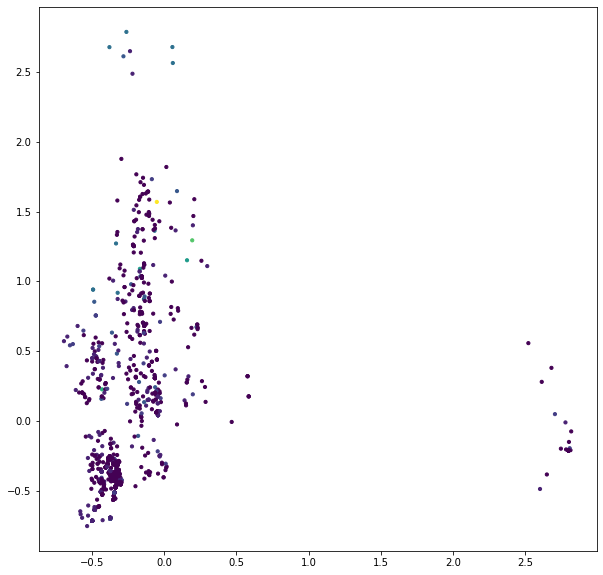

In [130]:
total_blocked = format_df.blocked_chain.apply(lambda x: sum([float(i) for i in x.split(' ')]))

pl.figure(figsize=(10,10))
pl.scatter(pca_model[:,0],pca_model[:,1],s=10,c=total_blocked)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         1.,  0.,  3.,  2.,  1.,  6.,  4.,  5.,  6.,  1.,  5.,  9.,  7.,
         5.,  9.,  9.,  6., 22., 12., 18., 17., 19., 26., 22., 31., 21.,
        29., 31., 29., 36., 22., 34., 25., 40., 23., 33., 30., 28., 29.,
        26., 32., 31., 24., 16., 15., 28., 18., 18., 20., 13., 13.,  6.,
         7., 10.,  3.,  7., 10., 11.,  5.,  3.,  2.,  2.,  5.,  2.,  1.,
         2.,  3.,  3.,  0.,  3.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.31646784, 0.32032306, 0.32417829, 0.32803351, 0.33188874,
        0.33574397, 0.33959919, 0.34345442, 0.34730964, 0.35116487,
        0.3550201 , 0.35887532, 0.36273055, 0.36658577, 0.370441  ,
        0.37429623, 0.37815145, 0.38200668, 0.3858619 , 0.38971713,
        0.39357236, 0.39742758, 0.40128281, 0.40513804, 0.40899326,
        0.41284849, 0.41670371, 0.42055894, 0.42441417, 0.42826939,
        0.43212462, 0.4359

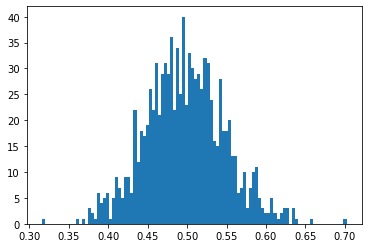

In [321]:
pl.hist(np.random.normal(0.5,scale=0.05,size=1000),bins=100)

In [694]:
format_df.timestamp[0].round(-1)

1600736340.0

In [809]:
encoded = pad_sequences(bpe.encode(list(df.domain.values), output_type=yttm.OutputType.ID),100,padding='post')
#embeds = tm.layers[2](pad_sequences(bpe.encode(list(df.domain.values), output_type=yttm.OutputType.ID),100,padding='post'))

In [810]:
sdm = test_model()
masks_sdm = np.array(list(map(make_mask,len(train)*[1])))
sdm.fit([encoded[train],masks_sdm],tf.keras.utils.to_categorical(df.blocked.values[train],100),epochs=10)

Train on 10280 samples
Epoch 1/10
10280/10280 [==============================] - 5s 451us/sample - loss: 0.0255 - accuracy: 0.9883
Epoch 2/10
10280/10280 [==============================] - 4s 364us/sample - loss: 9.7545e-04 - accuracy: 0.9997
Epoch 3/10
10280/10280 [==============================] - 4s 359us/sample - loss: 3.9267e-04 - accuracy: 0.9999
Epoch 4/10
 1120/10280 [==>...........................] - ETA: 3s - loss: 1.7258e-04 - accuracy: 1.0000

KeyboardInterrupt: 

In [851]:
embeds = mid.predict(encoded[train])
embeds_test = mid.predict(encoded[test])

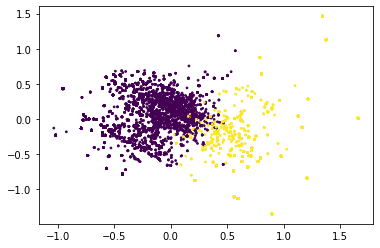

In [852]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2).fit(embeds)
pca_data = pca_model.transform(embeds)
pca_test = pca_model.transform(embeds_test)
pl.scatter(pca_data[:,0],pca_data[:,1],s=3,c=df.blocked.values[train])

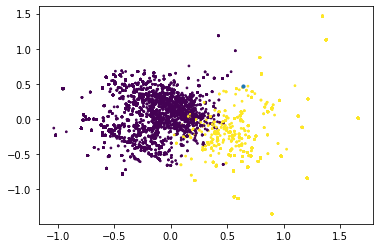

In [878]:
pl.scatter(pca_data[:,0],pca_data[:,1],s=3,c=df.blocked.values[train])
test = pca_model.transform(mid.predict(pad_sequences(bpe.encode(['ads server our friends'], output_type=yttm.OutputType.ID),100,padding='post')))
pl.scatter(test[:,0],test[:,1],s=10)

In [897]:
from sklearn.metrics.pairwise import cosine_similarity
test_case = mid.predict(pad_sequences(bpe.encode(['XXXXXXXX cloudfront net'], output_type=yttm.OutputType.ID),100,padding='post'))

train_labels = np.array(df.blocked.values[train])
good_labels = train_labels == 0
bad_labels = train_labels == 1

print(cosine_similarity(test_case,embeds[bad_labels,:].mean(axis=0).reshape(1,-1)),
cosine_similarity(test_case,embeds[good_labels,:].mean(axis=0).reshape(1,-1)))

[[0.7836937]] [[0.8133749]]


In [906]:
def test_model2():
    input_domains = Input(shape=(100,))
    embed = Embedding(501,64)(input_domains)
    dense1 = Dropout(0.2)(Dense(128,activation=None)(Flatten()(embed)))
    dense2 = Dropout(0.2)(Dense(128,activation='relu')(dense1))
    
    output = Dense(2,activation='softmax')(dense2)
    model = Model(inputs=input_domains,outputs=output)
    #SGD(learning_rate=1e-2)
    model.compile(optimizer=Adam(learning_rate=1e-3),loss='binary_crossentropy',metrics=['accuracy'])
    return model

In [913]:
tm2 = test_model2()
train,test = train_test_split(range(len(encoded)))
tm2.fit(encoded[train],tf.keras.utils.to_categorical(df.blocked.values[train],2),epochs=10)

Train on 84697 samples
Epoch 1/10
84697/84697 [==============================] - 31s 369us/sample - loss: 0.1199 - accuracy: 0.9607
Epoch 2/10
84697/84697 [==============================] - 33s 388us/sample - loss: 0.0650 - accuracy: 0.9793
Epoch 3/10
84697/84697 [==============================] - 33s 386us/sample - loss: 0.0517 - accuracy: 0.9828
Epoch 4/10
84697/84697 [==============================] - 32s 376us/sample - loss: 0.0440 - accuracy: 0.9859
Epoch 5/10
84697/84697 [==============================] - 32s 373us/sample - loss: 0.0378 - accuracy: 0.9876
Epoch 6/10
84697/84697 [==============================] - 32s 374us/sample - loss: 0.0331 - accuracy: 0.9891
Epoch 7/10
84697/84697 [==============================] - 32s 376us/sample - loss: 0.0289 - accuracy: 0.9905
Epoch 8/10
84697/84697 [==============================] - 32s 377us/sample - loss: 0.0271 - accuracy: 0.9913
Epoch 9/10
84697/84697 [==============================] - 32s 377us/sample - loss: 0.0236 - accuracy: 0.9

In [1041]:
b = ['inbox google com','lnkd demdex net','star-mini c10r facebook com','support apple com','mediaserver-cont-dc6-2-v4v6 pandora com',
'www redditmedia com','adsabs harvard edu','click e1 victoriassecret com','mi victoriassecret com','discussions apple com edgekey net',
'emoji redditmedia com','rte stage evernote com','i redd it','reddit com','ios-tuner pandora com','v redd it',
'reddit map fastly net','firebaseremoteconfig googleapis com','beacon dropbox com','graph facebook com',
    'b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com','content analytics arxiv org','smooth pro17 cf cdn hbomax com']
for b_ in b:
    pred = tm2.predict(pad_sequences(bpe.encode([b_], output_type=yttm.OutputType.ID),100,padding='post'))
    print(b_,np.argmax(pred),pred[0,1])

inbox google com 0 3.1780994e-05
lnkd demdex net 1 0.7639862
star-mini c10r facebook com 0 8.226162e-14
support apple com 0 1.4645105e-08
mediaserver-cont-dc6-2-v4v6 pandora com 0 9.5617374e-17
www redditmedia com 0 2.5676677e-06
adsabs harvard edu 1 1.0
click e1 victoriassecret com 0 0.00092587346
mi victoriassecret com 0 0.30783212
discussions apple com edgekey net 1 0.99937123
emoji redditmedia com 0 0.0022681537
rte stage evernote com 1 0.9999995
i redd it 0 4.588377e-09
reddit com 0 1.4324015e-06
ios-tuner pandora com 1 0.5871561
v redd it 0 1.4439924e-09
reddit map fastly net 0 2.6434278e-11
firebaseremoteconfig googleapis com 0 1.4254654e-06
beacon dropbox com 0 0.02766018
graph facebook com 0 0.3501229
b3bb7de118d3a2fed1dd1ee77ed5a2bac10fe77b cws conviva com 1 1.0
content analytics arxiv org 1 0.9984402
smooth pro17 cf cdn hbomax com 0 7.1184217e-20


In [1009]:
tm2.fit(pad_sequences(bpe.encode(['aws-cluster server com'], output_type=yttm.OutputType.ID),100,padding='post'),tf.keras.utils.to_categorical([1],2))

Train on 1 samples
1/1 [==============================] - 0s 44ms/sample - loss: 0.0000e+00 - accuracy: 1.0000


In [1010]:
pred = tm2.predict(pad_sequences(bpe.encode(['ads aws-cluster server com'], output_type=yttm.OutputType.ID),100,padding='post'))
print(pred)

[[2.4799988e-08 1.0000000e+00]]


In [1013]:
tf.keras.layers.Attention?